Table with:
- ATAC DA peaks at 72hr - find closest genes in the promoter region
- Merge this with DE genes
- Sort based on increasing values of log2FC for ATAC peaks and RNA genes


Th17 ATAC DA peaks:
`/data/reddylab/Revathy/collabs/atac-seq_Siklenka/results/deseq2/Th17.72hrs.ASTARR.insert_vs_Th0.72hrs.ASTARR.insert.txt`<br>

Th17 RNAseq DE genes:
`/data/reddylab/Revathy/collabs/rna-seq_Siklenka/results/rna_seq/differential_testing/deseq2/timeseries/Th17.Sorted.72hr_vs_mmTh0.Sorted.72hr.with_genes.txt`

Th17 TPM:
`/data/reddylab/Revathy/collabs/Keith/data/integrative/Th17/TPM/Th17.72hr.Sorted.rna_seq.combined.with_genes.annotation.tmp.bed`

Treg:


Th1 ATAC DA peaks with closest gene annotated:
`/data/reddylab/Revathy/collabs/Keith/Th1/data/atac_seq/deseq/Th1.96hrs.ASTARR.insert_vs_Th0.72hrs.ASTARR.insert.padj0.05.with_closest_gene.bed`<br>


Th2 ATAC DA peaks with closest gene annotated:
`/data/reddylab/Revathy/collabs/Keith/Th2/data/atac_seq/deseq/Th2.96hrs.ASTARR.insert_vs_Th0.72hrs.ASTARR.insert.with_closest_gene.txt`<br>



### Identify the longest transcript of gene and use the TSS of that transcript of the gene to calculate distance

#### Identify transcript with highest value of length
- ensure that this transcript has highest value of TPM too

In [17]:
!head /data/reddylab/Reference_Data/Gencode/vM19/gencode.vM19.basic.annotation.TSS.bed

chr1	3671497	3671498	ENSMUSG00000051951.5	.	-	Xkr4	protein_coding
chr1	4409240	4409241	ENSMUSG00000025900.12	.	-	Rp1	protein_coding
chr1	4497353	4497354	ENSMUSG00000025902.13	.	-	Sox17	protein_coding
chr1	4785738	4785739	ENSMUSG00000033845.13	.	-	Mrpl15	protein_coding
chr1	4807821	4807822	ENSMUSG00000025903.14	.	+	Lypla1	protein_coding
chr1	4807890	4807891	ENSMUSG00000104217.1	.	+	Gm37988	protein_coding
chr1	4857812	4857813	ENSMUSG00000033813.15	.	+	Tcea1	protein_coding
chr1	5070284	5070285	ENSMUSG00000002459.17	.	-	Rgs20	protein_coding
chr1	5070016	5070017	ENSMUSG00000033793.12	.	+	Atp6v1h	protein_coding
chr1	5588491	5588492	ENSMUSG00000025905.13	.	+	Oprk1	protein_coding


In [67]:
import pandas as pd
import glob
import re

files = [
'/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.72hr.Sorted.rep1.star2.rsem.isoforms.results',
'/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.72hr.Sorted.rep2.star2.rsem.isoforms.results',
'/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.72hr.Sorted.rep3.star2.rsem.isoforms.results',
'/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.72hr.Sorted.rep4.star2.rsem.isoforms.results'
]

def column_name(s):
    name = '.'.join(s.split('/')[-1].split('.')[:4])
    return name

df=None
for file in files:
    df_tmp = pd.read_csv(file, sep='\t')
    df_tmp.columns = df_tmp.columns[:-3].tolist() + [column_name(file)] + df_tmp.columns[-2:].tolist()
    if df is None:
        df = df_tmp.loc[:,['transcript_id','gene_id','length','expected_count'] + [df_tmp.columns[-3]]]
    else:
        df = df.join(df_tmp.loc[:, df_tmp.columns[-3]], how='right')

count_columns = ["rep" in c for c in df.columns]
df.loc[:, count_columns] = df.loc[:, count_columns].astype(dtype='float')
df['gene_id'] = df['gene_id'].str.split('.').str[0]
df['transcript_id'] = df['transcript_id'].str.split('.').str[0]
df['Th17.72hr.Sorted.Sum'] = df.iloc[:,4:8].sum(axis=1)
df['Th17.72hr.Sorted.Sum'] = df['Th17.72hr.Sorted.Sum'].round(2)
idx = df.groupby(['gene_id'])['Th17.72hr.Sorted.Sum'].transform(max)==df['Th17.72hr.Sorted.Sum']
df_subset = df[idx]
df_subset.shape

(63299, 9)

In [7]:
import pandas as pd

def TSS_strand(row):
    if row['strand']=='+':
        tss_start=row['start']
        tss_end=row['start']+1
    else:
        tss_start=row['end']-1
        tss_end=row['end']
    return tss_start, tss_end

annot = pd.read_csv('/data/reddylab/Revathy/collabs/Keith/data/annotation_files/gencode.vM19.annotation.transcript.bed', sep='\t',
                    names=['chr','source','type','start','end','strand','gene_id','transcript_id','GeneType','GeneName'])

annot.drop(columns='source', inplace=True)
annot = annot.replace(';','', regex=True)
transcript_annot = annot[annot['type']=='transcript']
transcript_annot['gene_id'] = transcript_annot['gene_id'].str.split('.').str[0]
transcript_annot['transcript_id'] = transcript_annot['transcript_id'].str.split('.').str[0]
transcript_annot[['TSS_start','TSS_end']] = transcript_annot.apply(TSS_strand, axis=1, result_type='expand')
transcript_annot.to_csv('/data/reddylab/Revathy/collabs/Keith/data/annotation_files/gencode.vM19.annotation.transcript_TSS.txt',sep='\t',index=False)

/data/reddylab/software/miniconda3/envs/revathy_py3/lib/python3.5/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/data/reddylab/software/miniconda3/envs/revathy_py3/lib/python3.5/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/data/reddylab/software/miniconda3/envs/revathy_py3/lib/python3.5/site-packages/pandas/core/frame.py:3137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

In [64]:
!cat /data/reddylab/Revathy/collabs/Keith/data/annotation_files/gencode.vM19.annotation.transcript_TSS.txt | grep 'ENSMUST00000114041'

chrX	transcript	77837902	77853530	-	ENSMUSG00000000003	ENSMUST00000114041	protein_coding	Pbsn	77853529	77853530


In [68]:
df_annotated = df_subset.merge(transcript_annot, on=['transcript_id'], how='left')
df_annotated = df_annotated[['chr','TSS_start','TSS_end','gene_id_x','transcript_id','GeneType','GeneName','strand','Th17.72hr.Sorted.Sum']].dropna()
df_annotated.TSS_start = df_annotated.TSS_start.astype(int)
df_annotated.TSS_end = df_annotated.TSS_end.astype(int)
df_annotated.rename(columns={'gene_id_x':'gene_id'}, inplace=True)
df_annotated[['chr','TSS_start','TSS_end','gene_id','transcript_id','strand','GeneName','GeneType','Th17.72hr.Sorted.Sum']].to_csv('/data/reddylab/Revathy/collabs/Keith/data/annotation_files/Th17_gencode.vM19.annotation.expressed_transcript_TSS.bed', sep='\t', index=False, header=None)
transcript_not_expressed_72 = list(df_annotated['transcript_id'][df_annotated['Th17.72hr.Sorted.Sum']==0].unique())
len(transcript_not_expressed_72)


41888

In [69]:
df_annotated[df_annotated.GeneName=='Runx1']

chr  TSS_start   TSS_end             gene_id       transcript_id  \
5324  chr16   92826148  92826149  ENSMUSG00000022952  ENSMUST00000023673   

            GeneType GeneName strand  Th17.72hr.Sorted.Sum  
5324  protein_coding    Runx1      -                 36.75

### find out the most expressed timepoint for the genes which are not expressed in 72hr

In [9]:
import pandas as pd
import glob
import re

isoform_files = {
'Th17.00hr':[
'/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.00hr.rep1.star2.rsem.isoforms.results',
'/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.00hr.rep2.star2.rsem.isoforms.results',
'/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.00hr.rep3.star2.rsem.isoforms.results',
'/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.00hr.rep4.star2.rsem.isoforms.results'
],
'Th17.02hr':[
'/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.02hr.rep1.star2.rsem.isoforms.results',
'/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.02hr.rep2.star2.rsem.isoforms.results',
'/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.02hr.rep3.star2.rsem.isoforms.results',
'/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.02hr.rep4.star2.rsem.isoforms.results'
],
'Th17.16hr':[
'/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.16hr.rep1.star2.rsem.isoforms.results',
'/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.16hr.rep2.star2.rsem.isoforms.results',
'/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.16hr.rep3.star2.rsem.isoforms.results',
'/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.16hr.rep4.star2.rsem.isoforms.results'
],
'Th17.24hr':[
'/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.24hr.rep1.star2.rsem.isoforms.results',
'/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.24hr.rep2.star2.rsem.isoforms.results',
'/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.24hr.rep3.star2.rsem.isoforms.results',
'/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.24hr.rep4.star2.rsem.isoforms.results'
],
'Th17.48hr':[
'/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.48hr.rep1.star2.rsem.isoforms.results',
'/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.48hr.rep2.star2.rsem.isoforms.results',
'/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.48hr.rep3.star2.rsem.isoforms.results',
'/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.48hr.rep4.star2.rsem.isoforms.results'
]
}

def column_name(s):
    name = '.'.join(s.split('/')[-1].split('.')[:3])
    return name

tpm_df=None
for isoform, files in isoform_files.items():
    df=None
    for file in files:
        df_tmp = pd.read_csv(file, sep='\t')
        df_tmp.columns = df_tmp.columns[:-3].tolist() + [column_name(file)] + df_tmp.columns[-2:].tolist()
        if df is None:
            df = df_tmp.loc[:,['transcript_id','gene_id','length','expected_count'] + [df_tmp.columns[-3]]]
        else:
            df = df.join(df_tmp.loc[:, df_tmp.columns[-3]], how='right')

    count_columns = ["rep" in c for c in df.columns]
    df.loc[:, count_columns] = df.loc[:, count_columns].astype(dtype='float')
    df['%s.Sum'%(isoform)] = df.iloc[:,4:8].sum(axis=1)
    df['%s.Sum'%(isoform)] = df['%s.Sum'%(isoform)].round(2)
    df = df[['gene_id','transcript_id','%s.Sum' % isoform]]
    df['gene_id'] = df['gene_id'].str.split('.').str[0]
    df['transcript_id'] = df['transcript_id'].str.split('.').str[0]
    if tpm_df is None:
        tpm_df = df
    else:
        tpm_df = tpm_df.merge(df, on=['gene_id','transcript_id'], how='outer')
    count_columns = ["Sum" in c for c in tpm_df.columns]
    tpm_df.loc[:, count_columns] = tpm_df.loc[:, count_columns].astype(dtype='float')

tpm_df['max'] = tpm_df[['Th17.00hr.Sum','Th17.02hr.Sum','Th17.16hr.Sum','Th17.24hr.Sum','Th17.48hr.Sum']].max(axis=1)
idx = tpm_df.groupby(['gene_id'])['max'].transform(max)==tpm_df['max']
tpm_df_subset = tpm_df[idx]
tpm_df_annotated = tpm_df_subset.merge(transcript_annot, on=['transcript_id'], how='left')
# tpm_df_annotated_not_72 = tpm_df_annotated[tpm_df_annotated.transcript_id.isin(transcript_not_expressed_72)]
# tpm_df_annotated_not_72 = tpm_df_annotated_not_72[['chr','TSS_start','TSS_end','gene_id_x','transcript_id','strand','GeneName','GeneType','max']]
# tpm_df_annotated_not_72.rename(columns={'max':'tpm', 'gene_id_x':'gene_id'}, inplace=True)
# tpm_df_annotated_not_72['cell_type']='Th17'
# tpm_df_annotated_not_72.to_csv('/data/reddylab/Revathy/collabs/Keith/Th17/data/rna_seq/counts/Th17_transcript_genes_not_72.txt', sep='\t', index=False)


In [13]:
Genes=['Il17a','Il17f','Batf','Fos','Cd3']
tpm_df_annotated[['GeneName','Th17.00hr.Sum','Th17.02hr.Sum','Th17.16hr.Sum','Th17.24hr.Sum','Th17.48hr.Sum']][tpm_df_annotated.GeneName.isin(Genes)]


GeneName  Th17.00hr.Sum  Th17.02hr.Sum  Th17.16hr.Sum  Th17.24hr.Sum  \
3687       Fos         146.18        1121.00          10.21          28.67   
6403     Il17a           7.36          10.03          34.90          81.60   
12098     Batf         156.69        1288.45        1084.36        1480.74   
15620    Il17f          28.86          37.53        2056.96        1519.32   

       Th17.48hr.Sum  
3687           15.47  
6403         8045.80  
12098         840.64  
15620       35970.07

In [76]:
tpm_df_annotated_not_72[tpm_df_annotated_not_72.GeneName=='Batf']

Empty DataFrame
Columns: [chr, TSS_start, TSS_end, gene_id, transcript_id, strand, GeneName, GeneType, tpm, cell_type]
Index: []

#### Th17 ATAC DA peaks closest genes

In [1]:
!head /data/reddylab/Revathy/collabs/atac-seq_Siklenka/results/deseq2/Th17.72hrs.ASTARR.insert_vs_Th0.72hrs.ASTARR.insert.txt

baseMean	log2FoldChange	lfcSE	pvalue	padj
chr4_143288226_143289757	1647.73336636732	3.81726459784635	0.149421823937938	2.26509166736847e-145	1.54875642756319e-140
chr16_25010772_25012159	1485.52387348661	3.48472723761304	0.140449160020006	4.20040679819601e-137	1.43601407413326e-132
chr2_181099140_181100692	1928.35072840258	2.9614912246334	0.12138931489356	2.19773839527376e-132	5.00901209256145e-128
chr17_24922152_24923413	1302.95899109185	4.05652786705213	0.173908025374107	6.24351466900603e-122	1.06725078873322e-117
chr6_88827500_88829063	1481.49179677977	3.53133982990557	0.152986375873328	3.99629865460984e-119	5.46493841017895e-115
chr1_36965264_36966375	1868.2189488516	2.32734236110937	0.102147391471507	1.24159084180454e-115	1.41489623013975e-111
chr12_70890543_70891870	1399.96979228548	3.98211754387464	0.178451046369452	7.65614613393013e-112	7.47841417010676e-108
chr1_93529464_93530987	1365.00075899984	3.19374550045465	0.143893638020533	3.44938808156298e-110	2.94814887596086e-106
ch

In [26]:
%%bash
sort -k1,1 -k2,2n /data/reddylab/Revathy/collabs/Keith/data/annotation_files/gencode.vM19.annotation.expressed_transcript_TSS.bed \
> /data/reddylab/Revathy/collabs/Keith/data/annotation_files/gencode.vM19.annotation.expressed_transcript_TSS.sorted.bed

In [27]:
!head /data/reddylab/Revathy/collabs/Keith/data/annotation_files/gencode.vM19.annotation.expressed_transcript_TSS.sorted.bed

chr1	3073253	3073254	ENSMUSG00000102693.1	+	4933401J01Rik	TEC	0.0
chr1	3102016	3102017	ENSMUSG00000064842.1	+	Gm26206	snRNA	0.0
chr1	3215631	3215632	ENSMUSG00000051951.5	-	Xkr4	protein_coding	0.0
chr1	3216343	3216344	ENSMUSG00000051951.5	-	Xkr4	protein_coding	0.0
chr1	3252757	3252758	ENSMUSG00000102851.1	+	Gm18956	processed_pseudogene	0.0
chr1	3368548	3368549	ENSMUSG00000103377.1	-	Gm37180	TEC	0.0
chr1	3377787	3377788	ENSMUSG00000104017.1	-	Gm37363	TEC	0.0
chr1	3466587	3466588	ENSMUSG00000089699.1	+	Gm1992	antisense	0.0
chr1	3467284	3467285	ENSMUSG00000103025.1	-	Gm37686	TEC	0.0
chr1	3514506	3514507	ENSMUSG00000103201.1	-	Gm37329	TEC	0.0


In [39]:
%%bash
sbatch -p all \
    --cpus-per-task 1 \
    --mem 8G \
    -o /data/reddylab/Revathy/collabs/Keith/data/integrative/logs/Th17_ATAC_closest_genes.out \
    <<'EOF'
#!/bin/bash
SAMPLE="/data/reddylab/Revathy/collabs/atac-seq_Siklenka/results/deseq2/Th17.72hrs.ASTARR.insert_vs_Th0.72hrs.ASTARR.insert.txt"

tail -n+2 ${SAMPLE} \
| cut -f1 \
| awk -F_ -vOFS="\t" '{print $1, $2, $3, $1"_"$2"_"$3}' \
| sort -k1,1 -k2,2n \
| bedtools closest \
    -nonamecheck \
    -D a \
    -a - \
    -b /data/reddylab/Revathy/collabs/Keith/data/annotation_files/gencode.vM19.annotation.expressed_transcript_TSS.sorted.bed \
| awk -vOFS="\t" \
    '{if(last==$4){genes=$10","genes;}else{if(genes){print peak, genes, distance}peak=$4; genes=$10; distance=$13; last=peak}}END{if(last==$4){genes=$10","genes;print peak, genes, distance}}' \
> ${SAMPLE/.txt/.closest_gene.txt}

EOF

Submitted batch job 28448936


In [1]:
!wc -l /data/reddylab/Revathy/collabs/atac-seq_Siklenka/results/deseq2/Th17.72hrs.ASTARR.insert_vs_Th0.72hrs.ASTARR.insert.closest_gene.txt

68375 /data/reddylab/Revathy/collabs/atac-seq_Siklenka/results/deseq2/Th17.72hrs.ASTARR.insert_vs_Th0.72hrs.ASTARR.insert.closest_gene.txt


In [4]:
%%bash
sbatch -p all \
    --cpus-per-task 1 \
    --mem 8G \
    -o /data/reddylab/Revathy/collabs/Keith/data/integrative/logs/Th17_all_ATAC_closest_genes.out \
    <<'EOF'
#!/bin/bash
SAMPLE="/data/reddylab/Revathy/collabs/atac-seq_Siklenka/analysis/Th17.72hrs.UnionPeakSet.featurecounts.df.txt"

tail -n+2 ${SAMPLE} \
| cut -f1 \
| awk -F_ -vOFS="\t" '{print $1, $2, $3, $1"_"$2"_"$3}' \
| sort -k1,1 -k2,2n \
| bedtools closest \
    -nonamecheck \
    -D a \
    -a - \
    -b /data/reddylab/Revathy/collabs/Keith/data/annotation_files/gencode.vM19.annotation.expressed_transcript_TSS.sorted.bed \
| awk -vOFS="\t" \
    '{if(last==$4){genes=$10","genes;}else{if(genes){print peak, genes, distance}peak=$4; genes=$10; distance=$13; last=peak}}END{if(last==$4){genes=$10","genes;print peak, genes, distance}}' \
> ${SAMPLE/.featurecounts.df.txt/.closest_gene.txt}

EOF

Submitted batch job 28576100


In [32]:
!ls /data/reddylab/Revathy/collabs/Keith/Th17/data/integration/

Th17_all_ATAC_RNA_promoters.txt  Th17_atac_rna_promoters_with_clusters.txt
Th17_ATAC_RNA_promoters.txt	 Th17_RNA_DE_genes_transcript_level_info.txt


In [33]:
%%bash
tail -n+2 /data/reddylab/Revathy/collabs/atac-seq_Siklenka/analysis/Th17.72hrs.UnionPeakSet.featurecounts.df.txt \
| cut -f1 \
| awk -F_ -vOFS="\t" '{print $1, $2, $3, $1"_"$2"_"$3}' \
| bedtools intersect -wa -wb \
-a - \
-b /data/reddylab/Revathy/collabs/Keith/ENCODE_submission/data/csaw_peaks/Th17.atacSTARR.pooled.3window_minTest.weighted.csaw.mm10.noATACpeaks.0bp_min.0.01.corrected.bed \
| cut -f4- \
> /data/reddylab/Revathy/collabs/Keith/Th17/data/integration/Th17_ATAC_closest_gene_ASTARR_intersect.bed

***** WARNING: File - has inconsistent naming convention for record:
GL456216.1	15706	17573	GL456216.1_15706_17573

***** WARNING: File - has inconsistent naming convention for record:
GL456216.1	15706	17573	GL456216.1_15706_17573



In [2]:
!wc -l /data/reddylab/Revathy/collabs/atac-seq_Siklenka/analysis/Th17.72hrs.UnionPeakSet.closest_gene.txt

84222 /data/reddylab/Revathy/collabs/atac-seq_Siklenka/analysis/Th17.72hrs.UnionPeakSet.closest_gene.txt


In [7]:
%%bash
head /data/reddylab/Revathy/collabs/Keith/data/annotation_files/gencode.vM19.annotation.expressed_transcript_TSS.sorted.bed


chr1_4491842_4492115	Sox17	1489
chr1_4492489_4493388	Sox17	216
chr1_4496438_4497087	Sox17,Gm37587	0
chr1_4571640_4571997	Gm37323	14255
chr1_4600559_4601117	Gm7369	9355
chr1_4671564_4672001	Gm6085	17402
chr1_4724647_4724940	Gm25493	-1269
chr1_4748181_4748505	Gm2053	-12506
chr1_4774994_4775958	Gm37144	3254
chr1_4785097_4786265	Mrpl15	0


### Th17

In [36]:
!head /data/reddylab/Revathy/collabs/Keith/data/integrative/Th17/TPM/Th17.72hr.Sorted.rna_seq.combined.with_genes.annotation.tmp.bed

chr3	108107279	108146146	Gnai3	110.48
chrX	77837900	77853623	Pbsn	0.0
chr16	18780446	18811972	Cdc45	66.83
chr7	142575528	142578143	H19	0.5
chrX	161117192	161258213	Scml2	1.3
chr11	108395292	108414396	Apoh	0.02
chr11	121237252	121255856	Narf	9.13
chr6	17281184	17289115	Cav2	2.24
chr13	5861481	5870394	Klf6	135.03
chr4	120405306	120530184	Scmh1	13.54


In [40]:
!head /data/reddylab/Revathy/collabs/atac-seq_Siklenka/results/deseq2/Th17.72hrs.ASTARR.insert_vs_Th0.72hrs.ASTARR.insert.closest_gene.txt

chr1_4600559_4601117	Gm7369	9355
chr1_4671564_4672001	Gm6085	17402
chr1_4774994_4775958	Gm37144	3254
chr1_4785097_4786265	Mrpl15	0
chr1_4807274_4808576	Gm37988,Lypla1	0
chr1_4857087_4858887	Tcea1	0
chr1_4888157_4888775	Gm6104	-7507
chr1_4915898_4916201	Gm37277	-9038
chr1_5015194_5015905	Rgs20	3474
chr1_5019033_5020138	Rgs20	0


In [6]:
import pandas as pd
import numpy as np

closest_gene = pd.read_csv('/data/reddylab/Revathy/collabs/atac-seq_Siklenka/analysis/Th17.72hrs.UnionPeakSet.closest_gene.txt', sep='\t', 
                                names=['chr_start_end','GeneName','distance'])
Th17_atac = pd.read_csv('/data/reddylab/Revathy/collabs/atac-seq_Siklenka/results/deseq2/Th17.72hrs.ASTARR.insert_vs_Th0.72hrs.ASTARR.insert.txt', sep='\t')
Th17_rna = pd.read_csv('/data/reddylab/Revathy/collabs/rna-seq_Siklenka/results/rna_seq/differential_testing/deseq2/timeseries/Th17.Sorted.72hr_vs_mmTh0.Sorted.72hr.with_genes.txt', sep='\t')
Th17_rna_tpm = pd.read_csv('/data/reddylab/Revathy/collabs/Keith/data/integrative/Th17/TPM/Th17.72hr.Sorted_most_expressed_transcript_annotated.bed', sep='\t',
                      names=['chr','start','end','GeneName','Th17.72hr.Sorted.Sum'])
Th17_astarr = pd.read_csv('/data/reddylab/Revathy/collabs/Keith/Th17/data/integration/Th17_ATAC_closest_gene_ASTARR_intersect.bed', sep='\t',
                         names=['chr_start_end','ASTARR_chr','ASTARR_start','ASTARR_end','name','score','strand','ASTARR_log2FC','ASTARR_padj','qval','number'])

Th17_atac.reset_index(inplace=True)
Th17_atac_rna_closest_DE_gene_tpm = Th17_atac.merge(closest_gene, left_on='index', right_on='chr_start_end', how='outer').merge(Th17_rna, on='GeneName', how='inner').merge(Th17_rna_tpm, on='GeneName', how='inner')
Th17_atac_astarr_closest_DE_gene_tpm = Th17_atac_rna_closest_DE_gene_tpm.merge(Th17_astarr, on='chr_start_end', how='outer')
Th17_atac_astarr_closest_DE_gene_tpm = Th17_atac_astarr_closest_DE_gene_tpm.rename(columns={'log2FoldChange_x':'ATAC_log2FC',
                                                              'log2FoldChange_y':'RNA_log2FC',
                                                              'padj_x':'ATAC_padj',
                                                              'padj_y':'RNA_padj',
                                                              'Th17.72hr.Sorted.Sum':'RNA_tpm'})


Th17_atac_astarr_closest_DE_gene_tpm = Th17_atac_astarr_closest_DE_gene_tpm[['chr_start_end','GeneName','ATAC_log2FC','ATAC_padj','ASTARR_chr','ASTARR_start','ASTARR_end','ASTARR_log2FC','ASTARR_padj','RNA_log2FC','RNA_padj','RNA_tpm','distance','GeneType']]
# atac_rna_closest_gene_tpm_subset = atac_rna_closest_gene_tpm[(np.abs(atac_rna_closest_gene_tpm['distance'])<=3000) & (atac_rna_closest_gene_tpm['GeneType']=='protein_coding')]
# atac_rna_closest_gene_tpm_subset = atac_rna_closest_gene_tpm_subset[(atac_rna_closest_gene_tpm_subset['RNA_padj']<0.05)]
Th17_atac_astarr_closest_DE_gene_tpm.to_csv('/data/reddylab/Revathy/collabs/Keith/Th17/data/integration/Th17_all_ATAC_ASTARR_RNA.txt', sep='\t', index=False)

Th17_DE_genes = list(Th17_atac_astarr_closest_DE_gene_tpm.GeneName.unique())
len(Th17_DE_genes)

7706

In [5]:
Genes = ['Il17a','Il17f','Batf','Fos','Cd3']
rna_tpm[rna_tpm.GeneName.isin(Genes)]

chr       start         end GeneName  Th17.72hr.Sorted.Sum
3540   chr12  85473888.0  85473889.0      Fos                 21.92
5407    chr1  20730903.0  20730904.0    Il17a              14412.26
14859   chr1  20784269.0  20784270.0    Il17f              37149.01

#### Retreive the transcript information for the genes in the MasterTable

In [15]:
import pandas as pd

rna_transcript = pd.read_csv('/data/reddylab/Revathy/collabs/Keith/data/annotation_files/Th17_gencode.vM19.annotation.expressed_transcript_TSS.bed', sep='\t',
                             names=['chr','TSS_start','TSS_end','gene_id','transcript_id','strand','GeneName','GeneType','Th17.72hr.Sorted.Sum'])
rna_transcript_DE_genes = rna_transcript[rna_transcript.GeneName.isin(Th17_DE_genes)]
rna_transcript_DE_genes[['chr','TSS_start','TSS_end','gene_id','transcript_id','GeneName','Th17.72hr.Sorted.Sum']].to_csv('/data/reddylab/Revathy/collabs/Keith/Th17/data/integration/Th17_RNA_DE_genes_transcript_level_info.txt', sep='\t', index=False)


In [16]:
rna_transcript_DE_genes.shape

(4971, 9)

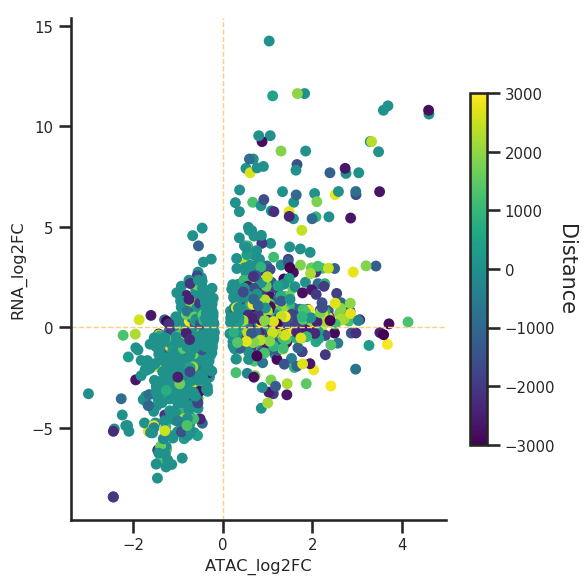

In [9]:
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import seaborn as sns
%matplotlib inline

sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
sns.set_context("talk", font_scale=0.65)
plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':100})

fig = plt.figure(figsize=(6,6))
ax = plt.subplot(1, 1, 1)

points = ax.scatter(
    atac_rna_closest_gene_tpm_subset['ATAC_log2FC'], 
    atac_rna_closest_gene_tpm_subset['RNA_log2FC'],
    c=atac_rna_closest_gene_tpm_subset['distance'],
    cmap='viridis', marker='o', s=40)

cbar = fig.colorbar(points, shrink=0.7)
cbar.set_label('Distance', rotation=270, fontsize=15, labelpad=15)
cbar.mappable.set_clim(-3000,3000)

plt.xlabel('ATAC_log2FC')
plt.ylabel('RNA_log2FC')

sns.despine(fig,ax)

#simpleaxis(ax)
plt.tight_layout()
plt.axhline(0, color='#ffcc80', linewidth = 1, linestyle = 'dashed')
plt.axvline(0, color='#ffcc80', linewidth = 1, linestyle = 'dashed')
plt.show()

### DE genes from the 72hr timepoint and DPGP on them

- for the list of unique DE genes from the 72hr, perform DP_GP on their TPM values (average TPM across replicates for all timepoints)

In [17]:
import pandas as pd
import glob
import re

tpm_files = {
'Th17.00hr':[
'/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.00hr.rep1.star2.rsem.genes.results',
'/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.00hr.rep2.star2.rsem.genes.results',
'/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.00hr.rep3.star2.rsem.genes.results',
'/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.00hr.rep4.star2.rsem.genes.results'
],
'Th17.02hr':[
'/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.02hr.rep1.star2.rsem.genes.results',
'/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.02hr.rep2.star2.rsem.genes.results',
'/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.02hr.rep3.star2.rsem.genes.results',
'/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.02hr.rep4.star2.rsem.genes.results'
],
'Th17.16hr':[
'/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.16hr.rep1.star2.rsem.genes.results',
'/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.16hr.rep2.star2.rsem.genes.results',
'/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.16hr.rep3.star2.rsem.genes.results',
'/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.16hr.rep4.star2.rsem.genes.results'
],
'Th17.24hr':[
'/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.24hr.rep1.star2.rsem.genes.results',
'/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.24hr.rep2.star2.rsem.genes.results',
'/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.24hr.rep3.star2.rsem.genes.results',
'/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.24hr.rep4.star2.rsem.genes.results'
],
'Th17.48hr':[
'/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.48hr.rep1.star2.rsem.genes.results',
'/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.48hr.rep2.star2.rsem.genes.results',
'/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.48hr.rep3.star2.rsem.genes.results',
'/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.48hr.rep4.star2.rsem.genes.results'
],
'Th17.72hr':[
'/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.72hr.Sorted.rep1.star2.rsem.genes.results',
'/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.72hr.Sorted.rep2.star2.rsem.genes.results',
'/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.72hr.Sorted.rep3.star2.rsem.genes.results',
'/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.72hr.Sorted.rep4.star2.rsem.genes.results'
]
}

ref_gene = pd.read_csv('/data/reddylab/Reference_Data/Gencode/vM13/gencode.vM13.gene_id_to_gene_name.txt', sep='\t', names=['gene_id', 'gene', 'gene_type'])

def column_name(s):
    name = '.'.join(s.split('/')[-1].split('.')[:4])
    return name

avg_tpm_df=None
for tpm, files in tpm_files.items():
    df=None
    for file in files:
        df_tmp = pd.read_csv(file, sep='\t')
        df_tmp.columns = df_tmp.columns[:-2].tolist() + [column_name(file)] + df_tmp.columns[-1:].tolist()
        if df is None:
            df = df_tmp.loc[:, ['gene_id'] + [df_tmp.columns[-2]]]
        else:
            df = df.join(df_tmp.loc[:, df_tmp.columns[-2]], how='right')

    count_columns = ["rep" in c for c in df.columns]
    df.loc[:, count_columns] = df.loc[:, count_columns].astype(dtype='float')
    df['%s.Mean'%(tpm)] = df.iloc[:,1:5].mean(axis=1)
    df['%s.Mean'%(tpm)] = df['%s.Mean'%(tpm)].round(2)
    df = df[['gene_id','%s.Mean' % tpm]]
    if avg_tpm_df is None:
        avg_tpm_df = df
    else:
        avg_tpm_df = avg_tpm_df.merge(df, on='gene_id', how='outer')
    count_columns = ["rep" in c for c in avg_tpm_df.columns]
    avg_tpm_df.loc[:, count_columns] = avg_tpm_df.loc[:, count_columns].astype(dtype='float')
    
tpm_df_with_gene = avg_tpm_df.merge(ref_gene, on='gene_id', how='left') 
tpm_df_with_gene = tpm_df_with_gene[['gene','Th17.00hr.Mean','Th17.02hr.Mean','Th17.16hr.Mean','Th17.24hr.Mean','Th17.48hr.Mean','Th17.72hr.Mean']]
tpm_df_with_gene.to_csv('/data/reddylab/Revathy/collabs/Keith/Th17/data/rna_seq/counts/Th17.tpm.mean.txt', sep='\t', index=False)
tpm_df_with_gene[tpm_df_with_gene.gene=='Batf']

gene  Th17.00hr.Mean  Th17.02hr.Mean  Th17.16hr.Mean  Th17.24hr.Mean  \
9620  Batf           39.17          322.11          271.09          370.18   

      Th17.48hr.Mean  Th17.72hr.Mean  
9620          210.16          189.96

In [3]:
import pandas as pd
import numpy as np

Th17_tpm = pd.read_csv('/data/reddylab/Revathy/collabs/Keith/Th17/data/rna_seq/counts/Th17.tpm.mean.txt', sep='\t')
Th17_tpm_72hr_genes = Th17_tpm[Th17_tpm.gene.isin(Th17_DE_genes)]
Th17_tpm_72hr_genes = Th17_tpm_72hr_genes[(Th17_tpm_72hr_genes.iloc[:,1:7]!=0).any(axis=1)]
Th17_tpm_72hr_genes.rename(columns={'Th17.00hr.Mean':'00',
                                    'Th17.02hr.Mean':'02',
                                    'Th17.16hr.Mean':'16',
                                    'Th17.24hr.Mean':'24',
                                    'Th17.48hr.Mean':'48',
                                    'Th17.72hr.Mean':'72'}, inplace=True)
Th17_tpm_72hr_genes.to_csv('/data/reddylab/Revathy/collabs/Keith/Th17/data/rna_seq/Th17_tpm_72hr_DE_genes.txt', sep='\t', index=False)
# [(Th17_tpm_72hr_genes == 0).sum(1)<3]
len(Th17_tpm_72hr_genes)


4966

#### DPGP clustering

In [9]:
%%bash
source /data/reddylab/software/miniconda2/bin/activate alex
mkdir -p /data/reddylab/Revathy/collabs/Keith/Th17/analysis/DPGP
mkdir -p /data/reddylab/Revathy/collabs/Keith/Th17/logs
sbatch -p all \
    -o /data/reddylab/Revathy/collabs/Keith/Th17/logs/Th17_dp_gp_72hr_DE_genes_tpm.out \
    --cpus-per-task 4 \
    --mem 128G \
    <<'EOF'
#!/bin/sh
module load gcc
#SBATCH --cpus-per-task=1
#SBATCH --mem=64G
outfile="/data/reddylab/Revathy/collabs/Keith/Th17/analysis/DPGP/Th17_72hr_DEGs_TPM.alpha_0.001.log2fc_DP_GP"
infile="/data/reddylab/Revathy/collabs/Keith/Th17/data/rna_seq/Th17_tpm_72hr_DE_genes.txt"
#
DP_GP_cluster.py \
--alpha 0.001 \
--true_times \
-i ${infile}  \
-o ${outfile} \
-p png \
--plot
EOF

Submitted batch job 28588514


#### DPGP for TFs from Th17



In [13]:
%%bash
source /data/reddylab/software/miniconda2/bin/activate alex
sbatch -p all \
    -o /data/reddylab/Revathy/collabs/Keith/Th17/logs/Th17_dp_gp_TFs_tpm.out \
    --cpus-per-task 4 \
    --mem 128G \
    <<'EOF'
#!/bin/sh
module load gcc
#SBATCH --cpus-per-task=1
#SBATCH --mem=64G
outfile="/data/reddylab/Revathy/collabs/Keith/Th17/analysis/DPGP/Th17_TFs_TPM.alpha_0.001.log2fc_DP_GP"
infile="/data/reddylab/Revathy/collabs/Keith/Th17/data/rna_seq/220715_ExpressedTFs_Th17.txt"
#
DP_GP_cluster.py \
--alpha 0.001 \
--true_times \
-i ${infile}  \
-o ${outfile} \
-p png \
--plot
EOF

Submitted batch job 28646429


In [4]:
import pandas as pd

clusters = pd.read_csv('/data/reddylab/Revathy/collabs/Keith/Th17/analysis/DPGP/Th17_72hr_DEGs_TPM.alpha_0.001.log2fc_DP_GP_optimal_clustering.txt', sep='\t')
clusters = clusters.rename(columns={'gene':'GeneName'})

atac_rna_closest_gene_tpm_subset_clusters = atac_rna_closest_gene_tpm_subset.merge(clusters, on='GeneName', how='left')
atac_rna_closest_gene_tpm_subset_clusters['cluster'] = atac_rna_closest_gene_tpm_subset_clusters['cluster'].fillna(0)
atac_rna_closest_gene_tpm_subset_clusters['cell_type'] = 'Th17'
atac_rna_closest_gene_tpm_subset_clusters.to_csv('/data/reddylab/Revathy/collabs/Keith/Th17/data/integration/Th17_atac_rna_promoters_with_clusters.txt', sep='\t', index=False)
atac_rna_closest_gene_tpm_subset_clusters[atac_rna_closest_gene_tpm_subset_clusters['cluster']==0]


chr_start_end       GeneName  ATAC_log2FC  ATAC_padj  \
2510  chr3_61363160_61365608  B430305J03Rik    -0.332248   0.000426   
2511  chr3_61368680_61369168  B430305J03Rik    -0.515982   0.017463   

      RNA_log2FC      RNA_padj  RNA_tpm  distance        GeneType  cluster  \
2510   -3.191157  1.140080e-15      0.0       343  protein_coding      0.0   
2511   -3.191157  1.140080e-15      0.0     -2730  protein_coding      0.0   

     cell_type  
2510      Th17  
2511      Th17

In [5]:
atac_rna_closest_gene_tpm_subset_clusters.describe()

ATAC_log2FC     ATAC_padj   RNA_log2FC      RNA_padj       RNA_tpm  \
count  5929.000000  5.929000e+03  6063.000000  6.063000e+03   6063.000000   
mean     -0.100364  2.730320e-01    -0.046398  2.743119e-03    296.693657   
std       0.592339  3.081022e-01     1.517968  8.059389e-03   1364.075207   
min      -2.993416  1.954086e-81    -8.445789  0.000000e+00      0.000000   
25%      -0.350726  6.252000e-03    -0.604953  2.790467e-22     19.460000   
50%      -0.141521  1.328189e-01     0.132234  1.683299e-09     64.300000   
75%       0.027284  4.969307e-01     0.541652  2.017944e-04    187.475000   
max       4.605843  9.992898e-01    14.246579  4.992139e-02  37149.010000   

          distance      cluster  
count  6063.000000  6063.000000  
mean     -2.464292     7.765133  
std     929.735803     4.042490  
min   -3000.000000     0.000000  
25%       0.000000     4.000000  
50%       0.000000     8.000000  
75%       0.000000    11.000000  
max    2991.000000    15.000000

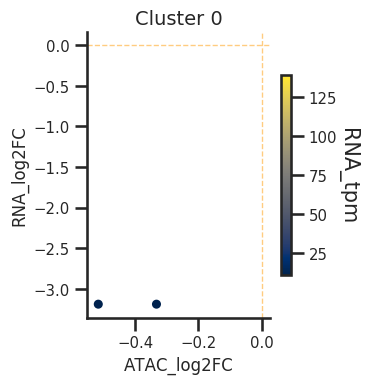

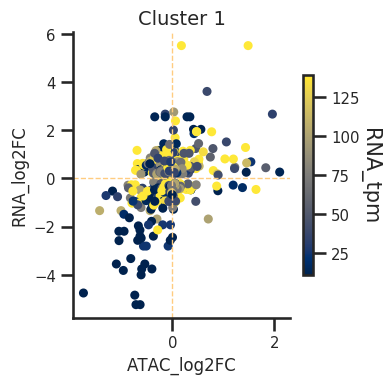

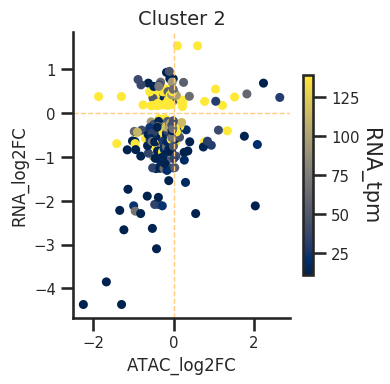

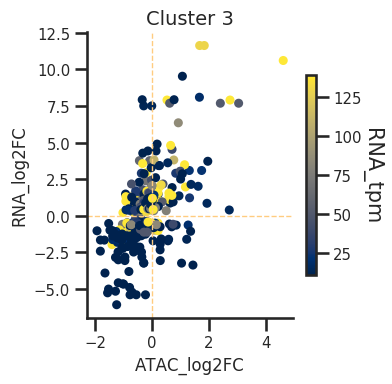

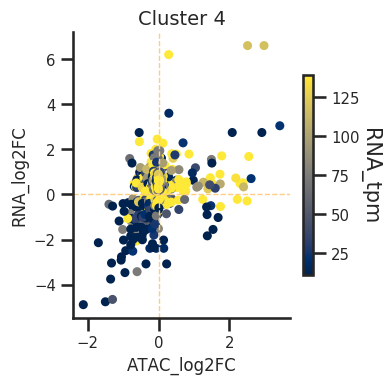

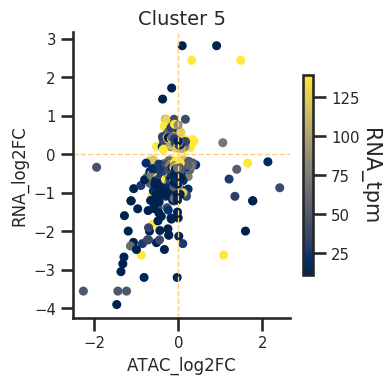

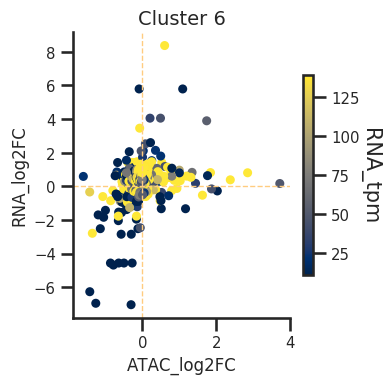

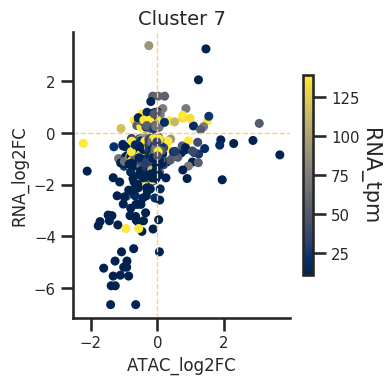

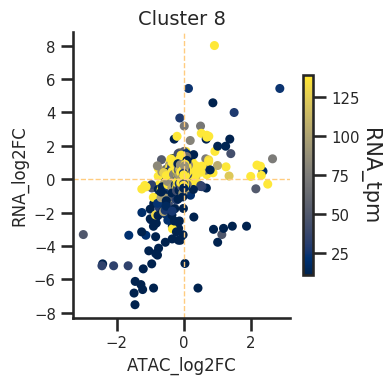

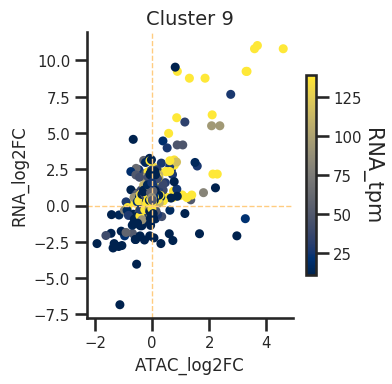

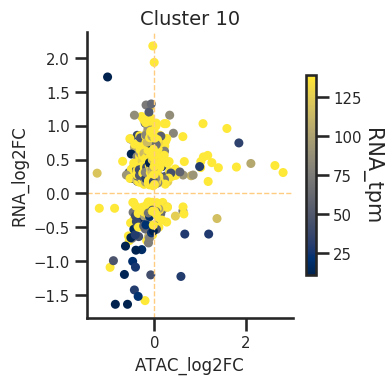

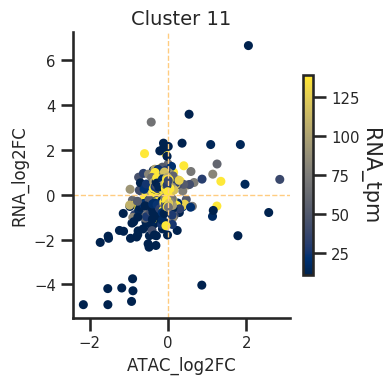

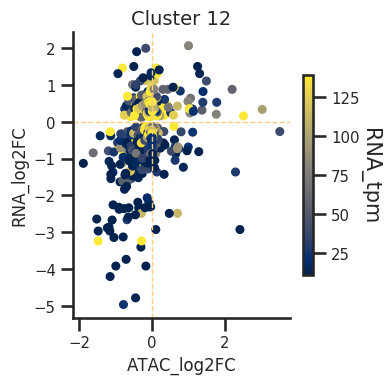

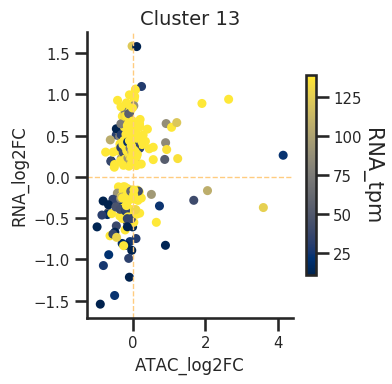

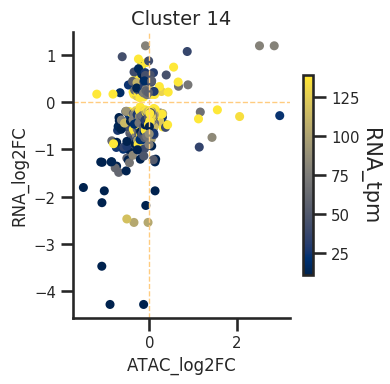

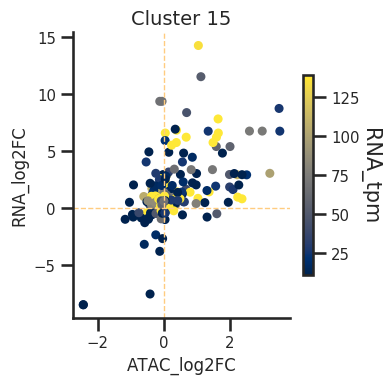

In [6]:
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import seaborn as sns
%matplotlib inline

sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
sns.set_context("talk", font_scale=0.65)
plt.rcParams.update({'figure.figsize':(4,4), 'figure.dpi':100})


for idx, gp in atac_rna_closest_gene_tpm_subset_clusters.groupby('cluster'):
    fig, ax = plt.subplots(figsize=(4,4))
    points = ax.scatter(x=gp['ATAC_log2FC'], y=gp['RNA_log2FC'],
               c=gp['RNA_tpm'], cmap='cividis',marker='o', s=25)
    cbar = fig.colorbar(points, shrink=0.7)
    cbar.set_label('RNA_tpm', rotation=270, fontsize=15, labelpad=15)
    cbar.mappable.set_clim(11,139)
    
    ax.grid()
    ax.set_ylabel('RNA_log2FC', fontsize=12)
    ax.set_xlabel('ATAC_log2FC', fontsize=12)
    ax.set_title('Cluster %d'%idx, fontsize=14)
    sns.despine(fig,ax)
    plt.tight_layout()
    plt.axhline(0, color='#ffcc80', linewidth = 1, linestyle = 'dashed')
    plt.axvline(0, color='#ffcc80', linewidth = 1, linestyle = 'dashed')
    plt.grid(False)
    plt.show()

    

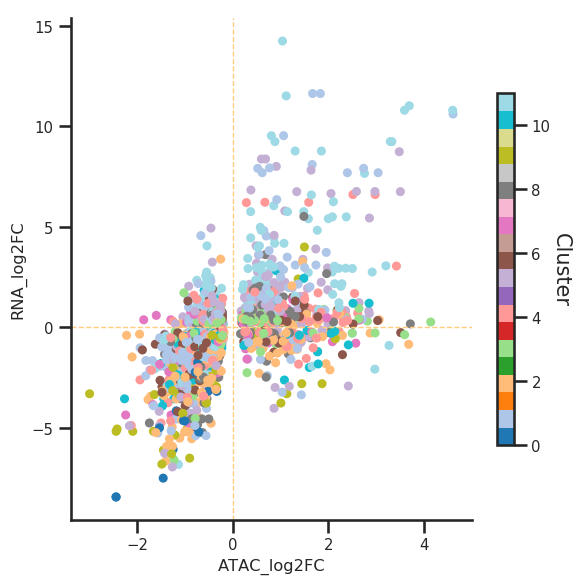

In [3]:
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import seaborn as sns
%matplotlib inline

sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
sns.set_context("talk", font_scale=0.65)
plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':100})

fig = plt.figure(figsize=(6,6))
ax = plt.subplot(1, 1, 1)

points = ax.scatter(
    atac_rna_closest_gene_tpm_subset_clusters['ATAC_log2FC'], 
    atac_rna_closest_gene_tpm_subset_clusters['RNA_log2FC'],
    c=atac_rna_closest_gene_tpm_subset_clusters['cluster'],
    cmap='tab20', marker='o', s=25)

cbar = fig.colorbar(points, shrink=0.7)
cbar.set_label('Cluster', rotation=270, fontsize=15, labelpad=15)
cbar.mappable.set_clim(0,11)

plt.xlabel('ATAC_log2FC')
plt.ylabel('RNA_log2FC')

sns.despine(fig,ax)

#simpleaxis(ax)
plt.tight_layout()
plt.axhline(0, color='#ffcc80', linewidth = 1, linestyle = 'dashed')
plt.axvline(0, color='#ffcc80', linewidth = 1, linestyle = 'dashed')
plt.show()

# Th1

## follow similar steps as of Th17

1. Annotating transcripts with maximum expression

In [78]:
import pandas as pd
import glob
import re

files = [
'/data/reddylab/Revathy/collabs/Keith/Th1/processing/rna_seq/210928_KS88_Th1Th2_RNAseq_TimeCourse-pe-stranded-with-sjdb/KS191_Th1_72hr-Sorted_rep1.star2.rsem.isoforms.results',
'/data/reddylab/Revathy/collabs/Keith/Th1/processing/rna_seq/210928_KS88_Th1Th2_RNAseq_TimeCourse-pe-stranded-with-sjdb/KS191_Th1_72hr-Sorted_rep2.star2.rsem.isoforms.results',
'/data/reddylab/Revathy/collabs/Keith/Th1/processing/rna_seq/210928_KS88_Th1Th2_RNAseq_TimeCourse-pe-stranded-with-sjdb/KS191_Th1_72hr-Sorted_rep3.star2.rsem.isoforms.results'
]

def column_name(s):
    name = '.'.join(s.split('/')[-1].split('.')[:1])
    return name

df=None
for file in files:
    df_tmp = pd.read_csv(file, sep='\t')
    df_tmp.columns = df_tmp.columns[:-3].tolist() + [column_name(file)] + df_tmp.columns[-2:].tolist()
    if df is None:
        df = df_tmp.loc[:,['transcript_id','gene_id','length','expected_count'] + [df_tmp.columns[-3]]]
    else:
        df = df.join(df_tmp.loc[:, df_tmp.columns[-3]], how='right')

count_columns = ["rep" in c for c in df.columns]
df.loc[:, count_columns] = df.loc[:, count_columns].astype(dtype='float')
df['Th1.72hr.Sorted.Sum'] = df.iloc[:,4:7].sum(axis=1)
df['Th1.72hr.Sorted.Sum'] = df['Th1.72hr.Sorted.Sum'].round(2)
df['gene_id'] = df['gene_id'].str.split('.').str[0]
df['transcript_id'] = df['transcript_id'].str.split('.').str[0]
idx = df.groupby(['gene_id'])['Th1.72hr.Sorted.Sum'].transform(max)==df['Th1.72hr.Sorted.Sum']
df_subset = df[idx]
df_subset.head()


transcript_id             gene_id  length  expected_count  \
0   ENSMUST00000000001  ENSMUSG00000000001    3262          518.00   
1   ENSMUST00000000003  ENSMUSG00000000003     902            0.00   
2   ENSMUST00000114041  ENSMUSG00000000003     697            0.00   
4   ENSMUST00000096990  ENSMUSG00000000028    1747          197.08   
10  ENSMUST00000152754  ENSMUSG00000000031    1853            0.00   

    KS191_Th1_72hr-Sorted_rep1  KS191_Th1_72hr-Sorted_rep2  \
0                        43.95                       28.57   
1                         0.00                        0.00   
2                         0.00                        0.00   
4                        32.45                       62.48   
10                        0.00                        4.69   

    KS191_Th1_72hr-Sorted_rep3  Th1.72hr.Sorted.Sum  
0                        30.47               102.99  
1                         0.00                 0.00  
2                         0.00                 0.00  
4                        22.92               117.85  
10                        0.50                 5.19

In [79]:
import pandas as pd

transcript_annot = pd.read_csv('/data/reddylab/Revathy/collabs/Keith/data/annotation_files/gencode.vM19.annotation.transcript_TSS.txt', sep='\t')

df_annotated = df_subset.merge(transcript_annot, on=['transcript_id'], how='inner')
df_annotated = df_annotated[['chr','TSS_start','TSS_end','gene_id_x','transcript_id','GeneType','GeneName','strand','Th1.72hr.Sorted.Sum']].dropna()
df_annotated.TSS_start = df_annotated.TSS_start.astype(int)
df_annotated.TSS_end = df_annotated.TSS_end.astype(int)
df_annotated.rename(columns={'gene_id_x':'gene_id'}, inplace=True)
df_annotated[['chr','TSS_start','TSS_end','gene_id','transcript_id','strand','GeneName','GeneType','Th1.72hr.Sorted.Sum']].to_csv('/data/reddylab/Revathy/collabs/Keith/Th1/data/rna_seq/tpm/Th1_gencode.vM19.annotation.expressed_transcript_TSS.bed', sep='\t', index=False, header=None)
transcript_not_expressed_72 = list(df_annotated['transcript_id'][df_annotated['Th1.72hr.Sorted.Sum']==0].unique())
len(gene_not_expressed_72)

31383

#### transcript for the most expressed timepoint for those genes that do not have expression at 72hr

In [80]:
import pandas as pd
import glob
import re

isoform_files = {
'Th1.00hr':[
'/data/reddylab/Revathy/collabs/Keith/Th1/processing/rna_seq/210928_KS88_Th1Th2_RNAseq_TimeCourse-pe-stranded-with-sjdb/KS191_Th1_0hr_rep1.star2.rsem.isoforms.results',
'/data/reddylab/Revathy/collabs/Keith/Th1/processing/rna_seq/210928_KS88_Th1Th2_RNAseq_TimeCourse-pe-stranded-with-sjdb/KS191_Th1_0hr_rep2.star2.rsem.isoforms.results',
'/data/reddylab/Revathy/collabs/Keith/Th1/processing/rna_seq/210928_KS88_Th1Th2_RNAseq_TimeCourse-pe-stranded-with-sjdb/KS191_Th1_0hr_rep3.star2.rsem.isoforms.results'
],
'Th1.02hr':[
'/data/reddylab/Revathy/collabs/Keith/Th1/processing/rna_seq/210928_KS88_Th1Th2_RNAseq_TimeCourse-pe-stranded-with-sjdb/KS191_Th1_2hr_rep1.star2.rsem.isoforms.results',
'/data/reddylab/Revathy/collabs/Keith/Th1/processing/rna_seq/210928_KS88_Th1Th2_RNAseq_TimeCourse-pe-stranded-with-sjdb/KS191_Th1_2hr_rep2.star2.rsem.isoforms.results',
'/data/reddylab/Revathy/collabs/Keith/Th1/processing/rna_seq/210928_KS88_Th1Th2_RNAseq_TimeCourse-pe-stranded-with-sjdb/KS191_Th1_2hr_rep3.star2.rsem.isoforms.results'
],
'Th1.16hr':[
'/data/reddylab/Revathy/collabs/Keith/Th1/processing/rna_seq/210928_KS88_Th1Th2_RNAseq_TimeCourse-pe-stranded-with-sjdb/KS191_Th1_16hr_rep1.star2.rsem.isoforms.results',
'/data/reddylab/Revathy/collabs/Keith/Th1/processing/rna_seq/210928_KS88_Th1Th2_RNAseq_TimeCourse-pe-stranded-with-sjdb/KS191_Th1_16hr_rep2.star2.rsem.isoforms.results',
'/data/reddylab/Revathy/collabs/Keith/Th1/processing/rna_seq/210928_KS88_Th1Th2_RNAseq_TimeCourse-pe-stranded-with-sjdb/KS191_Th1_16hr_rep3.star2.rsem.isoforms.results'
],
'Th1.24hr':[
'/data/reddylab/Revathy/collabs/Keith/Th1/processing/rna_seq/210928_KS88_Th1Th2_RNAseq_TimeCourse-pe-stranded-with-sjdb/KS191_Th1_24hr_rep1.star2.rsem.isoforms.results',
'/data/reddylab/Revathy/collabs/Keith/Th1/processing/rna_seq/210928_KS88_Th1Th2_RNAseq_TimeCourse-pe-stranded-with-sjdb/KS191_Th1_24hr_rep2.star2.rsem.isoforms.results',
'/data/reddylab/Revathy/collabs/Keith/Th1/processing/rna_seq/210928_KS88_Th1Th2_RNAseq_TimeCourse-pe-stranded-with-sjdb/KS191_Th1_24hr_rep3.star2.rsem.isoforms.results'
],
'Th1.48hr':[
'/data/reddylab/Revathy/collabs/Keith/Th1/processing/rna_seq/210928_KS88_Th1Th2_RNAseq_TimeCourse-pe-stranded-with-sjdb/KS191_Th1_24hr_rep1.star2.rsem.isoforms.results',
'/data/reddylab/Revathy/collabs/Keith/Th1/processing/rna_seq/210928_KS88_Th1Th2_RNAseq_TimeCourse-pe-stranded-with-sjdb/KS191_Th1_24hr_rep2.star2.rsem.isoforms.results',
'/data/reddylab/Revathy/collabs/Keith/Th1/processing/rna_seq/210928_KS88_Th1Th2_RNAseq_TimeCourse-pe-stranded-with-sjdb/KS191_Th1_24hr_rep3.star2.rsem.isoforms.results'
]
}

def column_name(s):
    name = '.'.join(s.split('/')[-1].split('.')[:3])
    return name

tpm_df=None
for isoform, files in isoform_files.items():
    df=None
    for file in files:
        df_tmp = pd.read_csv(file, sep='\t')
        df_tmp.columns = df_tmp.columns[:-3].tolist() + [column_name(file)] + df_tmp.columns[-2:].tolist()
        if df is None:
            df = df_tmp.loc[:,['transcript_id','gene_id','length','expected_count'] + [df_tmp.columns[-3]]]
        else:
            df = df.join(df_tmp.loc[:, df_tmp.columns[-3]], how='right')

    count_columns = ["rep" in c for c in df.columns]
    df.loc[:, count_columns] = df.loc[:, count_columns].astype(dtype='float')
    df['%s.Sum'%(isoform)] = df.iloc[:,4:8].sum(axis=1)
    df['%s.Sum'%(isoform)] = df['%s.Sum'%(isoform)].round(2)
    df = df[['gene_id','transcript_id','%s.Sum' % isoform]]
    df['gene_id'] = df['gene_id'].str.split('.').str[0]
    df['transcript_id'] = df['transcript_id'].str.split('.').str[0]
    if tpm_df is None:
        tpm_df = df
    else:
        tpm_df = tpm_df.merge(df, on=['gene_id','transcript_id'], how='outer')
    count_columns = ["Sum" in c for c in tpm_df.columns]
    tpm_df.loc[:, count_columns] = tpm_df.loc[:, count_columns].astype(dtype='float')

tpm_df['max'] = tpm_df[['Th1.00hr.Sum','Th1.02hr.Sum','Th1.16hr.Sum','Th1.24hr.Sum','Th1.48hr.Sum']].max(axis=1)
idx = tpm_df.groupby(['gene_id'])['max'].transform(max)==tpm_df['max']
tpm_df_subset = tpm_df[idx]
tpm_df_annotated = tpm_df_subset.merge(transcript_annot, on=['transcript_id'], how='left')
tpm_df_annotated_not_72 = tpm_df_annotated[tpm_df_annotated.transcript_id.isin(transcript_not_expressed_72)]
tpm_df_annotated_not_72 = tpm_df_annotated_not_72[['chr','TSS_start','TSS_end','gene_id_x','transcript_id','strand','GeneName','GeneType','max']]
tpm_df_annotated_not_72.rename(columns={'max':'tpm', 'gene_id_x':'gene_id'}, inplace=True)
tpm_df_annotated_not_72['cell_type']='Th1'
tpm_df_annotated_not_72.to_csv('/data/reddylab/Revathy/collabs/Keith/Th1/data/rna_seq/tpm/Th1_transcript_genes_not_72.txt', sep='\t', index=False)


In [81]:
TF_curated_list = pd.read_csv('/data/reddylab/Revathy/collabs/Keith/data/integrative/220716_SelectedGeneList_TFs_Curated.txt', sep='\t', names=['gene'])
genes = list(TF_curated_list.gene.unique())

tpm_df_annotated_not_72[tpm_df_annotated_not_72.GeneName.isin(genes)]

chr    TSS_start      TSS_end             gene_id  \
2722    chr2  165655298.0  165655299.0  ENSMUSG00000017897   
5067   chr15    6299788.0    6299789.0  ENSMUSG00000022150   
5068   chr15    6386598.0    6386599.0  ENSMUSG00000022150   
5069   chr15    6386776.0    6386777.0  ENSMUSG00000022150   
5070   chr15    6386748.0    6386749.0  ENSMUSG00000022150   
5071   chr15    6299813.0    6299814.0  ENSMUSG00000022150   
5072   chr15    6389050.0    6389051.0  ENSMUSG00000022150   
5073   chr15    6299788.0    6299789.0  ENSMUSG00000022150   
5074   chr15    6386779.0    6386780.0  ENSMUSG00000022150   
5075   chr15    6299832.0    6299833.0  ENSMUSG00000022150   
5076   chr15    6423162.0    6423163.0  ENSMUSG00000022150   
5077   chr15    6386777.0    6386778.0  ENSMUSG00000022150   
5078   chr15    6390120.0    6390121.0  ENSMUSG00000022150   
5079   chr15    6299868.0    6299869.0  ENSMUSG00000022150   
5080   chr15    6422240.0    6422241.0  ENSMUSG00000022150   
7651    chr1   40225080.0   40225081.0  ENSMUSG00000026072   
7719    chr1   83116766.0   83116767.0  ENSMUSG00000026166   
7720    chr1   83116774.0   83116775.0  ENSMUSG00000026166   
7721    chr1   83116793.0   83116794.0  ENSMUSG00000026166   
11950   chr7  128246871.0  128246872.0  ENSMUSG00000030782   
22276  chr13  112288820.0  112288821.0  ENSMUSG00000049985   
29578  chr13   21787508.0   21787509.0  ENSMUSG00000069308   
31836  chr13   23746734.0   23746735.0  ENSMUSG00000075031   

            transcript_id strand   GeneName        GeneType    tpm cell_type  
2722   ENSMUST00000063433      +       Eya2  protein_coding  21.19       Th1  
5067   ENSMUST00000078019      +       Dab2  protein_coding   0.00       Th1  
5068   ENSMUST00000080880      +       Dab2  protein_coding   0.00       Th1  
5069   ENSMUST00000110663      +       Dab2  protein_coding   0.00       Th1  
5070   ENSMUST00000110664      +       Dab2  protein_coding   0.00       Th1  
5071   ENSMUST00000159046      +       Dab2  protein_coding   0.00       Th1  
5072   ENSMUST00000159490      +       Dab2  protein_coding   0.00       Th1  
5073   ENSMUST00000159552      +       Dab2  protein_coding   0.00       Th1  
5074   ENSMUST00000160134      +       Dab2  protein_coding   0.00       Th1  
5075   ENSMUST00000161040      +       Dab2  protein_coding   0.00       Th1  
5076   ENSMUST00000161558      +       Dab2  protein_coding   0.00       Th1  
5077   ENSMUST00000161812      +       Dab2  protein_coding   0.00       Th1  
5078   ENSMUST00000162094      +       Dab2  protein_coding   0.00       Th1  
5079   ENSMUST00000162140      +       Dab2  protein_coding   0.00       Th1  
5080   ENSMUST00000163082      +       Dab2  protein_coding   0.00       Th1  
7651   ENSMUST00000027241      +      Il1r1  protein_coding   0.17       Th1  
7719   ENSMUST00000027351      +      Ccl20  protein_coding   0.00       Th1  
7720   ENSMUST00000113437      +      Ccl20  protein_coding   0.00       Th1  
7721   ENSMUST00000186832      +      Ccl20  protein_coding   0.00       Th1  
11950  ENSMUST00000070656      +    Tgfb1i1  protein_coding   5.53       Th1  
22276  ENSMUST00000022275      +    Ankrd55  protein_coding   1.63       Th1  
29578  ENSMUST00000102982      +  Hist1h2bp  protein_coding   5.10       Th1  
31836  ENSMUST00000099703      +  Hist1h2bb  protein_coding  15.78       Th1

In [71]:
%%bash 
sort -k1,1 -k2,2n /data/reddylab/Revathy/collabs/Keith/Th1/data/rna_seq/tpm/Th1_gencode.vM19.annotation.expressed_transcript_TSS.bed \
> /data/reddylab/Revathy/collabs/Keith/Th1/data/rna_seq/tpm/Th1_gencode.vM19.annotation.expressed_transcript_TSS.sorted.bed

In [9]:
%%bash
sbatch -p all \
    --cpus-per-task 1 \
    --mem 8G \
    -o /data/reddylab/Revathy/collabs/Keith/data/integrative/logs/Th1_all_ATAC_closest_genes.out \
    <<'EOF'
#!/bin/bash
SAMPLE="/data/reddylab/Revathy/collabs/Keith/Th1/data/atac_seq/featureCounts/Th0_Th1.72hrs.UnionPeakSet.featurecounts.df.txt"

tail -n+2 ${SAMPLE} \
| cut -f1 \
| awk -F_ -vOFS="\t" '{print $1, $2, $3, $1"_"$2"_"$3}' \
| sort -k1,1 -k2,2n \
| bedtools closest \
    -nonamecheck \
    -D a \
    -a - \
    -b /data/reddylab/Revathy/collabs/Keith/Th1/data/rna_seq/tpm/Th1_gencode.vM19.annotation.expressed_transcript_TSS.sorted.bed \
| awk -vOFS="\t" \
    '{if(last==$4){genes=$10","genes;}else{if(genes){print peak, genes, tpm, distance}peak=$4; genes=$10; tpm=$12; distance=$13; last=peak}}END{if(last==$4){genes=$10","genes;print peak, genes, tpm, distance}}' \
> ${SAMPLE/.featurecounts.df.txt/.closest_gene.txt}

EOF

Submitted batch job 28587878


#### Intersect the ASTARR CSAW peak calls with the ATAC_with_closest_gene file

In [17]:
%%bash
tail -n+2 /data/reddylab/Revathy/collabs/Keith/Th1/data/atac_seq/featureCounts/Th0_Th1.72hrs.UnionPeakSet.closest_gene.txt \
| cut -f1 \
| awk -F_ -vOFS="\t" '{print $1, $2, $3, $1"_"$2"_"$3}' \
| bedtools intersect -wa -wb \
-a - \
-b /data/reddylab/Revathy/collabs/Keith/ENCODE_submission/data/csaw_peaks/Th1.atacSTARR.pooled.3window_minTest.weighted.csaw.mm10.noATACpeaks.0bp_min.0.01.corrected.bed \
| cut -f4- \
> /data/reddylab/Revathy/collabs/Keith/Th1/data/integration/Th1_ATAC_closest_gene_ASTARR_intersect.bed

***** WARNING: File - has inconsistent naming convention for record:
GL456216.1	15713	17710	GL456216.1_15713_17710

***** WARNING: File - has inconsistent naming convention for record:
GL456216.1	15713	17710	GL456216.1_15713_17710



In [35]:
!wc -l /data/reddylab/Revathy/collabs/Keith/Th1/data/integration/Th1_ATAC_closest_gene_ASTARR_intersect.bed

13988 /data/reddylab/Revathy/collabs/Keith/Th1/data/integration/Th1_ATAC_closest_gene_ASTARR_intersect.bed


In [18]:
!head /data/reddylab/Revathy/collabs/Keith/Th1/data/integration/Th1_ATAC_closest_gene_ASTARR_intersect.bed

chr1_5082611_5083716	chr1	5082701	5083600	.	100	.	-1.51401943070975	1.02988157154985e-09	9.73229601740868e-08	900
chr1_6491858_6493361	chr1	6491876	6492325	.	100	.	-1.11070410096996	0.00018434991157969	0.00200673598598019	450
chr1_7088177_7089814	chr1	7088401	7089250	.	100	.	0.84689303303698	4.24722228242232e-06	8.92889563283954e-05	850
chr1_7205986_7207028	chr1	7206201	7206925	.	100	.	0.643516183351523	6.2129340333927e-05	0.000817291845177018	725
chr1_7397399_7398657	chr1	7397626	7398475	.	100	.	0.767941220693266	5.17926786569714e-06	0.000105350348951863	850
chr1_9544942_9546044	chr1	9545076	9545725	.	100	.	1.28125471844811	3.90915774466856e-09	2.88032366592079e-07	650
chr1_9699668_9701219	chr1	9700076	9701125	.	100	.	-0.895894086343428	0.000119214161154647	0.00139907337147455	1050
chr1_9747479_9748868	chr1	9747776	9748725	.	100	.	0.750328379003354	4.98491807847961e-05	0.000681701957085872	950
chr1_9797583_9799082	chr1	9797751	9798700	.	100	.	-2.04130070923084	8.01489055465395e-11	1.1

In [34]:
import pandas as pd
import numpy as np


closest_gene = pd.read_csv('/data/reddylab/Revathy/collabs/Keith/Th1/data/atac_seq/featureCounts/Th0_Th1.72hrs.UnionPeakSet.closest_gene.txt', sep='\t', 
                                names=['chr_start_end','GeneName','RNA_tpm','distance'])
Th1_atac = pd.read_csv('/data/reddylab/Revathy/collabs/Keith/Th1/data/atac_seq/deseq/Th1.96hrs.ASTARR.insert_vs_Th0.72hrs.ASTARR.insert.txt', sep='\t')
Th1_rna = pd.read_csv('/data/reddylab/Revathy/collabs/Keith/Th1/data/rna_seq/deseq/Th1.Sorted.72hr_vs_mmTh0.Sorted.72hr.with_genes.txt', sep='\t')
Th1_astarr = pd.read_csv('/data/reddylab/Revathy/collabs/Keith/Th1/data/integration/Th1_ATAC_closest_gene_ASTARR_intersect.bed', sep='\t',
                                  names=['chr_start_end','ASTARR_chr','ASTARR_start','ASTARR_end','name','score','strand','ASTARR_log2FC','ASTARR_padj','qval','number'])

Th1_atac.reset_index(inplace=True)
Th1_atac_closest_DE_gene = Th1_atac.merge(closest_gene, left_on='index', right_on='chr_start_end', how='outer').merge(Th1_rna, on='GeneName', how='outer')
Th1_atac_astarr_closest_DE_gene = Th1_atac_closest_DE_gene.merge(Th1_astarr, on='chr_start_end', how='inner')
Th1_atac_astarr_closest_DE_gene = Th1_atac_astarr_closest_DE_gene.rename(columns={'log2FoldChange_x':'ATAC_log2FC',
                                                                                  'log2FoldChange_y':'RNA_log2FC',
                                                                                  'padj_x':'ATAC_padj',
                                                                                  'padj_y':'RNA_padj'})


Th1_atac_astarr_closest_DE_gene = Th1_atac_astarr_closest_DE_gene[['chr_start_end','GeneName','ATAC_log2FC','ATAC_padj','ASTARR_chr','ASTARR_start','ASTARR_end','ASTARR_log2FC','ASTARR_padj','RNA_log2FC','RNA_padj','RNA_tpm','distance','GeneType']]
# Th1_atac_astarr_closest_DE_gene_subset = Th1_atac_astarr_closest_DE_gene[(np.abs(Th1_atac_astarr_closest_DE_gene['distance'])<=3000) & (Th1_atac_astarr_closest_DE_gene['GeneType']=='protein_coding')]
# Th1_atac_astarr_closest_DE_gene_subset = Th1_atac_astarr_closest_DE_gene_subset[(Th1_atac_astarr_closest_DE_gene_subset['RNA_padj']<0.05)]
Th1_atac_astarr_closest_DE_gene.to_csv('/data/reddylab/Revathy/collabs/Keith/Th1/data/integration/Th1_all_ATAC_ASTARR_RNA.txt', sep='\t', index=False)
Th1_DE_genes = list(Th1_atac_astarr_closest_DE_gene.GeneName.unique())
Th1_atac_astarr_closest_DE_gene['ASTARR_log2FC'].describe()

Th1_atac_astarr_closest_DE_gene

index   baseMean_x  log2FoldChange_x   lfcSE_x  \
0      chr3_152758151_152759236   892.833102          5.567799  0.173706   
1       chr10_95262130_95262963   181.397151          0.080140  0.151369   
2       chr10_95264400_95266633   490.146251         -0.037684  0.098057   
3        chr7_99103877_99104831   144.411793          3.722350  0.284309   
4        chr7_99060890_99061766   335.339023          1.359313  0.142843   
5      chr1_154787660_154788319    84.009689         -0.256095  0.256135   
6      chr1_155027452_155029857   691.079414         -0.025370  0.084350   
7       chr11_97161834_97162213   106.640173          3.992038  0.356776   
8       chr15_66702421_66703553  1050.853534         -2.360748  0.086696   
9       chr13_37007396_37008299   306.085650         -1.115759  0.145410   
10      chr13_37008757_37009460   194.348977         -0.945466  0.199324   
11      chr13_36367648_36369768   360.482138          0.100013  0.114679   
12                          NaN          NaN               NaN       NaN   
13      chr12_70910228_70911934   373.742409         -0.040297  0.107251   
14      chr12_70910228_70911934   373.742409         -0.040297  0.107251   
15      chr12_70824627_70827037  1100.413283         -0.016888  0.072505   
16     chr1_184575723_184577742   532.049848          4.505242  0.174418   
17      chr16_11455626_11457009   770.357805          0.705728  0.093393   
18       chr3_37292528_37293082   456.254794         -0.139955  0.109874   
19     chr5_122613950_122614935   298.502786          0.038176  0.116870   
20     chr5_122627001_122627580   128.483009         -0.002430  0.165461   
21      chr17_39846117_39847916  3376.294547          1.270150  0.049950   
22      chr17_24960122_24961185  1165.086032         -0.148493  0.078757   
23      chr17_24936089_24937499   782.393044         -0.032045  0.081836   
24                          NaN          NaN               NaN       NaN   
25       chr1_40385731_40386718   520.494642          5.220448  0.209062   
26       chr1_40360696_40361487   122.563351          1.896806  0.242390   
27       chr4_57305992_57307592   609.714585          3.196050  0.128085   
28       chr7_80416833_80418547  1253.445069          1.986817  0.080747   
29       chr1_91293654_91294861   568.804199          3.426522  0.139923   
...                         ...          ...               ...       ...   
13958                       NaN          NaN               NaN       NaN   
13959                       NaN          NaN               NaN       NaN   
13960                       NaN          NaN               NaN       NaN   
13961                       NaN          NaN               NaN       NaN   
13962                       NaN          NaN               NaN       NaN   
13963                       NaN          NaN               NaN       NaN   
13964                       NaN          NaN               NaN       NaN   
13965                       NaN          NaN               NaN       NaN   
13966                       NaN          NaN               NaN       NaN   
13967                       NaN          NaN               NaN       NaN   
13968                       NaN          NaN               NaN       NaN   
13969                       NaN          NaN               NaN       NaN   
13970                       NaN          NaN               NaN       NaN   
13971                       NaN          NaN               NaN       NaN   
13972                       NaN          NaN               NaN       NaN   
13973                       NaN          NaN               NaN       NaN   
13974                       NaN          NaN               NaN       NaN   
13975                       NaN          NaN               NaN       NaN   
13976                       NaN          NaN               NaN       NaN   
13977                       NaN          NaN               NaN       NaN   
13978                       NaN          NaN               NaN       NaN  

#### Retrieve the transcript level info for DE genes

In [25]:
import pandas as pd

rna_transcript = pd.read_csv('/data/reddylab/Revathy/collabs/Keith/Th1/data/rna_seq/tpm/Th1_gencode.vM19.annotation.expressed_transcript_TSS.bed', sep='\t',
                             names=['chr','TSS_start','TSS_end','gene_id','transcript_id','strand','GeneName','GeneType','Th1.72hr.Sorted.Sum'])
rna_transcript_DE_genes = rna_transcript[rna_transcript.GeneName.isin(Th1_DE_genes)]
rna_transcript_DE_genes[['chr','TSS_start','TSS_end','gene_id','transcript_id','GeneName','Th1.72hr.Sorted.Sum']].to_csv('/data/reddylab/Revathy/collabs/Keith/Th1/data/integration/Th1_RNA_DE_genes_transcript_level_info.txt', sep='\t', index=False)
rna_transcript_DE_genes.head()

chr  TSS_start    TSS_end                gene_id         transcript_id  \
0    chr3  108146145  108146146   ENSMUSG00000000001.4  ENSMUST00000000001.4   
8   chr11  121237253  121237254   ENSMUSG00000000056.7  ENSMUST00000103015.3   
9    chr6   17281359   17281360   ENSMUSG00000000058.6  ENSMUST00000115462.1   
10   chr4  120517679  120517680  ENSMUSG00000000085.16  ENSMUST00000144862.1   
11   chr9   57521279   57521280   ENSMUSG00000000088.7  ENSMUST00000000090.7   

   strand GeneName        GeneType  Th1.72hr.Sorted.Sum  
0       -    Gnai3  protein_coding               102.99  
8       +     Narf  protein_coding                 5.79  
9       +     Cav2  protein_coding                 0.85  
10      +    Scmh1  protein_coding                16.83  
11      +    Cox5a  protein_coding               373.03

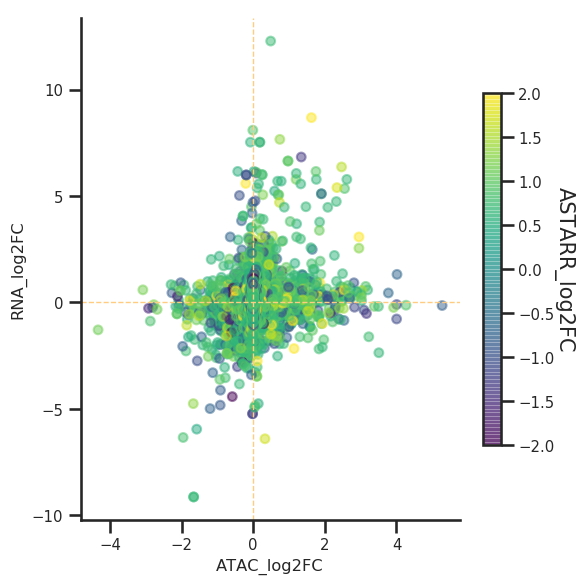

In [8]:
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import seaborn as sns
%matplotlib inline

sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
sns.set_context("talk", font_scale=0.65)
plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':100})

fig = plt.figure(figsize=(6,6))
ax = plt.subplot(1, 1, 1)

points = ax.scatter(
    Th1_atac_astarr_closest_DE_gene['ATAC_log2FC'], 
    Th1_atac_astarr_closest_DE_gene['RNA_log2FC'],
    c=Th1_atac_astarr_closest_DE_gene['ASTARR_log2FC'],
    cmap='viridis', marker='o', s=40, alpha=0.5)

cbar = fig.colorbar(points, shrink=0.7)
cbar.set_label('ASTARR_log2FC', rotation=270, fontsize=15, labelpad=15)
cbar.mappable.set_clim(-2,2)

plt.xlabel('ATAC_log2FC')
plt.ylabel('RNA_log2FC')

sns.despine(fig,ax)

#simpleaxis(ax)
plt.tight_layout()
plt.axhline(0, color='#ffcc80', linewidth = 1, linestyle = 'dashed')
plt.axvline(0, color='#ffcc80', linewidth = 1, linestyle = 'dashed')
plt.show()

### DPGP clustering for Th1 72hr DE genes across their average values of TPM for all timepoints

In [1]:
import pandas as pd
import glob
import re

tpm_files = {
'Th1.00hr':[
'/data/reddylab/Revathy/collabs/Keith/Th1/processing/rna_seq/210928_KS88_Th1Th2_RNAseq_TimeCourse-pe-stranded-with-sjdb/KS191_Th1_0hr_rep1.star2.rsem.genes.results',
'/data/reddylab/Revathy/collabs/Keith/Th1/processing/rna_seq/210928_KS88_Th1Th2_RNAseq_TimeCourse-pe-stranded-with-sjdb/KS191_Th1_0hr_rep2.star2.rsem.genes.results',
'/data/reddylab/Revathy/collabs/Keith/Th1/processing/rna_seq/210928_KS88_Th1Th2_RNAseq_TimeCourse-pe-stranded-with-sjdb/KS191_Th1_0hr_rep3.star2.rsem.genes.results'
],
'Th1.02hr':[
'/data/reddylab/Revathy/collabs/Keith/Th1/processing/rna_seq/210928_KS88_Th1Th2_RNAseq_TimeCourse-pe-stranded-with-sjdb/KS191_Th1_2hr_rep1.star2.rsem.genes.results',
'/data/reddylab/Revathy/collabs/Keith/Th1/processing/rna_seq/210928_KS88_Th1Th2_RNAseq_TimeCourse-pe-stranded-with-sjdb/KS191_Th1_2hr_rep2.star2.rsem.genes.results',
'/data/reddylab/Revathy/collabs/Keith/Th1/processing/rna_seq/210928_KS88_Th1Th2_RNAseq_TimeCourse-pe-stranded-with-sjdb/KS191_Th1_2hr_rep3.star2.rsem.genes.results'
],
'Th1.16hr':[
'/data/reddylab/Revathy/collabs/Keith/Th1/processing/rna_seq/210928_KS88_Th1Th2_RNAseq_TimeCourse-pe-stranded-with-sjdb/KS191_Th1_16hr_rep1.star2.rsem.genes.results',
'/data/reddylab/Revathy/collabs/Keith/Th1/processing/rna_seq/210928_KS88_Th1Th2_RNAseq_TimeCourse-pe-stranded-with-sjdb/KS191_Th1_16hr_rep2.star2.rsem.genes.results',
'/data/reddylab/Revathy/collabs/Keith/Th1/processing/rna_seq/210928_KS88_Th1Th2_RNAseq_TimeCourse-pe-stranded-with-sjdb/KS191_Th1_16hr_rep3.star2.rsem.genes.results'
],
'Th1.24hr':[
'/data/reddylab/Revathy/collabs/Keith/Th1/processing/rna_seq/210928_KS88_Th1Th2_RNAseq_TimeCourse-pe-stranded-with-sjdb/KS191_Th1_24hr_rep1.star2.rsem.genes.results',
'/data/reddylab/Revathy/collabs/Keith/Th1/processing/rna_seq/210928_KS88_Th1Th2_RNAseq_TimeCourse-pe-stranded-with-sjdb/KS191_Th1_24hr_rep2.star2.rsem.genes.results',
'/data/reddylab/Revathy/collabs/Keith/Th1/processing/rna_seq/210928_KS88_Th1Th2_RNAseq_TimeCourse-pe-stranded-with-sjdb/KS191_Th1_24hr_rep3.star2.rsem.genes.results'
],
'Th1.48hr':[
'/data/reddylab/Revathy/collabs/Keith/Th1/processing/rna_seq/210928_KS88_Th1Th2_RNAseq_TimeCourse-pe-stranded-with-sjdb/KS191_Th1_48hr_rep1.star2.rsem.genes.results',
'/data/reddylab/Revathy/collabs/Keith/Th1/processing/rna_seq/210928_KS88_Th1Th2_RNAseq_TimeCourse-pe-stranded-with-sjdb/KS191_Th1_48hr_rep2.star2.rsem.genes.results',
'/data/reddylab/Revathy/collabs/Keith/Th1/processing/rna_seq/210928_KS88_Th1Th2_RNAseq_TimeCourse-pe-stranded-with-sjdb/KS191_Th1_48hr_rep3.star2.rsem.genes.results'
],
'Th1.72hr':[
'/data/reddylab/Revathy/collabs/Keith/Th1/processing/rna_seq/210928_KS88_Th1Th2_RNAseq_TimeCourse-pe-stranded-with-sjdb/KS191_Th1_72hr-Sorted_rep1.star2.rsem.genes.results',
'/data/reddylab/Revathy/collabs/Keith/Th1/processing/rna_seq/210928_KS88_Th1Th2_RNAseq_TimeCourse-pe-stranded-with-sjdb/KS191_Th1_72hr-Sorted_rep2.star2.rsem.genes.results',
'/data/reddylab/Revathy/collabs/Keith/Th1/processing/rna_seq/210928_KS88_Th1Th2_RNAseq_TimeCourse-pe-stranded-with-sjdb/KS191_Th1_72hr-Sorted_rep3.star2.rsem.genes.results'
]
}

ref_gene = pd.read_csv('/data/reddylab/Reference_Data/Gencode/vM13/gencode.vM13.gene_id_to_gene_name.txt', sep='\t', names=['gene_id', 'gene', 'gene_type'])

def column_name(s):
    name = '.'.join(s.split('/')[-1].split('.')[:1])
    return name

avg_tpm_df=None
for tpm, files in tpm_files.items():
    df=None
    for file in files:
        df_tmp = pd.read_csv(file, sep='\t')
        df_tmp.columns = df_tmp.columns[:-2].tolist() + [column_name(file)] + df_tmp.columns[-1:].tolist()
        if df is None:
            df = df_tmp.loc[:, ['gene_id'] + [df_tmp.columns[-2]]]
        else:
            df = df.join(df_tmp.loc[:, df_tmp.columns[-2]], how='right')

    count_columns = ["rep" in c for c in df.columns]
    df.loc[:, count_columns] = df.loc[:, count_columns].astype(dtype='float')
    df['%s.Mean'%(tpm)] = df.iloc[:,1:4].mean(axis=1)
    df['%s.Mean'%(tpm)] = df['%s.Mean'%(tpm)].round(2)
    df = df[['gene_id','%s.Mean' % tpm]]
    if avg_tpm_df is None:
        avg_tpm_df = df
    else:
        avg_tpm_df = avg_tpm_df.merge(df, on='gene_id', how='outer')
    count_columns = ["rep" in c for c in avg_tpm_df.columns]
    avg_tpm_df.loc[:, count_columns] = avg_tpm_df.loc[:, count_columns].astype(dtype='float')
    
tpm_df_with_gene = avg_tpm_df.merge(ref_gene, on='gene_id', how='left') 
tpm_df_with_gene = tpm_df_with_gene[['gene','Th1.00hr.Mean','Th1.02hr.Mean','Th1.16hr.Mean','Th1.24hr.Mean','Th1.48hr.Mean','Th1.72hr.Mean']]
tpm_df_with_gene.to_csv('/data/reddylab/Revathy/collabs/Keith/Th1/data/rna_seq/tpm/Th1.tpm.mean.txt', sep='\t', index=False)
tpm_df_with_gene.head()

gene  Th1.00hr.Mean  Th1.02hr.Mean  Th1.16hr.Mean  Th1.24hr.Mean  \
0  Gnai3          34.53          54.79          27.70          23.51   
1   Pbsn           0.00           0.00           0.00           0.00   
2  Cdc45           0.94           0.52          23.84          32.89   
3    H19           0.24           0.00           0.00           0.00   
4  Scml2           0.27           0.00           0.46           1.24   

   Th1.48hr.Mean  Th1.72hr.Mean  
0          29.74          34.33  
1           0.00           0.00  
2          36.49          52.14  
3           0.00           2.97  
4           0.24           0.97

In [9]:
!wc -l /data/reddylab/Revathy/collabs/Keith/Th1/data/rna_seq/tpm/Th1.tpm.mean.txt

50601 /data/reddylab/Revathy/collabs/Keith/Th1/data/rna_seq/tpm/Th1.tpm.mean.txt


In [3]:
import pandas as pd
import numpy as np

Th1_tpm = pd.read_csv('/data/reddylab/Revathy/collabs/Keith/Th1/data/rna_seq/tpm/Th1.tpm.mean.txt', sep='\t')
Th1_tpm_72hr_genes = Th1_tpm[Th1_tpm.gene.isin(Th1_DE_genes)]
Th1_tpm_72hr_genes = Th1_tpm_72hr_genes[(Th1_tpm_72hr_genes.iloc[:,1:7]!=0).any(axis=1)]
Th1_tpm_72hr_genes.rename(columns={'Th1.00hr.Mean':'00',
                                    'Th1.02hr.Mean':'02',
                                    'Th1.16hr.Mean':'16',
                                    'Th1.24hr.Mean':'24',
                                    'Th1.48hr.Mean':'48',
                                    'Th1.72hr.Mean':'72'}, inplace=True)
Th1_tpm_72hr_genes.to_csv('/data/reddylab/Revathy/collabs/Keith/Th1/data/rna_seq/tpm/Th1_tpm_72hr_DE_genes.txt', sep='\t', index=False)

# len(Th1_tpm_72hr_genes[(Th1_tpm_72hr_genes == 0).sum(1)<3].gene.unique())
len(Th1_tpm_72hr_genes.gene.unique())

3664

In [11]:
Th1_tpm_72hr_genes[Th1_tpm_72hr_genes.gene=='Plac8']

gene   00   02   16   24   48    72
7233  Plac8  0.0  0.0  0.0  0.0  0.0  40.9

In [17]:
%%bash
source /data/reddylab/software/miniconda2/bin/activate alex
mkdir -p /data/reddylab/Revathy/collabs/Keith/Th1/data/rna_seq/DPGP
sbatch -p all \
    -o /data/reddylab/Revathy/collabs/Keith/Th1/logs/Th1_dp_gp_72hr_DE_genes_tpm.out \
    --cpus-per-task 1 \
    --mem 128G \
    <<'EOF'
#!/bin/sh
module load gcc
#SBATCH --cpus-per-task=1
#SBATCH --mem=64G
outfile="/data/reddylab/Revathy/collabs/Keith/Th1/data/rna_seq/DPGP/Th1_72hr_DEGs_TPM.alpha_0.001.log2fc_DP_GP"
infile="/data/reddylab/Revathy/collabs/Keith/Th1/data/rna_seq/tpm/Th1_tpm_72hr_DE_genes.txt"
#
DP_GP_cluster.py \
--alpha 0.001 \
--true_times \
-i ${infile}  \
-o ${outfile} \
-p png \
--plot
EOF

Submitted batch job 28588516


#### DPGP for TFs from Th1

In [24]:
import pandas as pd

Th1_tf = pd.read_csv('/data/reddylab/Revathy/collabs/Keith/Th1/data/rna_seq/tpm/220715_ExpressedTFs_Th1.txt', sep='\t')
tfs = list(Th1_tf.gene.unique())
expressed_tfs_tpm = Th1_tpm[Th1_tpm.gene.isin(tfs)]
expressed_tfs_tpm.rename(columns={'Th1.00hr.Mean':'00',
                                    'Th1.02hr.Mean':'02',
                                    'Th1.16hr.Mean':'16',
                                    'Th1.24hr.Mean':'24',
                                    'Th1.48hr.Mean':'48',
                                    'Th1.72hr.Mean':'72'}, inplace=True)
expressed_tfs_tpm.to_csv('/data/reddylab/Revathy/collabs/Keith/Th1/data/rna_seq/tpm/220715_ExpressedTFs_Th1_v1.txt', sep='\t', index=False)


/data/reddylab/software/miniconda3/envs/revathy_py3/lib/python3.5/site-packages/pandas/core/frame.py:3778: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [25]:
expressed_tfs_tpm

gene      00      02      16      24      48      72
8           Klf6   17.92   11.34    2.97    4.71   32.07   32.37
9          Scmh1    5.20    7.08    7.14    3.54    4.59   12.01
46        Trim25   17.90   13.24   18.58   10.41   26.36   23.12
49           Mnt   12.12   12.12    6.29    3.25    5.75    5.92
64        Dazap2   83.34   57.14   46.46   33.15   46.68   53.32
100       Hnrnpd  262.01  442.64  653.07  390.82  332.76  204.90
119        Kat2b   28.71    7.72    7.66    3.54    7.27    8.87
133       Polr3d   10.37   39.31   30.62   29.55   45.09   22.78
134         Tcf7  441.19   86.50  127.34   83.93   65.91   52.44
146         Fmr1   28.09   17.93   35.53   18.80   20.32   31.00
154      Smarcb1   20.69   15.09   36.97   34.18   33.14   65.71
169         Ilf2   37.08   49.03   79.20   69.30   99.88   79.70
186       Zfp276   14.51   11.83   40.06   62.17   27.03   23.47
207         Mxd1    4.12    7.24    0.56    3.18    0.71    2.63
225          Sp1   23.19   33.97   47.89   20.97   51.52   22.35
228         Rarg   19.06    3.64    4.68    2.89    4.73    5.26
246        Mef2d   52.31   94.16   20.46   15.49   31.30   21.45
248         Snd1   25.17   15.03   72.61   50.42   74.41   76.64
253        Tbx21    0.19    1.81    0.86    2.03   52.33   42.68
268        Foxm1    0.70    1.88    1.80   14.53   10.34   18.99
271        Tulp3    2.75    1.59    6.10    3.92    2.77    6.52
272       Gtf2h4   13.22    7.37   20.90   17.04   13.17   11.91
274         Ell2    0.82    5.68    0.58    1.72   16.11   15.53
287        Brpf1   25.60   27.39   16.57   14.61   21.95   10.01
315         Pwp1   15.51   38.22   57.72   45.90   96.09   39.09
316        Fbxo7   10.73   12.06   14.33    6.24    6.49    5.49
349        Npas1    5.37    3.14    8.17    8.02    3.06    3.06
382         Ddb2   57.05   27.47   15.99   18.58   19.94   27.45
385        Stat6   58.86  123.05   43.86   36.65   46.07   46.25
397        Ppard   11.82   29.87    8.80   11.68   11.02   11.95
...          ...     ...     ...     ...     ...     ...     ...
20066      Tbpl1   13.45   17.37   15.93   13.14   66.17   21.90
20127      Cebpd   15.23    4.91   20.62   29.77   11.33   17.28
20131       Mta2   73.66  107.99   66.72   69.07   91.13  102.27
20146     Polr2g   25.95    8.87   52.15   33.34   36.53   82.76
20172       Zhx2   16.45   64.77   10.19    9.72    6.56    3.54
20216      Taf1a   12.55   19.50   11.64    8.88    7.36    6.37
20333       Rybp    9.21   30.10   17.73   11.99    3.77    6.52
20339      Nfxl1    3.09    1.89    4.42    2.99    3.52    7.93
20777     Zfp382    5.20    8.35    2.60    3.18   18.84    8.55
21075      Nrbf2   13.11   17.62   10.77    8.96    7.02   10.97
21089  Hist1h2bb    1.20    2.27    0.43    5.26    2.06    0.00
21092     Zfp408    8.93    6.99    4.81    2.80    3.68    3.96
21261      Zbtb2   10.20    8.95    6.28    3.33    2.55    2.15
21521       Sox4    2.64    5.39    1.59    1.96    3.81    4.68
22525    Smarcd2   47.02   35.81   52.96   28.49   41.20   62.14
22550       Chd2  164.50  208.20   27.47   39.86   44.95   38.13
22589     Zfp566    6.50    9.02    4.74    3.65    2.77    2.72
22789   Mphosph8   63.97   49.57   52.79   43.05   59.68   34.86
22912      Med12   41.57   24.33   17.47   13.90   20.56   24.16
22925        Zfx    9.59   10.12   12.47    6.99    4.58    7.73
22975      Zbtb9    8.92   10.25    7.08    3.44    8.65    4.45
30695       Cbx6   11.48    2.67   14.07   17.30    9.99   13.51
30984      Shprh   11.60    4.81   10.07    4.96   23.88   11.36
31080     Churc1   53.49   16.75   30.59   23.41   23.47   26.04
32250      Med20    8.44   13.59   10.74   17.36   13.11   11.45
33933     Zfp131   20.25   38.67   21.11   15.53   22.60   22.49
35021       H1f0    8.24    1.06    4.85   13.91   50.47   70.55
36588      Zfp82    6.67    2.58    3.02    2.51    2.29    2.84
37556       Atf7   11.03   10.76    5.20    5.35    6.16    4.40
44934     Gtf3c2   28.43   41.81   56.51   34.5

In [26]:
%%bash
source /data/reddylab/software/miniconda2/bin/activate alex
mkdir -p /data/reddylab/Revathy/collabs/Keith/Th1/data/rna_seq/DPGP
sbatch -p all \
    -o /data/reddylab/Revathy/collabs/Keith/Th1/logs/Th1_dp_gp_TFs_tpm.out \
    --cpus-per-task 1 \
    --mem 128G \
    <<'EOF'
#!/bin/sh
module load gcc
#SBATCH --cpus-per-task=1
#SBATCH --mem=64G
outfile="/data/reddylab/Revathy/collabs/Keith/Th1/data/rna_seq/DPGP/Th1_TFs_TPM.alpha_0.001.log2fc_DP_GP"
infile="/data/reddylab/Revathy/collabs/Keith/Th1/data/rna_seq/tpm/220715_ExpressedTFs_Th1_v1.txt"
#
DP_GP_cluster.py \
--alpha 0.001 \
--true_times \
-i ${infile}  \
-o ${outfile} \
-p png \
--plot
EOF

Submitted batch job 28670961


In [10]:
!wc -l /data/reddylab/Revathy/collabs/Keith/Th1/data/rna_seq/tpm/220715_ExpressedTFs_Th1_v1.txt

950 /data/reddylab/Revathy/collabs/Keith/Th1/data/rna_seq/tpm/220715_ExpressedTFs_Th1_v1.txt


In [12]:
import pandas as pd

clusters = pd.read_csv('/data/reddylab/Revathy/collabs/Keith/Th1/data/rna_seq/DPGP/Th1_72hr_DEGs_TPM.alpha_0.001.log2fc_DP_GP_optimal_clustering.txt', sep='\t')
clusters = clusters.rename(columns={'gene':'GeneName'})

Th1_atac_closest_DE_gene_subset_clusters = Th1_atac_closest_DE_gene_subset.merge(clusters, on='GeneName', how='left')
Th1_atac_closest_DE_gene_subset_clusters['cluster'] = Th1_atac_closest_DE_gene_subset_clusters['cluster'].fillna(0)
Th1_atac_closest_DE_gene_subset_clusters['cell_type'] = 'Th1'
Th1_atac_closest_DE_gene_subset_clusters['RNA_tpm'] = Th1_atac_closest_DE_gene_subset_clusters['RNA_tpm'].astype(float)
Th1_atac_closest_DE_gene_subset_clusters.to_csv('/data/reddylab/Revathy/collabs/Keith/Th1/data/integration/Th1_atac_rna_promoters_with_clusters.txt', sep='\t', index=False)
Th1_atac_closest_DE_gene_subset_clusters[Th1_atac_closest_DE_gene_subset_clusters['cluster']==0]


chr_start_end GeneName  ATAC_log2FC     ATAC_padj  \
18       chr6_37063030_37063926     Dgki    -3.615578  4.529538e-33   
19       chr6_37297912_37298472     Dgki    -1.443185  2.581970e-04   
329     chr14_57103457_57105054     Gjb2    -1.329460  4.476110e-17   
788   chr10_107271844_107273134    Lin7a    -2.352187  1.710189e-09   
789   chr10_107274001_107274286    Lin7a          NaN           NaN   
862    chr8_104846542_104847319    Ces2c    -2.803396  4.559935e-20   
902      chr8_68276123_68277757   Sh2d4a    -1.564769  1.683674e-19   
1054     chr2_25697076_25698828    Obp2a    -1.074280  6.520829e-17   
1720    chr16_26104891_26106343     P3h2    -1.582992  7.902784e-10   
2007    chr11_80809882_80811014   Tmem98    -2.007177  6.180394e-08   
2380     chr8_94748300_94748697    Ccl22          NaN           NaN   
4859       chr6_3763381_3763791    Calcr          NaN           NaN   
4879     chr9_78614290_78614561    Cd109          NaN           NaN   

      RNA_log2FC      RNA_padj  RNA_tpm  distance        GeneType  cluster  \
18     -5.169070  1.786252e-23      0.0       584  protein_coding      0.0   
19     -5.169070  1.786252e-23      0.0      1165  protein_coding      0.0   
329    -4.851150  2.596704e-08      0.0         0  protein_coding      0.0   
788    -4.988032  8.378687e-26      0.0         0  protein_coding      0.0   
789    -4.988032  8.378687e-26      0.0     -1607  protein_coding      0.0   
862    -6.510820  3.644928e-06      0.0         0  protein_coding      0.0   
902    -5.147721  1.380428e-18      0.0         0  protein_coding      0.0   
1054   -1.709592  1.240166e-03      0.0      1216  protein_coding      0.0   
1720   -4.608119  4.528433e-16      0.0         0  protein_coding      0.0   
2007   -6.171634  3.222617e-10      0.0         0  protein_coding      0.0   
2380   -4.915535  1.808000e-18      0.0     -2620  protein_coding      0.0   
4859   -6.252925  3.777330e-31      0.0         0  protein_coding      0.0   
4879   -4.119123  4.192233e-11      0.0       986  protein_coding      0.0   

     cell_type  
18         Th1  
19         Th1  
329        Th1  
788        Th1  
789        Th1  
862        Th1  
902        Th1  
1054       Th1  
1720       Th1  
2007       Th1  
2380       Th1  
4859       Th1  
4879       Th1

In [13]:
Th1_atac_closest_DE_gene_subset_clusters.describe()

ATAC_log2FC      ATAC_padj   RNA_log2FC      RNA_padj       RNA_tpm  \
count  4596.000000   4.596000e+03  4881.000000  4.881000e+03   4881.000000   
mean      0.027056   2.892697e-01    -0.031862  5.372660e-03    179.780815   
std       0.705771   3.251588e-01     1.511516  1.096891e-02   1102.019245   
min      -3.973390  6.957290e-135    -8.296807  0.000000e+00      0.000000   
25%      -0.171063   1.754433e-03    -0.728779  3.222617e-10      7.990000   
50%      -0.004955   1.362609e-01    -0.300168  3.456363e-05     28.200000   
75%       0.148153   5.528866e-01     0.611979  3.893940e-03     85.020000   
max       5.484450   9.992853e-01    12.278528  4.993083e-02  46771.380000   

          distance      cluster  
count  4881.000000  4881.000000  
mean     16.702930     7.234583  
std    1124.276875     3.864678  
min   -2998.000000     0.000000  
25%       0.000000     4.000000  
50%       0.000000     7.000000  
75%       0.000000    10.000000  
max    2999.000000    14.000000

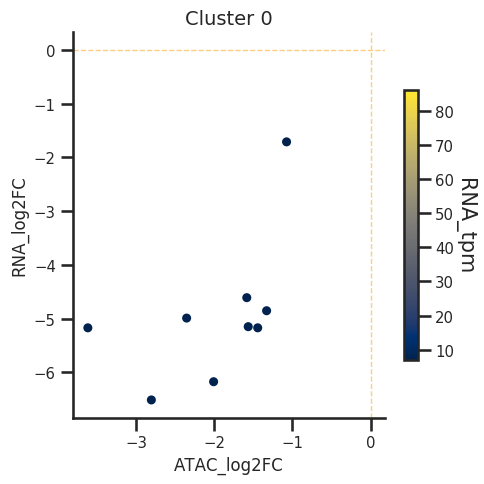

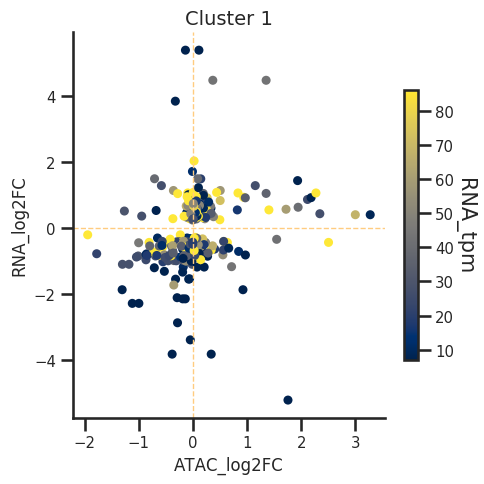

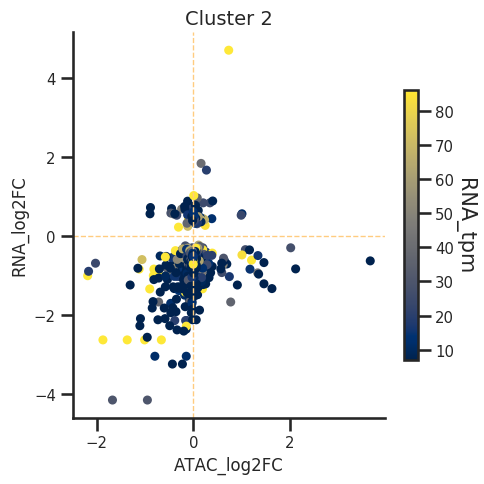

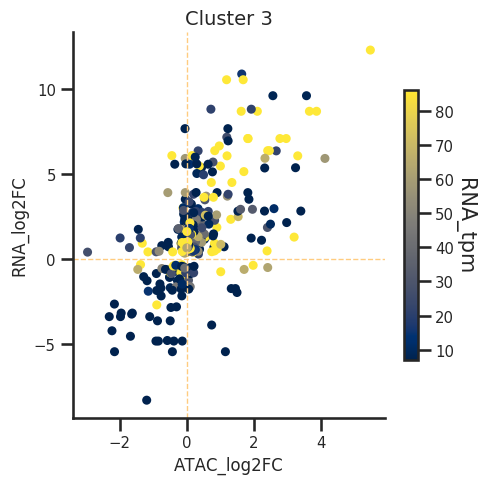

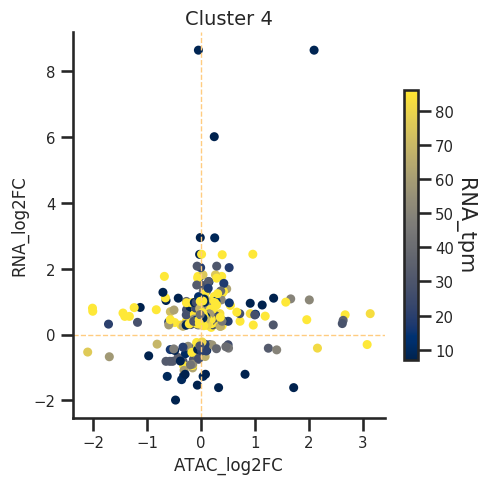

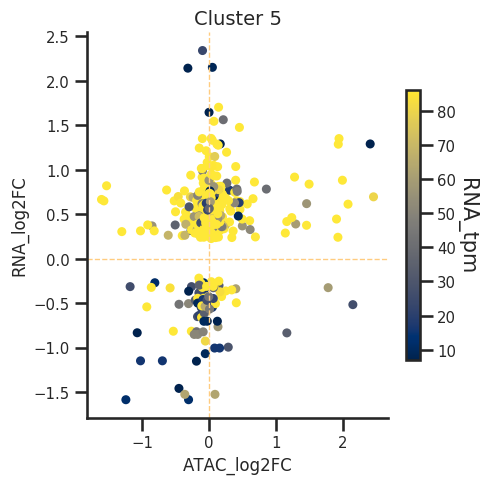

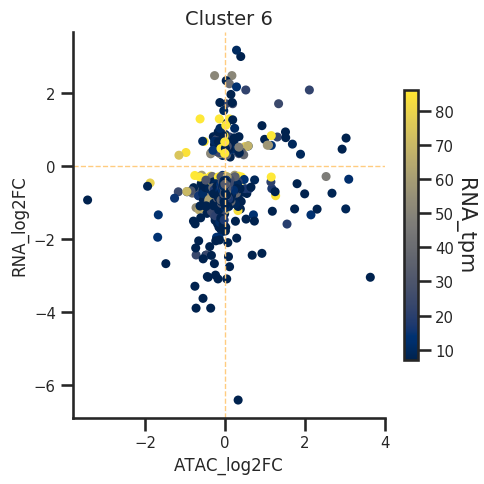

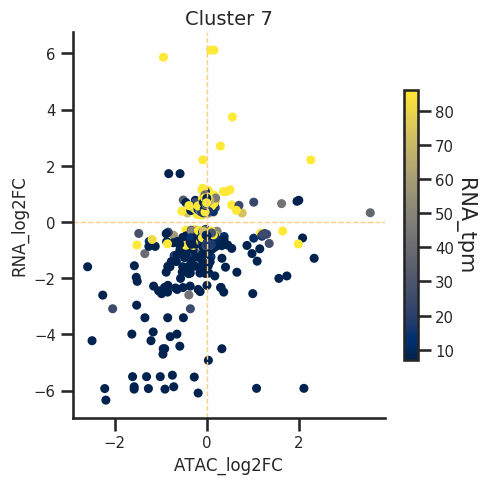

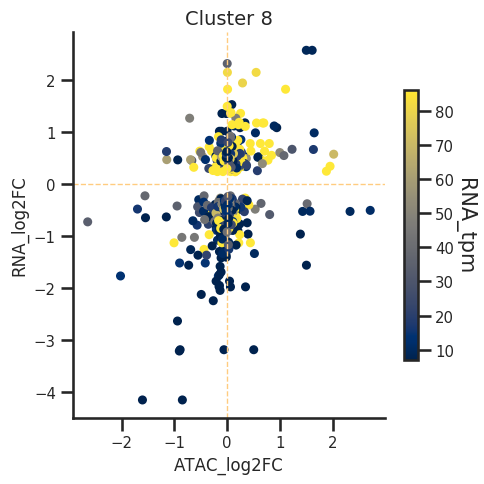

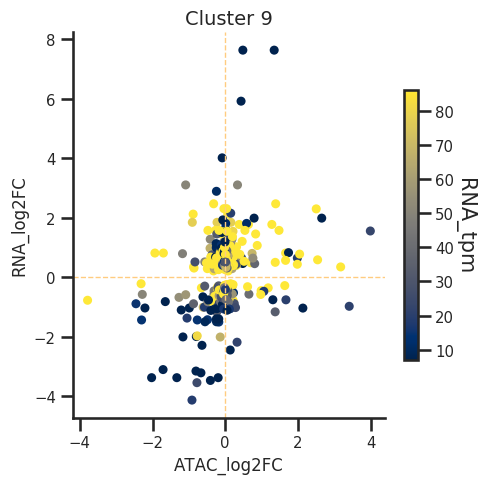

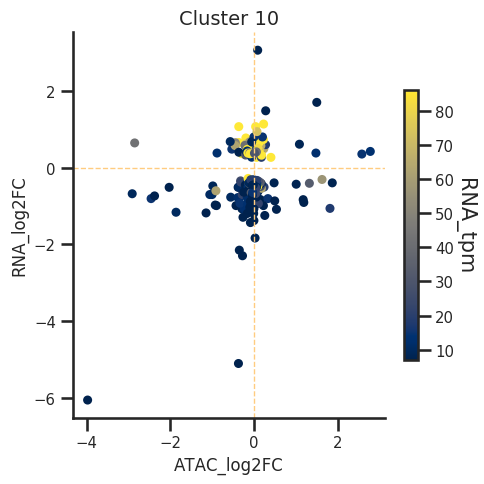

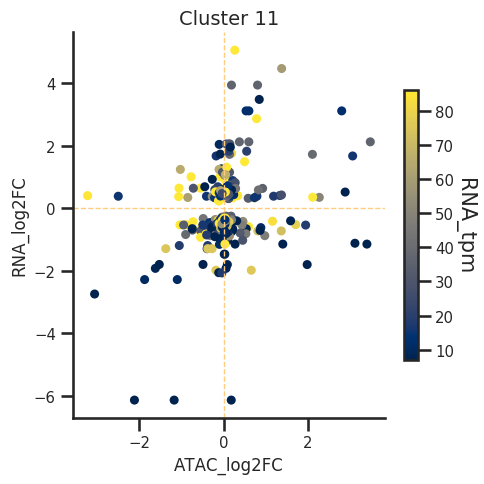

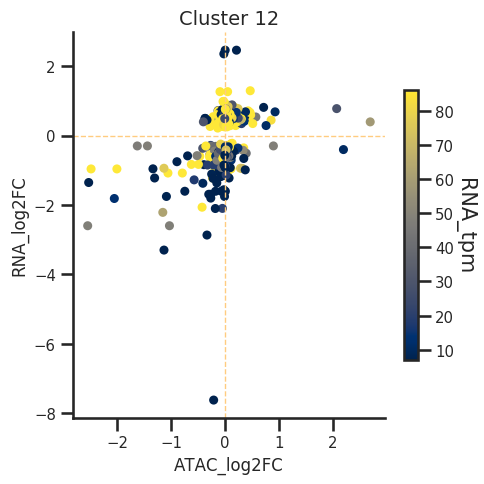

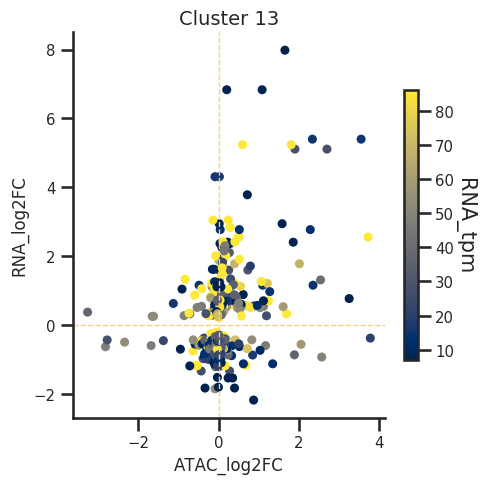

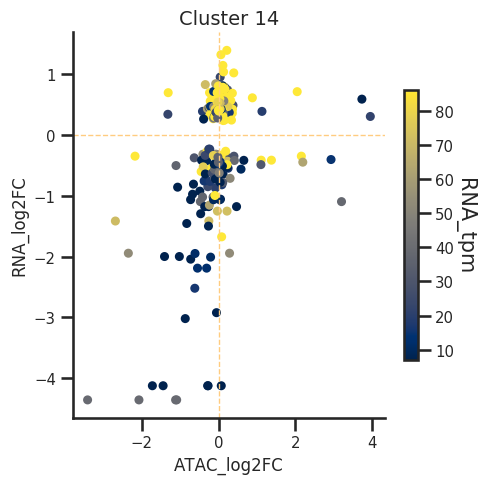

In [14]:
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import seaborn as sns
%matplotlib inline

sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
sns.set_context("talk", font_scale=0.65)
plt.rcParams.update({'figure.figsize':(5,5), 'figure.dpi':100})


for idx, gp in Th1_atac_closest_DE_gene_subset_clusters.groupby('cluster'):
    fig, ax = plt.subplots(figsize=(5,5))
    points = ax.scatter(x=gp['ATAC_log2FC'], y=gp['RNA_log2FC'],
               c=gp['RNA_tpm'], cmap='cividis',marker='o', s=25)
    cbar = fig.colorbar(points, shrink=0.7)
    cbar.set_label('RNA_tpm', rotation=270, fontsize=15, labelpad=15)
    cbar.mappable.set_clim(7,86)
    
    ax.grid()
    ax.set_ylabel('RNA_log2FC', fontsize=12)
    ax.set_xlabel('ATAC_log2FC', fontsize=12)
    ax.set_title('Cluster %d'%idx, fontsize=14)
    sns.despine(fig,ax)
    plt.tight_layout()
    plt.axhline(0, color='#ffcc80', linewidth = 1, linestyle = 'dashed')
    plt.axvline(0, color='#ffcc80', linewidth = 1, linestyle = 'dashed')
    plt.grid(False)
    plt.show()

    

## Th2

In [82]:
import pandas as pd
import glob
import re

files = [
'/data/reddylab/Revathy/collabs/Keith/Th1/processing/rna_seq/210928_KS88_Th1Th2_RNAseq_TimeCourse-pe-stranded-with-sjdb/KS88_Th2_72hr-Sort_rep1.star2.rsem.isoforms.results',
'/data/reddylab/Revathy/collabs/Keith/Th1/processing/rna_seq/210928_KS88_Th1Th2_RNAseq_TimeCourse-pe-stranded-with-sjdb/KS88_Th2_72hr-Sort_rep2.star2.rsem.isoforms.results',
'/data/reddylab/Revathy/collabs/Keith/Th1/processing/rna_seq/210928_KS88_Th1Th2_RNAseq_TimeCourse-pe-stranded-with-sjdb/KS88_Th2_72hr-Sort_rep3.star2.rsem.isoforms.results',
'/data/reddylab/Revathy/collabs/Keith/Th1/processing/rna_seq/210928_KS88_Th1Th2_RNAseq_TimeCourse-pe-stranded-with-sjdb/KS88_Th2_72hr-Sort_rep4.star2.rsem.isoforms.results'
]

def column_name(s):
    name = '.'.join(s.split('/')[-1].split('.')[:1])
    return name

df=None
for file in files:
    df_tmp = pd.read_csv(file, sep='\t')
    df_tmp.columns = df_tmp.columns[:-3].tolist() + [column_name(file)] + df_tmp.columns[-2:].tolist()
    if df is None:
        df = df_tmp.loc[:,['transcript_id','gene_id','length','expected_count'] + [df_tmp.columns[-3]]]
    else:
        df = df.join(df_tmp.loc[:, df_tmp.columns[-3]], how='right')

count_columns = ["rep" in c for c in df.columns]
df.loc[:, count_columns] = df.loc[:, count_columns].astype(dtype='float')
df['Th2.72hr.Sorted.Sum'] = df.iloc[:,4:8].sum(axis=1)
df['Th2.72hr.Sorted.Sum'] = df['Th2.72hr.Sorted.Sum'].round(2)
df['gene_id'] = df['gene_id'].str.split('.').str[0]
df['transcript_id'] = df['transcript_id'].str.split('.').str[0]
idx = df.groupby(['gene_id'])['Th2.72hr.Sorted.Sum'].transform(max)==df['Th2.72hr.Sorted.Sum']
df_subset = df[idx]
df_subset.head()


transcript_id             gene_id  length  expected_count  \
0  ENSMUST00000000001  ENSMUSG00000000001    3262           18.00   
1  ENSMUST00000000003  ENSMUSG00000000003     902            0.00   
2  ENSMUST00000114041  ENSMUSG00000000003     697            0.00   
4  ENSMUST00000096990  ENSMUSG00000000028    1747           24.86   
9  ENSMUST00000149974  ENSMUSG00000000031     935            0.00   

   KS88_Th2_72hr-Sort_rep1  KS88_Th2_72hr-Sort_rep2  KS88_Th2_72hr-Sort_rep3  \
0                     4.29                     2.99                     1.57   
1                     0.00                     0.00                     0.00   
2                     0.00                     0.00                     0.00   
4                    11.53                     2.44                    10.39   
9                     0.00                     0.00                     3.73   

   KS88_Th2_72hr-Sort_rep4  Th2.72hr.Sorted.Sum  
0                    13.40                22.25  
1                     0.00                 0.00  
2                     0.00                 0.00  
4                     8.47                32.83  
9                     0.00                 3.73

In [83]:
import pandas as pd

transcript_annot = pd.read_csv('/data/reddylab/Revathy/collabs/Keith/data/annotation_files/gencode.vM19.annotation.transcript_TSS.txt', sep='\t')

df_annotated = df_subset.merge(transcript_annot, on=['transcript_id'], how='inner')
df_annotated = df_annotated[['chr','TSS_start','TSS_end','gene_id_x','transcript_id','GeneType','GeneName','strand','Th2.72hr.Sorted.Sum']].dropna()
df_annotated.TSS_start = df_annotated.TSS_start.astype(int)
df_annotated.TSS_end = df_annotated.TSS_end.astype(int)
df_annotated.rename(columns={'gene_id_x':'gene_id'}, inplace=True)
df_annotated[['chr','TSS_start','TSS_end','gene_id','transcript_id','strand','GeneName','GeneType','Th2.72hr.Sorted.Sum']].to_csv('/data/reddylab/Revathy/collabs/Keith/Th2/data/rna_seq/tpm/Th2_gencode.vM19.annotation.expressed_transcript_TSS.bed', sep='\t', index=False, header=None)
transcript_not_expressed_72 = list(df_annotated['transcript_id'][df_annotated['Th2.72hr.Sorted.Sum']==0].unique())
len(transcript_not_expressed_72)

56765

In [84]:
import pandas as pd
import glob
import re

isoform_files = {
'Th2.00hr':[
'/data/reddylab/Revathy/collabs/Keith/Th1/processing/rna_seq/210928_KS88_Th1Th2_RNAseq_TimeCourse-pe-stranded-with-sjdb/KS88_Th2_0hr_rep1.star2.rsem.isoforms.results',
'/data/reddylab/Revathy/collabs/Keith/Th1/processing/rna_seq/210928_KS88_Th1Th2_RNAseq_TimeCourse-pe-stranded-with-sjdb/KS88_Th2_0hr_rep2.star2.rsem.isoforms.results',
'/data/reddylab/Revathy/collabs/Keith/Th1/processing/rna_seq/210928_KS88_Th1Th2_RNAseq_TimeCourse-pe-stranded-with-sjdb/KS88_Th2_0hr_rep3.star2.rsem.isoforms.results',
'/data/reddylab/Revathy/collabs/Keith/Th1/processing/rna_seq/210928_KS88_Th1Th2_RNAseq_TimeCourse-pe-stranded-with-sjdb/KS88_Th2_0hr_rep4.star2.rsem.isoforms.results'
],
'Th2.02hr':[
'/data/reddylab/Revathy/collabs/Keith/Th1/processing/rna_seq/210928_KS88_Th1Th2_RNAseq_TimeCourse-pe-stranded-with-sjdb/KS88_Th2_2hr_rep1.star2.rsem.isoforms.results',
'/data/reddylab/Revathy/collabs/Keith/Th1/processing/rna_seq/210928_KS88_Th1Th2_RNAseq_TimeCourse-pe-stranded-with-sjdb/KS88_Th2_2hr_rep2.star2.rsem.isoforms.results',
'/data/reddylab/Revathy/collabs/Keith/Th1/processing/rna_seq/210928_KS88_Th1Th2_RNAseq_TimeCourse-pe-stranded-with-sjdb/KS88_Th2_2hr_rep3.star2.rsem.isoforms.results',
'/data/reddylab/Revathy/collabs/Keith/Th1/processing/rna_seq/210928_KS88_Th1Th2_RNAseq_TimeCourse-pe-stranded-with-sjdb/KS88_Th2_2hr_rep4.star2.rsem.isoforms.results'
],
'Th2.16hr':[
'/data/reddylab/Revathy/collabs/Keith/Th1/processing/rna_seq/210928_KS88_Th1Th2_RNAseq_TimeCourse-pe-stranded-with-sjdb/KS88_Th2_16hr_rep1.star2.rsem.isoforms.results',
'/data/reddylab/Revathy/collabs/Keith/Th1/processing/rna_seq/210928_KS88_Th1Th2_RNAseq_TimeCourse-pe-stranded-with-sjdb/KS88_Th2_16hr_rep2.star2.rsem.isoforms.results',
'/data/reddylab/Revathy/collabs/Keith/Th1/processing/rna_seq/210928_KS88_Th1Th2_RNAseq_TimeCourse-pe-stranded-with-sjdb/KS88_Th2_16hr_rep3.star2.rsem.isoforms.results',
'/data/reddylab/Revathy/collabs/Keith/Th1/processing/rna_seq/210928_KS88_Th1Th2_RNAseq_TimeCourse-pe-stranded-with-sjdb/KS88_Th2_16hr_rep4.star2.rsem.isoforms.results'
],
'Th2.24hr':[
'/data/reddylab/Revathy/collabs/Keith/Th1/processing/rna_seq/210928_KS88_Th1Th2_RNAseq_TimeCourse-pe-stranded-with-sjdb/KS88_Th2_24hr_rep1.star2.rsem.isoforms.results',
'/data/reddylab/Revathy/collabs/Keith/Th1/processing/rna_seq/210928_KS88_Th1Th2_RNAseq_TimeCourse-pe-stranded-with-sjdb/KS88_Th2_24hr_rep2.star2.rsem.isoforms.results',
'/data/reddylab/Revathy/collabs/Keith/Th1/processing/rna_seq/210928_KS88_Th1Th2_RNAseq_TimeCourse-pe-stranded-with-sjdb/KS88_Th2_24hr_rep3.star2.rsem.isoforms.results',
'/data/reddylab/Revathy/collabs/Keith/Th1/processing/rna_seq/210928_KS88_Th1Th2_RNAseq_TimeCourse-pe-stranded-with-sjdb/KS88_Th2_24hr_rep4.star2.rsem.isoforms.results'
],
'Th2.48hr':[
'/data/reddylab/Revathy/collabs/Keith/Th1/processing/rna_seq/210928_KS88_Th1Th2_RNAseq_TimeCourse-pe-stranded-with-sjdb/KS88_Th2_48hr_rep1.star2.rsem.isoforms.results',
'/data/reddylab/Revathy/collabs/Keith/Th1/processing/rna_seq/210928_KS88_Th1Th2_RNAseq_TimeCourse-pe-stranded-with-sjdb/KS88_Th2_48hr_rep2.star2.rsem.isoforms.results',
'/data/reddylab/Revathy/collabs/Keith/Th1/processing/rna_seq/210928_KS88_Th1Th2_RNAseq_TimeCourse-pe-stranded-with-sjdb/KS88_Th2_48hr_rep3.star2.rsem.isoforms.results',
'/data/reddylab/Revathy/collabs/Keith/Th1/processing/rna_seq/210928_KS88_Th1Th2_RNAseq_TimeCourse-pe-stranded-with-sjdb/KS88_Th2_48hr_rep4.star2.rsem.isoforms.results'
]
}

def column_name(s):
    name = '.'.join(s.split('/')[-1].split('.')[:3])
    return name

tpm_df=None
for isoform, files in isoform_files.items():
    df=None
    for file in files:
        df_tmp = pd.read_csv(file, sep='\t')
        df_tmp.columns = df_tmp.columns[:-3].tolist() + [column_name(file)] + df_tmp.columns[-2:].tolist()
        if df is None:
            df = df_tmp.loc[:,['transcript_id','gene_id','length','expected_count'] + [df_tmp.columns[-3]]]
        else:
            df = df.join(df_tmp.loc[:, df_tmp.columns[-3]], how='right')

    count_columns = ["rep" in c for c in df.columns]
    df.loc[:, count_columns] = df.loc[:, count_columns].astype(dtype='float')
    df['%s.Sum'%(isoform)] = df.iloc[:,4:8].sum(axis=1)
    df['%s.Sum'%(isoform)] = df['%s.Sum'%(isoform)].round(2)
    df = df[['gene_id','transcript_id','%s.Sum' % isoform]]
    df['gene_id'] = df['gene_id'].str.split('.').str[0]
    df['transcript_id'] = df['transcript_id'].str.split('.').str[0]
    if tpm_df is None:
        tpm_df = df
    else:
        tpm_df = tpm_df.merge(df, on=['gene_id','transcript_id'], how='outer')
    count_columns = ["Sum" in c for c in tpm_df.columns]
    tpm_df.loc[:, count_columns] = tpm_df.loc[:, count_columns].astype(dtype='float')

tpm_df['max'] = tpm_df[['Th2.00hr.Sum','Th2.02hr.Sum','Th2.16hr.Sum','Th2.24hr.Sum','Th2.48hr.Sum']].max(axis=1)
idx = tpm_df.groupby(['gene_id'])['max'].transform(max)==tpm_df['max']
tpm_df_subset = tpm_df[idx]
tpm_df_annotated = tpm_df_subset.merge(transcript_annot, on=['transcript_id'], how='left')
tpm_df_annotated_not_72 = tpm_df_annotated[tpm_df_annotated.transcript_id.isin(transcript_not_expressed_72)]
tpm_df_annotated_not_72 = tpm_df_annotated_not_72[['chr','TSS_start','TSS_end','gene_id_x','transcript_id','strand','GeneName','GeneType','max']]
tpm_df_annotated_not_72.rename(columns={'max':'tpm', 'gene_id_x':'gene_id'}, inplace=True)
tpm_df_annotated_not_72['cell_type']='Th2'
tpm_df_annotated_not_72.to_csv('/data/reddylab/Revathy/collabs/Keith/Th2/data/rna_seq/tpm/Th2_transcript_genes_not_72.txt', sep='\t', index=False)


In [85]:
tpm_df_annotated_not_72

chr    TSS_start      TSS_end             gene_id  \
1       chrX   77853622.0   77853623.0  ENSMUSG00000000003   
2       chrX   77853529.0   77853530.0  ENSMUSG00000000003   
6      chr11  108343354.0  108343355.0  ENSMUSG00000000049   
8       chr6   17281185.0   17281186.0  ENSMUSG00000000058   
12     chr11   85832551.0   85832552.0  ENSMUSG00000000093   
13     chr11   85890063.0   85890064.0  ENSMUSG00000000094   
14     chr11   85896765.0   85896766.0  ENSMUSG00000000094   
15     chr11   85886422.0   85886423.0  ENSMUSG00000000094   
16      chrY    2170408.0    2170409.0  ENSMUSG00000000103   
17      chrY    2150345.0    2150346.0  ENSMUSG00000000103   
18     chr11   95587734.0   95587735.0  ENSMUSG00000000120   
19     chr11  103774150.0  103774151.0  ENSMUSG00000000125   
20     chr11   59306928.0   59306929.0  ENSMUSG00000000126   
21     chr11   59306930.0   59306931.0  ENSMUSG00000000126   
22     chr17   63937972.0   63937973.0  ENSMUSG00000000127   
28      chr7  143473736.0  143473737.0  ENSMUSG00000000154   
29      chr7  143475101.0  143475102.0  ENSMUSG00000000154   
30      chr7  143473805.0  143473806.0  ENSMUSG00000000154   
31      chr7  143473780.0  143473781.0  ENSMUSG00000000154   
32      chr7  143473768.0  143473769.0  ENSMUSG00000000154   
33     chr16   96443618.0   96443619.0  ENSMUSG00000000157   
34     chr16   96443611.0   96443612.0  ENSMUSG00000000157   
35     chr16   96443613.0   96443614.0  ENSMUSG00000000157   
36     chr16   96429143.0   96429144.0  ENSMUSG00000000157   
37     chr16   96361794.0   96361795.0  ENSMUSG00000000159   
38     chr16   96361794.0   96361795.0  ENSMUSG00000000159   
39     chr16   96361668.0   96361669.0  ENSMUSG00000000159   
40     chr16   96361794.0   96361795.0  ENSMUSG00000000159   
41     chr16   96396406.0   96396407.0  ENSMUSG00000000159   
42     chr16   96386331.0   96386332.0  ENSMUSG00000000159   
...      ...          ...          ...                 ...   
66901  chr10  105516648.0  105516649.0  ENSMUSG00000112900   
66902  chr10   62669803.0   62669804.0  ENSMUSG00000112901   
66903  chr10   99237615.0   99237616.0  ENSMUSG00000112902   
66904  chr10   16768940.0   16768941.0  ENSMUSG00000112903   
66905  chr12   43306143.0   43306144.0  ENSMUSG00000112904   
66906  chr10  108956487.0  108956488.0  ENSMUSG00000112905   
66907  chr10   31973668.0   31973669.0  ENSMUSG00000112906   
66909  chr12   47812905.0   47812906.0  ENSMUSG00000112908   
66911  chr10  107946645.0  107946646.0  ENSMUSG00000112910   
66912  chr12   57662910.0   57662911.0  ENSMUSG00000112911   
66913  chr10   77681086.0   77681087.0  ENSMUSG00000112912   
66914  chr10   65908238.0   65908239.0  ENSMUSG00000112913   
66915  chr10   65908249.0   65908250.0  ENSMUSG00000112913   
66916  chr10   32639485.0   32639486.0  ENSMUSG00000112914   
66917  chr12   46273883.0   46273884.0  ENSMUSG00000112915   
66919  chr10   47941841.0   47941842.0  ENSMUSG00000112917   
66920  chr10   50758184.0   50758185.0  ENSMUSG00000112918   
66921  chr10  118354104.0  118354105.0  ENSMUSG00000112919   
66922  chr11   73329741.0   73329742.0  ENSMUSG00000112920   
66923  chr10  114095727.0  114095728.0  ENSMUSG00000112921   
66924  chr10   82157101.0   82157102.0  ENSMUSG00000112922   
66925  chr10  103429910.0  103429911.0  ENSMUSG00000112923   
66926  chr10  116729253.0  116729254.0  ENSMUSG00000112924   
66928  chr12   51134701.0   51134702.0  ENSMUSG00000112926   
66929  chr10   50696472.0   50696473.0  ENSMUSG00000112927   
66930  chr10   15300397.0   15300398.0  ENSMUSG00000112928   
66931  chr10   15300231.0   15300232.0  ENSMUSG00000112928   
66932  chr10   16584268.0   16584269.0  ENSMUSG00000112929   
66933  chr15   60742858.0   60742859.0  ENSMUSG00000112930   
66934  chr10  100345972.0  100345973.0  ENSMUSG00000112931   

            transcript_id strand       GeneName  \
1      ENSMUST00000000003      -           Pbsn   
2      ENSMUST00000114041      -           Pbsn   
6      ENSM

In [82]:
%%bash 
sort -k1,1 -k2,2n /data/reddylab/Revathy/collabs/Keith/Th2/data/rna_seq/tpm/Th2_gencode.vM19.annotation.expressed_transcript_TSS.bed \
> /data/reddylab/Revathy/collabs/Keith/Th2/data/rna_seq/tpm/Th2_gencode.vM19.annotation.expressed_transcript_TSS.sorted.bed

In [18]:
%%bash
sbatch -p all \
    --cpus-per-task 1 \
    --mem 8G \
    -o /data/reddylab/Revathy/collabs/Keith/data/integrative/logs/Th2_all_ATAC_closest_genes.out \
    <<'EOF'
#!/bin/bash
SAMPLE="/data/reddylab/Revathy/collabs/Keith/Th2/data/atac_seq/featureCounts/Th0_Th2.72hrs.UnionPeakSet.featurecounts.df.txt"

tail -n+2 ${SAMPLE} \
| cut -f1 \
| awk -F_ -vOFS="\t" '{print $1, $2, $3, $1"_"$2"_"$3}' \
| sort -k1,1 -k2,2n \
| bedtools closest \
    -nonamecheck \
    -D a \
    -a - \
    -b /data/reddylab/Revathy/collabs/Keith/Th2/data/rna_seq/tpm/Th2_gencode.vM19.annotation.expressed_transcript_TSS.sorted.bed \
| awk -vOFS="\t" \
    '{if(last==$4){genes=$10","genes;}else{if(genes){print peak, genes, tpm, distance}peak=$4; genes=$10; tpm=$12; distance=$13; last=peak}}END{if(last==$4){genes=$10","genes;print peak, genes, tpm, distance}}' \
> ${SAMPLE/.featurecounts.df.txt/.closest_gene.txt}

EOF

Submitted batch job 28588517


#### Intersect CSAW ASTARR peak with ATAC_closest genes in Th2

In [12]:
%%bash
tail -n+2 //data/reddylab/Revathy/collabs/Keith/Th2/data/atac_seq/featureCounts/Th0_Th2.72hrs.UnionPeakSet.featurecounts.df.txt \
| cut -f1 \
| awk -F_ -vOFS="\t" '{print $1, $2, $3, $1"_"$2"_"$3}' \
| bedtools intersect -wa -wb \
-a - \
-b /data/reddylab/Revathy/collabs/Keith/ENCODE_submission/data/csaw_peaks/Th2.atacSTARR.pooled.3window_minTest.weighted.csaw.mm10.noATACpeaks.0bp_min.0.01.corrected.bed \
| cut -f4- \
> /data/reddylab/Revathy/collabs/Keith/Th2/data/integration/Th2_ATAC_closest_gene_ASTARR_intersect.bed

***** WARNING: File - has inconsistent naming convention for record:
GL456216.1	13778	13946	GL456216.1_13778_13946

***** WARNING: File - has inconsistent naming convention for record:
GL456216.1	13778	13946	GL456216.1_13778_13946



In [15]:
!wc -l /data/reddylab/Revathy/collabs/Keith/Th2/data/integration/Th2_ATAC_closest_gene_ASTARR_intersect.bed

16044 /data/reddylab/Revathy/collabs/Keith/Th2/data/integration/Th2_ATAC_closest_gene_ASTARR_intersect.bed


In [17]:
import pandas as pd
import numpy as np


closest_gene = pd.read_csv('/data/reddylab/Revathy/collabs/Keith/Th2/data/atac_seq/deseq/Th2.96hrs.ASTARR.insert_vs_Th0.72hrs.ASTARR.insert.closest_gene.txt', sep='\t', 
                                names=['chr_start_end','GeneName','RNA_tpm','distance'])
Th2_atac = pd.read_csv('/data/reddylab/Revathy/collabs/Keith/Th2/data/atac_seq/deseq/Th2.96hrs.ASTARR.insert_vs_Th0.72hrs.ASTARR.insert.txt', sep='\t')
Th2_rna = pd.read_csv('/data/reddylab/Revathy/collabs/Keith/Th1/data/rna_seq/deseq/Th2.Sorted.72hr_vs_mmTh0.Sorted.72hr.with_genes.txt', sep='\t')
Th2_astarr = pd.read_csv('/data/reddylab/Revathy/collabs/Keith/Th2/data/integration/Th2_ATAC_closest_gene_ASTARR_intersect.bed', sep='\t',
                                  names=['chr_start_end','ASTARR_chr','ASTARR_start','ASTARR_end','name','score','strand','ASTARR_log2FC','ASTARR_padj','qval','number'])

Th2_atac.reset_index(inplace=True)
Th2_atac_closest_DE_gene = Th2_atac.merge(closest_gene, left_on='index', right_on='chr_start_end', how='left').merge(Th2_rna, on='GeneName', how='outer')
Th2_atac_astarr_closest_DE_gene = Th2_atac_closest_DE_gene.merge(Th2_astarr, on='chr_start_end', how='outer')
Th2_atac_astarr_closest_DE_gene = Th2_atac_astarr_closest_DE_gene.rename(columns={'log2FoldChange_x':'ATAC_log2FC',
                                                              'log2FoldChange_y':'RNA_log2FC',
                                                              'padj_x':'ATAC_padj',
                                                              'padj_y':'RNA_padj'})

Th2_atac_astarr_closest_DE_gene = Th2_atac_astarr_closest_DE_gene[['chr_start_end','GeneName','ATAC_log2FC','ATAC_padj','ASTARR_chr','ASTARR_start','ASTARR_end','ASTARR_log2FC','ASTARR_padj','RNA_log2FC','RNA_padj','RNA_tpm','distance','GeneType']]
# Th2_atac_closest_DE_gene_subset = Th2_atac_closest_DE_gene[(np.abs(Th2_atac_closest_DE_gene['distance'])<=3000) & (Th2_atac_closest_DE_gene['GeneType']=='protein_coding')]
# Th2_atac_closest_DE_gene_subset = Th2_atac_closest_DE_gene_subset[(Th2_atac_closest_DE_gene_subset['RNA_padj']<0.05)]
Th2_atac_astarr_closest_DE_gene.to_csv('/data/reddylab/Revathy/collabs/Keith/Th2/data/integration/Th2_all_ATAC_ASTARR_RNA.txt', sep='\t', index=False)
Th2_DE_genes = list(Th2_atac_astarr_closest_DE_gene.GeneName.unique())
# Th2_atac_closest_DE_gene_subset.sort_values(by='RNA_log2FC', ascending=False)
len(Th2_DE_genes)


29223

In [20]:
Th2_atac_astarr_closest_DE_gene['ASTARR_log2FC'].describe()

count    16044.000000
mean         0.424122
std          1.397770
min         -8.583059
25%         -0.935868
50%          0.849241
75%          1.283350
max          9.043362
Name: ASTARR_log2FC, dtype: float64

In [ ]:
import pandas as pd

rna_transcript = pd.read_csv('/data/reddylab/Revathy/collabs/Keith/Th1/data/rna_seq/tpm/Th1_gencode.vM19.annotation.expressed_transcript_TSS.bed', sep='\t',
                             names=['chr','TSS_start','TSS_end','gene_id','transcript_id','strand','GeneName','GeneType','Th1.72hr.Sorted.Sum'])
rna_transcript_DE_genes = rna_transcript[rna_transcript.GeneName.isin(Th1_DE_genes)]
rna_transcript_DE_genes[['chr','TSS_start','TSS_end','gene_id','transcript_id','GeneName','Th1.72hr.Sorted.Sum']].to_csv('/data/reddylab/Revathy/collabs/Keith/Th1/data/integration/Th1_RNA_DE_genes_transcript_level_info.txt', sep='\t', index=False)
rna_transcript_DE_genes.head()

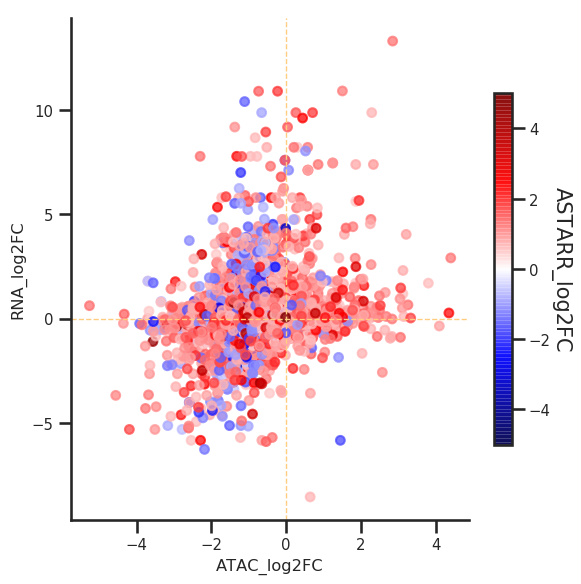

In [24]:
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import seaborn as sns
%matplotlib inline

sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
sns.set_context("talk", font_scale=0.65)
plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':100})

fig = plt.figure(figsize=(6,6))
ax = plt.subplot(1, 1, 1)

points = ax.scatter(
    Th2_atac_astarr_closest_DE_gene['ATAC_log2FC'], 
    Th2_atac_astarr_closest_DE_gene['RNA_log2FC'],
    c=Th2_atac_astarr_closest_DE_gene['ASTARR_log2FC'],
    cmap='seismic', marker='o', s=40, alpha=0.75)

cbar = fig.colorbar(points, shrink=0.7)
cbar.set_label('ASTARR_log2FC', rotation=270, fontsize=15, labelpad=15)
cbar.mappable.set_clim(-5,5)

plt.xlabel('ATAC_log2FC')
plt.ylabel('RNA_log2FC')

sns.despine(fig,ax)

#simpleaxis(ax)
plt.tight_layout()
plt.axhline(0, color='#ffcc80', linewidth = 1, linestyle = 'dashed')
plt.axvline(0, color='#ffcc80', linewidth = 1, linestyle = 'dashed')
plt.show()

In [32]:
import pandas as pd
import glob
import re

tpm_files = {
'Th2.00hr':[
'/data/reddylab/Revathy/collabs/Keith/Th1/processing/rna_seq/210928_KS88_Th1Th2_RNAseq_TimeCourse-pe-stranded-with-sjdb/KS88_Th2_0hr_rep1.star2.rsem.genes.results',
'/data/reddylab/Revathy/collabs/Keith/Th1/processing/rna_seq/210928_KS88_Th1Th2_RNAseq_TimeCourse-pe-stranded-with-sjdb/KS88_Th2_0hr_rep2.star2.rsem.genes.results',
'/data/reddylab/Revathy/collabs/Keith/Th1/processing/rna_seq/210928_KS88_Th1Th2_RNAseq_TimeCourse-pe-stranded-with-sjdb/KS88_Th2_0hr_rep3.star2.rsem.genes.results',
'/data/reddylab/Revathy/collabs/Keith/Th1/processing/rna_seq/210928_KS88_Th1Th2_RNAseq_TimeCourse-pe-stranded-with-sjdb/KS88_Th2_0hr_rep4.star2.rsem.genes.results'
],
'Th2.02hr':[
'/data/reddylab/Revathy/collabs/Keith/Th1/processing/rna_seq/210928_KS88_Th1Th2_RNAseq_TimeCourse-pe-stranded-with-sjdb/KS88_Th2_2hr_rep1.star2.rsem.genes.results',
'/data/reddylab/Revathy/collabs/Keith/Th1/processing/rna_seq/210928_KS88_Th1Th2_RNAseq_TimeCourse-pe-stranded-with-sjdb/KS88_Th2_2hr_rep2.star2.rsem.genes.results',
'/data/reddylab/Revathy/collabs/Keith/Th1/processing/rna_seq/210928_KS88_Th1Th2_RNAseq_TimeCourse-pe-stranded-with-sjdb/KS88_Th2_2hr_rep3.star2.rsem.genes.results',
'/data/reddylab/Revathy/collabs/Keith/Th1/processing/rna_seq/210928_KS88_Th1Th2_RNAseq_TimeCourse-pe-stranded-with-sjdb/KS88_Th2_2hr_rep4.star2.rsem.genes.results'
],
'Th2.16hr':[
'/data/reddylab/Revathy/collabs/Keith/Th1/processing/rna_seq/210928_KS88_Th1Th2_RNAseq_TimeCourse-pe-stranded-with-sjdb/KS88_Th2_16hr_rep1.star2.rsem.genes.results',
'/data/reddylab/Revathy/collabs/Keith/Th1/processing/rna_seq/210928_KS88_Th1Th2_RNAseq_TimeCourse-pe-stranded-with-sjdb/KS88_Th2_16hr_rep2.star2.rsem.genes.results',
'/data/reddylab/Revathy/collabs/Keith/Th1/processing/rna_seq/210928_KS88_Th1Th2_RNAseq_TimeCourse-pe-stranded-with-sjdb/KS88_Th2_16hr_rep3.star2.rsem.genes.results',
'/data/reddylab/Revathy/collabs/Keith/Th1/processing/rna_seq/210928_KS88_Th1Th2_RNAseq_TimeCourse-pe-stranded-with-sjdb/KS88_Th2_16hr_rep4.star2.rsem.genes.results'
],
'Th2.24hr':[
'/data/reddylab/Revathy/collabs/Keith/Th1/processing/rna_seq/210928_KS88_Th1Th2_RNAseq_TimeCourse-pe-stranded-with-sjdb/KS88_Th2_24hr_rep1.star2.rsem.genes.results',
'/data/reddylab/Revathy/collabs/Keith/Th1/processing/rna_seq/210928_KS88_Th1Th2_RNAseq_TimeCourse-pe-stranded-with-sjdb/KS88_Th2_24hr_rep2.star2.rsem.genes.results',
'/data/reddylab/Revathy/collabs/Keith/Th1/processing/rna_seq/210928_KS88_Th1Th2_RNAseq_TimeCourse-pe-stranded-with-sjdb/KS88_Th2_24hr_rep3.star2.rsem.genes.results',
'/data/reddylab/Revathy/collabs/Keith/Th1/processing/rna_seq/210928_KS88_Th1Th2_RNAseq_TimeCourse-pe-stranded-with-sjdb/KS88_Th2_24hr_rep4.star2.rsem.genes.results'
],
'Th2.48hr':[
'/data/reddylab/Revathy/collabs/Keith/Th1/processing/rna_seq/210928_KS88_Th1Th2_RNAseq_TimeCourse-pe-stranded-with-sjdb/KS88_Th2_48hr_rep1.star2.rsem.genes.results',
'/data/reddylab/Revathy/collabs/Keith/Th1/processing/rna_seq/210928_KS88_Th1Th2_RNAseq_TimeCourse-pe-stranded-with-sjdb/KS88_Th2_48hr_rep2.star2.rsem.genes.results',
'/data/reddylab/Revathy/collabs/Keith/Th1/processing/rna_seq/210928_KS88_Th1Th2_RNAseq_TimeCourse-pe-stranded-with-sjdb/KS88_Th2_48hr_rep3.star2.rsem.genes.results',
'/data/reddylab/Revathy/collabs/Keith/Th1/processing/rna_seq/210928_KS88_Th1Th2_RNAseq_TimeCourse-pe-stranded-with-sjdb/KS88_Th2_48hr_rep4.star2.rsem.genes.results'
],
'Th2.72hr':[
'/data/reddylab/Revathy/collabs/Keith/Th1/processing/rna_seq/210928_KS88_Th1Th2_RNAseq_TimeCourse-pe-stranded-with-sjdb/KS88_Th2_72hr-Sort_rep1.star2.rsem.genes.results',
'/data/reddylab/Revathy/collabs/Keith/Th1/processing/rna_seq/210928_KS88_Th1Th2_RNAseq_TimeCourse-pe-stranded-with-sjdb/KS88_Th2_72hr-Sort_rep2.star2.rsem.genes.results',
'/data/reddylab/Revathy/collabs/Keith/Th1/processing/rna_seq/210928_KS88_Th1Th2_RNAseq_TimeCourse-pe-stranded-with-sjdb/KS88_Th2_72hr-Sort_rep3.star2.rsem.genes.results',
'/data/reddylab/Revathy/collabs/Keith/Th1/processing/rna_seq/210928_KS88_Th1Th2_RNAseq_TimeCourse-pe-stranded-with-sjdb/KS88_Th2_72hr-Sort_rep4.star2.rsem.genes.results'
]
}

ref_gene = pd.read_csv('/data/reddylab/Reference_Data/Gencode/vM13/gencode.vM13.gene_id_to_gene_name.txt', sep='\t', names=['gene_id', 'gene', 'gene_type'])

def column_name(s):
    name = '.'.join(s.split('/')[-1].split('.')[:1])
    return name

avg_tpm_df=None
for tpm, files in tpm_files.items():
    df=None
    for file in files:
        df_tmp = pd.read_csv(file, sep='\t')
        df_tmp.columns = df_tmp.columns[:-2].tolist() + [column_name(file)] + df_tmp.columns[-1:].tolist()
        if df is None:
            df = df_tmp.loc[:, ['gene_id'] + [df_tmp.columns[-2]]]
        else:
            df = df.join(df_tmp.loc[:, df_tmp.columns[-2]], how='right')

    count_columns = ["rep" in c for c in df.columns]
    df.loc[:, count_columns] = df.loc[:, count_columns].astype(dtype='float')
    df['%s.Mean'%(tpm)] = df.iloc[:,1:4].mean(axis=1)
    df['%s.Mean'%(tpm)] = df['%s.Mean'%(tpm)].round(2)
    df = df[['gene_id','%s.Mean' % tpm]]
    if avg_tpm_df is None:
        avg_tpm_df = df
    else:
        avg_tpm_df = avg_tpm_df.merge(df, on='gene_id', how='outer')
    count_columns = ["rep" in c for c in avg_tpm_df.columns]
    avg_tpm_df.loc[:, count_columns] = avg_tpm_df.loc[:, count_columns].astype(dtype='float')
    
tpm_df_with_gene = avg_tpm_df.merge(ref_gene, on='gene_id', how='left') 

# tpm_df_with_gene = tpm_df_with_gene[['gene','Th2.00hr.Mean','Th2.02hr.Mean','Th2.16hr.Mean','Th2.24hr.Mean','Th2.48hr.Mean','Th2.72hr.Mean']]
# tpm_df_with_gene.to_csv('/data/reddylab/Revathy/collabs/Keith/Th2/data/rna_seq/tpm/Th2.tpm.mean.txt', sep='\t', index=False)
tpm_df_with_gene[tpm_df_with_gene.gene=='Batf']

gene_id  Th2.02hr.Mean  Th2.48hr.Mean  Th2.72hr.Mean  \
9620  ENSMUSG00000034266.5           4.25          31.93          91.78   

      Th2.16hr.Mean  Th2.00hr.Mean  Th2.24hr.Mean  gene       gene_type  
9620           8.42           6.66          11.94  Batf  protein_coding

In [18]:
import pandas as pd
import numpy as np

Th2_tpm = pd.read_csv('/data/reddylab/Revathy/collabs/Keith/Th2/data/rna_seq/tpm/Th2.tpm.mean.txt', sep='\t')
Th2_tpm_72hr_genes = Th2_tpm[Th2_tpm.gene.isin(Th2_DE_genes)]
Th2_tpm_72hr_genes = Th2_tpm_72hr_genes[(Th2_tpm_72hr_genes.iloc[:,1:7]!=0).any(axis=1)]
Th2_tpm_72hr_genes.rename(columns={'Th2.00hr.Mean':'00',
                                    'Th2.02hr.Mean':'02',
                                    'Th2.16hr.Mean':'16',
                                    'Th2.24hr.Mean':'24',
                                    'Th2.48hr.Mean':'48',
                                    'Th2.72hr.Mean':'72'}, inplace=True)
Th2_tpm_72hr_genes.to_csv('/data/reddylab/Revathy/collabs/Keith/Th2/data/rna_seq/tpm/Th2_tpm_72hr_DE_genes.txt', sep='\t', index=False)

# len(Th1_tpm_72hr_genes[(Th1_tpm_72hr_genes == 0).sum(1)<3].gene.unique())
len(Th2_tpm_72hr_genes.gene.unique())

4427

In [25]:
!head /data/reddylab/Revathy/collabs/Keith/Th2/data/rna_seq/tpm/Th2_tpm_72hr_DE_genes.txt

gene	00	02	16	24	48	72
Gnai3	5.91	7.33	3.17	3.45	4.09	2.95
Scml2	0.0	0.0	0.0	0.15	0.0	0.26
Narf	1.78	0.5	1.45	1.69	0.53	0.76
Cox5a	5.04	6.12	10.37	8.54	9.56	13.6
Brat1	1.86	0.16	0.26	0.08	0.17	0.88
Gna12	2.65	4.4	1.78	0.64	1.33	0.96
Ccnd2	7.5	46.3	19.01	7.93	10.03	27.58
Gpr107	1.8	2.56	0.63	1.27	2.31	3.63
Tspan32	13.93	4.38	8.84	3.96	2.61	2.82


In [26]:
%%bash
source /data/reddylab/software/miniconda2/bin/activate alex
mkdir -p /data/reddylab/Revathy/collabs/Keith/Th2/data/rna_seq/DPGP
sbatch -p all \
    -o /data/reddylab/Revathy/collabs/Keith/Th1/logs/Th1_dp_gp_72hr_DE_genes_tpm.out \
    --cpus-per-task 1 \
    --mem 128G \
    <<'EOF'
#!/bin/sh
module load gcc
#SBATCH --cpus-per-task=1
#SBATCH --mem=64G
outfile="/data/reddylab/Revathy/collabs/Keith/Th2/data/rna_seq/DPGP/Th2_72hr_DEGs_TPM.alpha_0.001.log2fc_DP_GP"
infile="/data/reddylab/Revathy/collabs/Keith/Th2/data/rna_seq/tpm/Th2_tpm_72hr_DE_genes.txt"
#
DP_GP_cluster.py \
--alpha 0.001 \
--true_times \
-i ${infile}  \
-o ${outfile} \
-p png \
--plot
EOF

Submitted batch job 28588519


#### DPGP for TFs from Th2

In [15]:
%%bash
source /data/reddylab/software/miniconda2/bin/activate alex
sbatch -p all \
    -o /data/reddylab/Revathy/collabs/Keith/Th2/logs/Th2_dp_gp_TFs_tpm.out \
    --cpus-per-task 1 \
    --mem 128G \
    <<'EOF'
#!/bin/sh
module load gcc
#SBATCH --cpus-per-task=1
#SBATCH --mem=64G
outfile="/data/reddylab/Revathy/collabs/Keith/Th2/data/rna_seq/DPGP/Th2_TFs_TPM.alpha_0.001.log2fc_DP_GP"
infile="/data/reddylab/Revathy/collabs/Keith/Th2/data/rna_seq/tpm/220715_ExpressedTFs_Th2.txt"
#
DP_GP_cluster.py \
--alpha 0.001 \
--true_times \
-i ${infile}  \
-o ${outfile} \
-p png \
--plot
EOF

Submitted batch job 28646474


In [19]:
import pandas as pd

clusters = pd.read_csv('/data/reddylab/Revathy/collabs/Keith/Th2/data/rna_seq/DPGP/Th2_72hr_DEGs_TPM.alpha_0.001.log2fc_DP_GP_optimal_clustering.txt', sep='\t')
clusters = clusters.rename(columns={'gene':'GeneName'})

Th2_atac_closest_DE_gene_subset_clusters = Th2_atac_closest_DE_gene_subset.merge(clusters, on='GeneName', how='left')
Th2_atac_closest_DE_gene_subset_clusters['cluster'] = Th2_atac_closest_DE_gene_subset_clusters['cluster'].fillna(0)
Th2_atac_closest_DE_gene_subset_clusters['cell_type'] = 'Th2'
Th2_atac_closest_DE_gene_subset_clusters['RNA_tpm'] = Th2_atac_closest_DE_gene_subset_clusters['RNA_tpm'].astype(float)
Th2_atac_closest_DE_gene_subset_clusters.to_csv('/data/reddylab/Revathy/collabs/Keith/Th2/data/integration/Th2_atac_rna_promoters_with_clusters.txt', sep='\t', index=False)
Th2_atac_closest_DE_gene_subset_clusters[Th2_atac_closest_DE_gene_subset_clusters['cluster']==0]


chr_start_end  GeneName  ATAC_log2FC     ATAC_padj  \
89       chr6_37063030_37063926      Dgki    -3.276762  2.450813e-18   
90       chr6_37297912_37298472      Dgki    -1.777305  4.839406e-04   
174    chr1_136116291_136117706   Cacna1s    -2.173847  1.022663e-40   
175    chr1_136075888_136076398   Cacna1s    -1.352873  4.430443e-03   
268      chr1_14918082_14919432     Trpa1    -2.568835  8.546548e-13   
328     chr17_57149122_57150105      Cd70    -2.791337  8.107990e-20   
329     chr17_57146789_57147229      Cd70    -2.639865  2.369540e-07   
429     chr12_34528353_34529709     Hdac9    -4.011606  1.261732e-24   
430     chr12_34906399_34907758     Hdac9    -1.611565  2.032336e-05   
638    chr2_120313854_120315723   Pla2g4f    -2.664356  1.764297e-24   
651     chr14_69190241_69191390    Nkx3-1    -1.245989  4.812324e-05   
696      chr1_86669387_86671042      Nppc    -1.744418  9.267169e-24   
697      chr1_86671796_86672183      Nppc    -2.074287  7.154038e-14   
938     chr14_57103507_57105007      Gjb2    -2.225712  3.659157e-21   
1211    chr19_23446883_23448445    Mamdc2    -2.308329  1.154986e-18   
1360   chr3_101838162_101838906   Mab21l3    -3.348591  1.642850e-17   
1361   chr3_101835968_101836336   Mab21l3    -1.902647  3.269734e-04   
1570   chr2_152931174_152932049     Foxs1    -3.218806  1.097975e-14   
1571   chr2_152933627_152933918     Foxs1    -1.758431  1.174624e-05   
1650     chr2_25697076_25698765     Obp2a    -1.989693  6.570832e-16   
1669     chr1_40268080_40269023     Il1r1     1.490373  9.063229e-06   
1670     chr1_40227482_40228735     Il1r1    -1.002609  7.760881e-03   
1671     chr1_40224766_40225093     Il1r1    -0.478202  3.744805e-01   
2014    chr17_56552936_56553477   Gm20219    -1.250729  4.636977e-04   
2094     chr7_84604706_84606309       Fah    -1.584564  2.791430e-11   
2110   chr8_104846542_104847319     Ces2c    -2.910110  1.135477e-13   
2143    chr14_55513826_55514658     Cpne6    -0.067992  9.149920e-01   
2305    chr15_84680699_84681950      Prr5    -1.233023  1.418729e-06   
2324    chr10_24223157_24224301     Moxd1    -1.111329  3.919016e-03   
2424   chr2_133551931_133553320      Bmp2    -2.334011  1.857585e-12   
...                         ...       ...          ...           ...   
4648     chr2_83813398_83813808   Fam171b    -1.896086  1.086275e-05   
4649     chr2_83812293_83813114   Fam171b    -0.939014  2.039482e-04   
4663     chr7_44527476_44528502      Spib    -1.193983  1.210843e-05   
4890     chr9_83549797_83550142  Sh3bgrl2    -2.006679  6.337128e-05   
4891     chr9_83576470_83577758  Sh3bgrl2    -0.281369  3.686918e-01   
4926   chr5_121618350_121619696    Acad12    -0.943493  8.772659e-05   
4980   chrX_139610033_139611297    Rnf128    -0.867188  1.400524e-04   
5012     chrX_94635909_94636716     Gspt2    -1.274901  1.771696e-04   
5013     chr9_65392844_65393505   Kbtbd13    -1.456958  1.778677e-04   
5014     chr9_65390823_65391839   Kbtbd13    -0.740325  2.996076e-02   
5041      chr19_4425342_4426222      Rhod    -0.726394  4.797506e-02   
5042      chr19_4441179_4441665      Rhod    -0.341817  3.908639e-01   
5067    chr11_80809882_80811014    Tmem98    -1.600536  2.854285e-04   
5090     chr3_87803555_87804760     Insrr    -0.825561  1.007038e-03   
5213     chr9_57467478_57468555    Scamp5    -0.907223  1.298225e-03   
5284     chr6_29278461_29279257   Fam71f2    -0.772355  2.513232e-03   
5390   chr9_124103433_124103703      Ccr2     1.410400  1.622845e-02   
5401     chr3_94398493_94400394    Lingo4    -1.041797  1.246778e-02   
5403     chr9_83807535_83807857    Elovl4    -1.156400  1.260297e-02   
5513       chr9_7500846_7502380     Mmp10     0.378334  9.731413e-02   
5518   chrX_101449055_101450378  Itgb1bp2    -0.887841  5.307893e-02   
5519   chr5_100574702_100575328     Plac8     0.619025  2.422109e-01   
5520   chr5_100569296_100570262     Plac8    -0.408705  3.561373e-01   
5568      chr11_5901706_5902585       Gck    -0.657491  1.

In [20]:
Th2_atac_closest_DE_gene_subset_clusters.describe()

ATAC_log2FC     ATAC_padj   RNA_log2FC      RNA_padj       RNA_tpm  \
count  5632.000000  5.632000e+03  5632.000000  5.632000e+03   5632.000000   
mean     -1.059093  3.660129e-02     0.088618  2.582237e-03     90.039354   
std       0.645468  1.344904e-01     1.489463  7.795276e-03    987.312679   
min      -5.466814  2.630881e-77    -8.566903  0.000000e+00      0.000000   
25%      -1.292110  9.227530e-13    -0.607227  1.918848e-25      4.240000   
50%      -1.092461  7.822458e-08    -0.169268  1.807253e-10     12.750000   
75%      -0.883415  3.966758e-04     0.618296  1.006842e-04     37.735000   
max       3.141323  9.969660e-01    15.731818  4.909394e-02  69314.040000   

          distance      cluster  
count  5632.000000  5632.000000  
mean    -11.598722     8.501243  
std    1054.707621     5.166625  
min   -2998.000000     0.000000  
25%       0.000000     4.000000  
50%       0.000000     8.000000  
75%       0.000000    13.000000  
max    2998.000000    17.000000

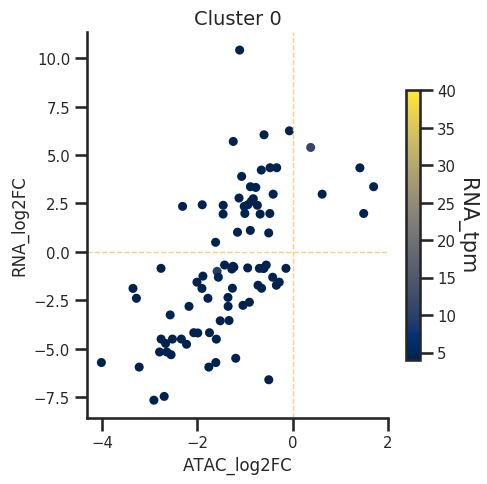

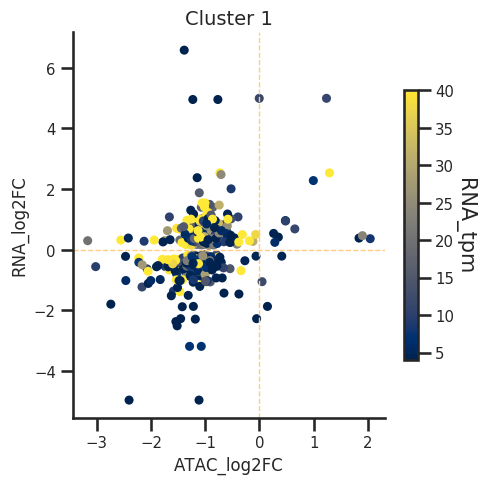

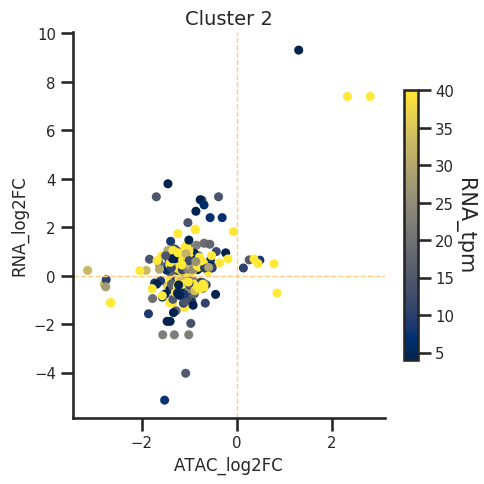

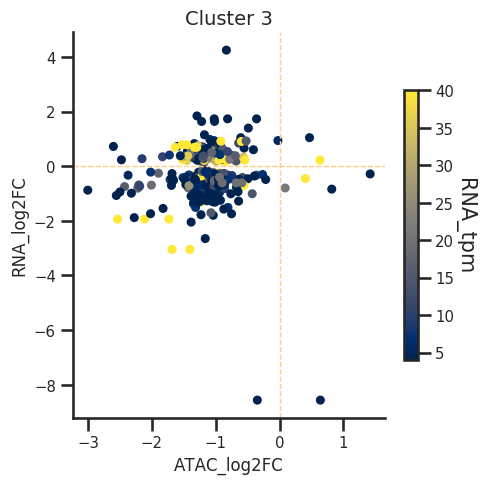

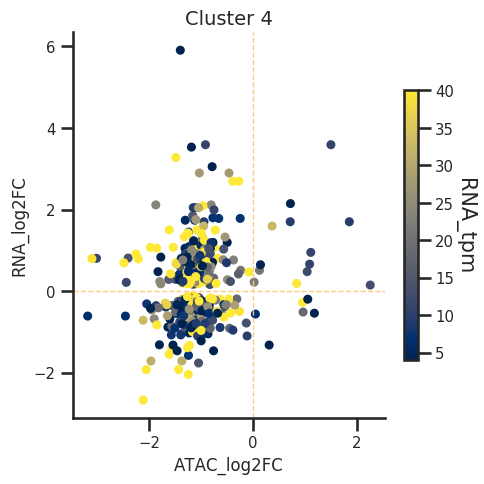

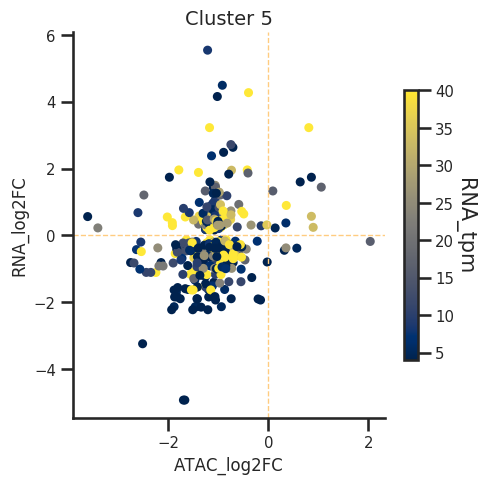

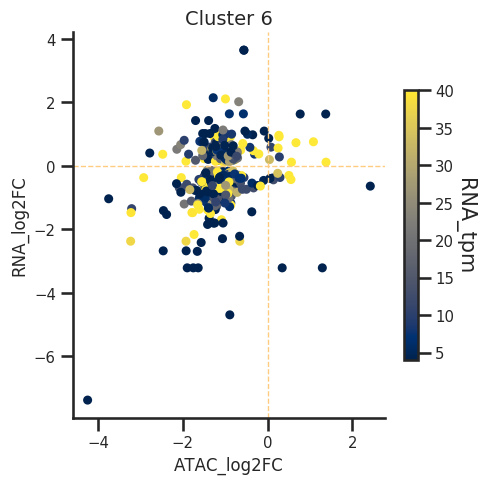

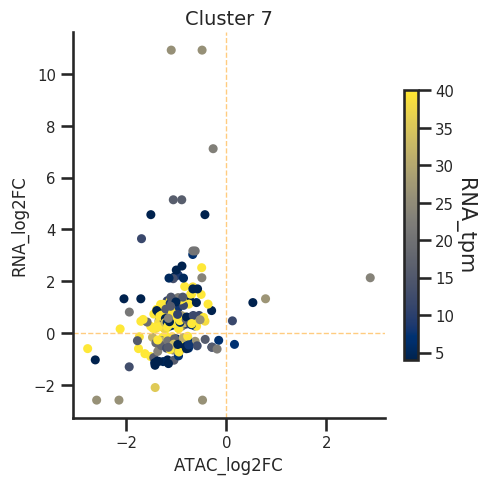

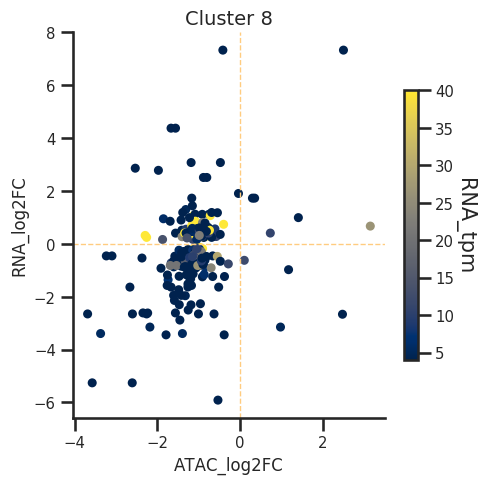

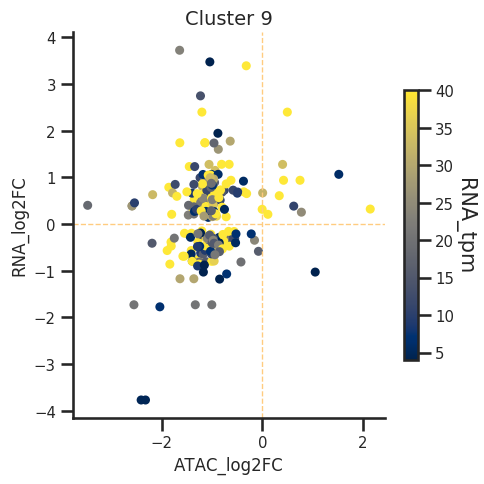

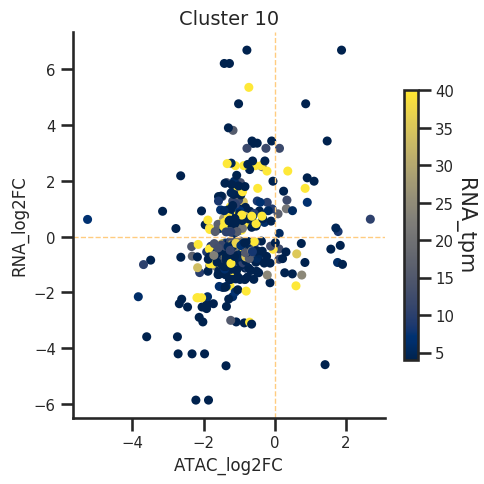

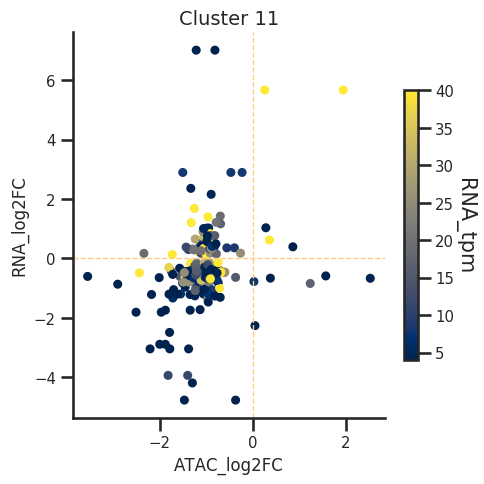

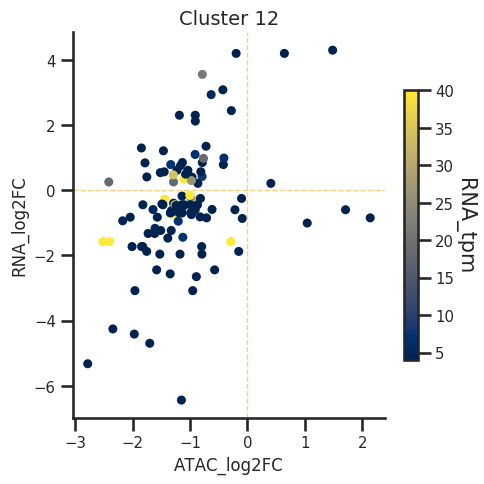

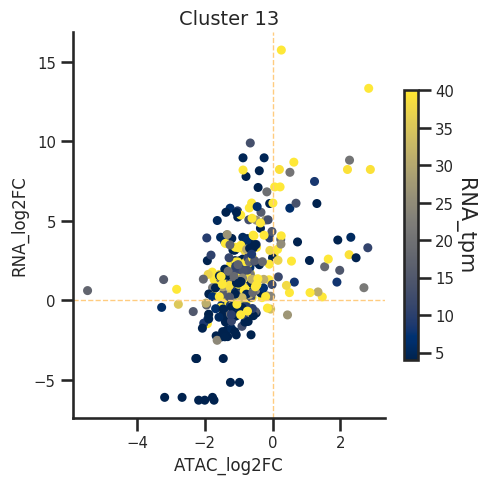

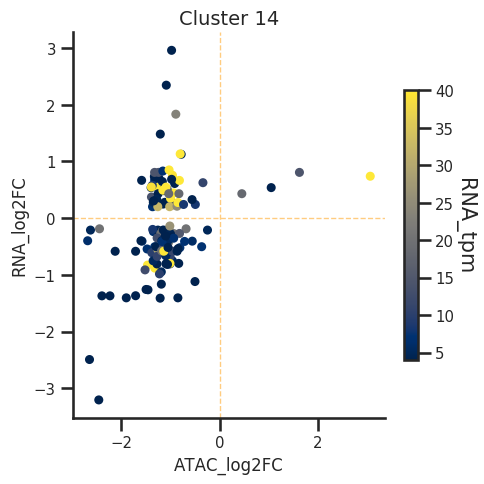

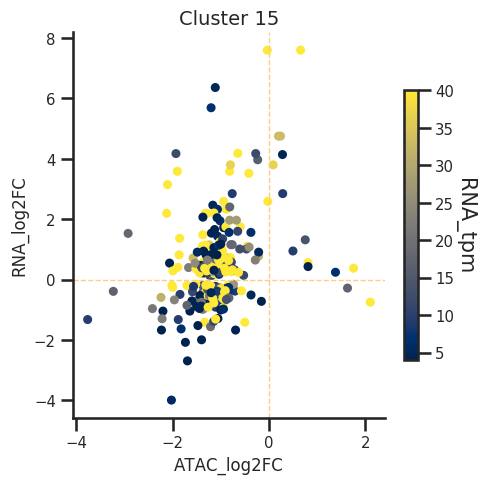

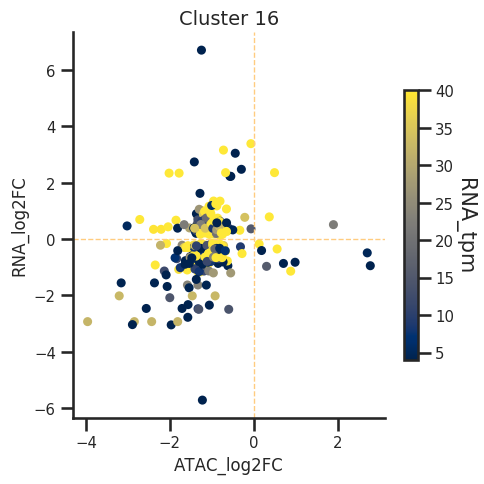

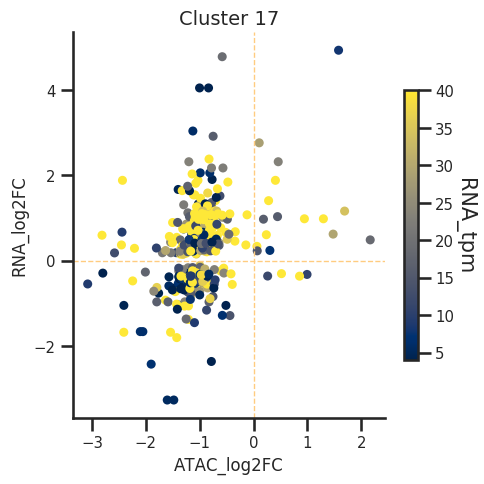

In [21]:
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import seaborn as sns
%matplotlib inline

sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
sns.set_context("talk", font_scale=0.65)
plt.rcParams.update({'figure.figsize':(5,5), 'figure.dpi':100})


for idx, gp in Th2_atac_closest_DE_gene_subset_clusters.groupby('cluster'):
    fig, ax = plt.subplots(figsize=(5,5))
    points = ax.scatter(x=gp['ATAC_log2FC'], y=gp['RNA_log2FC'],
               c=gp['RNA_tpm'], cmap='cividis',marker='o', s=25)
    cbar = fig.colorbar(points, shrink=0.7)
    cbar.set_label('RNA_tpm', rotation=270, fontsize=15, labelpad=15)
    cbar.mappable.set_clim(4,40)
    
    ax.grid()
    ax.set_ylabel('RNA_log2FC', fontsize=12)
    ax.set_xlabel('ATAC_log2FC', fontsize=12)
    ax.set_title('Cluster %d'%idx, fontsize=14)
    sns.despine(fig,ax)
    plt.tight_layout()
    plt.axhline(0, color='#ffcc80', linewidth = 1, linestyle = 'dashed')
    plt.axvline(0, color='#ffcc80', linewidth = 1, linestyle = 'dashed')
    plt.grid(False)
    plt.show()

    

## Treg

In [86]:
import pandas as pd
import glob
import re

files = [
'/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTreg.rna_seq.activated_sorted.72h.rep1.star2.rsem.isoforms.results',
'/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTreg.rna_seq.activated_sorted.72h.rep2.star2.rsem.isoforms.results',
'/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTreg.rna_seq.activated_sorted.72h.rep3.star2.rsem.isoforms.results',
'/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTreg.rna_seq.activated_sorted.72h.rep4.star2.rsem.isoforms.results'
]

def column_name(s):
    name = '.'.join(s.split('/')[-1].split('.')[:5])
    return name

df=None
for file in files:
    df_tmp = pd.read_csv(file, sep='\t')
    df_tmp.columns = df_tmp.columns[:-3].tolist() + [column_name(file)] + df_tmp.columns[-2:].tolist()
    if df is None:
        df = df_tmp.loc[:,['transcript_id','gene_id','length','expected_count'] + [df_tmp.columns[-3]]]
    else:
        df = df.join(df_tmp.loc[:, df_tmp.columns[-3]], how='right')

count_columns = ["rep" in c for c in df.columns]
df.loc[:, count_columns] = df.loc[:, count_columns].astype(dtype='float')
df['Treg.72hr.Sorted.Sum'] = df.iloc[:,4:8].sum(axis=1)
df['Treg.72hr.Sorted.Sum'] = df['Treg.72hr.Sorted.Sum'].round(2)
df['gene_id'] = df['gene_id'].str.split('.').str[0]
df['transcript_id'] = df['transcript_id'].str.split('.').str[0]
idx = df.groupby(['gene_id'])['Treg.72hr.Sorted.Sum'].transform(max)==df['Treg.72hr.Sorted.Sum']
df_subset = df[idx]
df_subset[df_subset.gene_id=='ENSMUSG00000002250']


transcript_id             gene_id  length  expected_count  \
2193  ENSMUST00000002320  ENSMUSG00000002250    3218         3423.32   

      mmTreg.rna_seq.activated_sorted.72h.rep1  \
2193                                      31.1   

      mmTreg.rna_seq.activated_sorted.72h.rep2  \
2193                                     34.04   

      mmTreg.rna_seq.activated_sorted.72h.rep3  \
2193                                     34.78   

      mmTreg.rna_seq.activated_sorted.72h.rep4  Treg.72hr.Sorted.Sum  
2193                                     33.13                133.05

In [87]:
import pandas as pd

transcript_annot = pd.read_csv('/data/reddylab/Revathy/collabs/Keith/data/annotation_files/gencode.vM19.annotation.transcript_TSS.txt', sep='\t')

df_annotated = df_subset.merge(transcript_annot, on=['transcript_id'], how='inner')
df_annotated = df_annotated[['chr','TSS_start','TSS_end','gene_id_x','transcript_id','GeneType','GeneName','strand','Treg.72hr.Sorted.Sum']].dropna()
df_annotated.TSS_start = df_annotated.TSS_start.astype(int)
df_annotated.TSS_end = df_annotated.TSS_end.astype(int)
df_annotated.rename(columns={'gene_id_x':'gene_id'}, inplace=True)
df_annotated[['chr','TSS_start','TSS_end','gene_id','transcript_id','strand','GeneName','GeneType','Treg.72hr.Sorted.Sum']].to_csv('/data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/counts/tpm/Treg_gencode.vM19.annotation.expressed_transcript_TSS.bed', sep='\t', index=False, header=None)
transcript_not_expressed_72 = list(df_annotated['transcript_id'][df_annotated['Treg.72hr.Sorted.Sum']==0].unique())
len(transcript_not_expressed_72)

41193

In [88]:
import pandas as pd
import glob
import re

isoform_files = {
'Treg.00hr':[
'/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTreg.rna_seq.activated.00h.rep1.star2.rsem.isoforms.results',
'/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTreg.rna_seq.activated.00h.rep2.star2.rsem.isoforms.results',
'/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTreg.rna_seq.activated.00h.rep3.star2.rsem.isoforms.results',
'/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTreg.rna_seq.activated.00h.rep4.star2.rsem.isoforms.results'
],
'Treg.02hr':[
'/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTreg.rna_seq.activated.02h.rep2.star2.rsem.isoforms.results',
'/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTreg.rna_seq.activated.02h.rep3.star2.rsem.isoforms.results',
'/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTreg.rna_seq.activated.02h.rep4.star2.rsem.isoforms.results'
],
'Treg.16hr':[
'/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTreg.rna_seq.activated.16h.rep2.star2.rsem.isoforms.results',
'/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTreg.rna_seq.activated.16h.rep3.star2.rsem.isoforms.results',
'/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTreg.rna_seq.activated.16h.rep4.star2.rsem.isoforms.results'
],
'Treg.24hr':[
'/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTreg.rna_seq.activated.24h.rep1.star2.rsem.isoforms.results',
'/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTreg.rna_seq.activated.24h.rep2.star2.rsem.isoforms.results',
'/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTreg.rna_seq.activated.24h.rep3.star2.rsem.isoforms.results',
'/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTreg.rna_seq.activated.24h.rep4.star2.rsem.isoforms.results'
],
'Treg.48hr':[
'/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTreg.rna_seq.activated.48h.rep1.star2.rsem.isoforms.results',
'/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTreg.rna_seq.activated.48h.rep2.star2.rsem.isoforms.results',
'/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTreg.rna_seq.activated.48h.rep3.star2.rsem.isoforms.results',
'/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTreg.rna_seq.activated.48h.rep4.star2.rsem.isoforms.results'
]
}

def column_name(s):
    name = '.'.join(s.split('/')[-1].split('.')[:5])
    return name

tpm_df=None
for isoform, files in isoform_files.items():
    df=None
    for file in files:
        df_tmp = pd.read_csv(file, sep='\t')
        df_tmp.columns = df_tmp.columns[:-3].tolist() + [column_name(file)] + df_tmp.columns[-2:].tolist()
        if df is None:
            df = df_tmp.loc[:,['transcript_id','gene_id','length','expected_count'] + [df_tmp.columns[-3]]]
        else:
            df = df.join(df_tmp.loc[:, df_tmp.columns[-3]], how='right')

    count_columns = ["rep" in c for c in df.columns]
    df.loc[:, count_columns] = df.loc[:, count_columns].astype(dtype='float')
    df['%s.Sum'%(isoform)] = df.iloc[:,4:8].sum(axis=1)
    df['%s.Sum'%(isoform)] = df['%s.Sum'%(isoform)].round(2)
    df = df[['gene_id','transcript_id','%s.Sum' % isoform]]
    df['gene_id'] = df['gene_id'].str.split('.').str[0]
    df['transcript_id'] = df['transcript_id'].str.split('.').str[0]
    if tpm_df is None:
        tpm_df = df
    else:
        tpm_df = tpm_df.merge(df, on=['gene_id','transcript_id'], how='outer')
    count_columns = ["Sum" in c for c in tpm_df.columns]
    tpm_df.loc[:, count_columns] = tpm_df.loc[:, count_columns].astype(dtype='float')

tpm_df['max'] = tpm_df[['Treg.00hr.Sum','Treg.02hr.Sum','Treg.16hr.Sum','Treg.24hr.Sum','Treg.48hr.Sum']].max(axis=1)
idx = tpm_df.groupby(['gene_id'])['max'].transform(max)==tpm_df['max']
tpm_df_subset = tpm_df[idx]
tpm_df_annotated = tpm_df_subset.merge(transcript_annot, on=['transcript_id'], how='left')
tpm_df_annotated_not_72 = tpm_df_annotated[tpm_df_annotated.transcript_id.isin(transcript_not_expressed_72)]
tpm_df_annotated_not_72 = tpm_df_annotated_not_72[['chr','TSS_start','TSS_end','gene_id_x','transcript_id','strand','GeneName','GeneType','max']]
tpm_df_annotated_not_72.rename(columns={'max':'tpm', 'gene_id_x':'gene_id'}, inplace=True)
tpm_df_annotated_not_72['cell_type']='Treg'
tpm_df_annotated_not_72.to_csv('/data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/counts/tpm/Treg_transcript_genes_not_72.txt', sep='\t', index=False)


In [32]:
%%bash 
sort -k1,1 -k2,2n /data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/counts/tpm/Treg_gencode.vM19.annotation.expressed_transcript_TSS.bed \
> /data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/counts/tpm/Treg_gencode.vM19.annotation.expressed_transcript_TSS.sorted.bed

In [27]:
%%bash
sbatch -p all \
    --cpus-per-task 1 \
    --mem 8G \
    -o /data/reddylab/Revathy/collabs/Keith/data/integrative/logs/Treg_all_ATAC_closest_genes.out \
    <<'EOF'
#!/bin/bash
SAMPLE="/data/reddylab/Revathy/collabs/Keith/Treg/data/atac_seq/featureCounts/Th0_Treg.72hrs.UnionPeakSet.featurecounts.df.txt"

tail -n+2 ${SAMPLE} \
| cut -f1 \
| awk -F_ -vOFS="\t" '{print $1, $2, $3, $1"_"$2"_"$3}' \
| sort -k1,1 -k2,2n \
| bedtools closest \
    -nonamecheck \
    -D a \
    -a - \
    -b /data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/counts/tpm/Treg_gencode.vM19.annotation.expressed_transcript_TSS.sorted.bed \
| awk -vOFS="\t" \
    '{if(last==$4){genes=$10","genes;}else{if(genes){print peak, genes, tpm, distance}peak=$4; genes=$10; tpm=$12; distance=$13; last=peak}}END{if(last==$4){genes=$10","genes;print peak, genes, tpm, distance}}' \
> ${SAMPLE/.featurecounts.df.txt/.closest_gene.txt}

EOF

Submitted batch job 28588521


In [25]:
!ls /data/reddylab/Revathy/collabs/Keith/Treg/data/integration/

plots				 Treg_atac_rna_promoters_with_clusters.txt
Treg_all_ATAC_RNA_promoters.txt  Treg_RNA_DE_genes_transcript_level_info.txt
Treg_ATAC_RNA_promoters.txt


In [26]:
%%bash
tail -n+2 /data/reddylab/Revathy/collabs/Keith/Treg/data/atac_seq/featureCounts/Th0_Treg.72hrs.UnionPeakSet.featurecounts.df.txt \
| cut -f1 \
| awk -F_ -vOFS="\t" '{print $1, $2, $3, $1"_"$2"_"$3}' \
| bedtools intersect -wa -wb \
-a - \
-b /data/reddylab/Revathy/collabs/Keith/ENCODE_submission/data/csaw_peaks/Treg.atacSTARR.pooled.3window_minTest.weighted.csaw.mm10.noATACpeaks.0bp_min.0.01.corrected.bed \
| cut -f4- \
> /data/reddylab/Revathy/collabs/Keith/Treg/data/integration/Th2_ATAC_closest_gene_ASTARR_intersect.bed

***** WARNING: File - has inconsistent naming convention for record:
GL456216.1	15676	17541	GL456216.1_15676_17541

***** WARNING: File - has inconsistent naming convention for record:
GL456216.1	15676	17541	GL456216.1_15676_17541



In [28]:
import pandas as pd
import numpy as np


closest_gene = pd.read_csv('/data/reddylab/Revathy/collabs/Keith/Treg/data/atac_seq/featureCounts/Th0_Treg.72hrs.UnionPeakSet.closest_gene.txt', sep='\t', 
                                names=['chr_start_end','GeneName','RNA_tpm','distance'])
Treg_atac = pd.read_csv('/data/reddylab/Revathy/collabs/Keith/Treg/data/atac_seq/deseq/Treg.72hrs.ASTARR.insert_vs_Th0.72hrs.ASTARR.insert.txt', sep='\t')
Treg_rna = pd.read_csv('/data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/deseq/mmTreg.Sorted.72hr_vs_mmTh0.Sorted.72hr.with_genes.txt', sep='\t')
Treg_astarr = pd.read_csv('/data/reddylab/Revathy/collabs/Keith/Treg/data/integration/Th2_ATAC_closest_gene_ASTARR_intersect.bed', sep='\t',
                         names=['chr_start_end','ASTARR_chr','ASTARR_start','ASTARR_end','name','score','strand','ASTARR_log2FC','ASTARR_padj','qval','number'])

Treg_atac.reset_index(inplace=True)
Treg_atac_closest_DE_gene = Treg_atac.merge(closest_gene, left_on='index', right_on='chr_start_end', how='left').merge(Treg_rna, on='GeneName', how='outer')
Treg_atac_astarr_closest_DE_gene = Treg_atac_closest_DE_gene.merge(Treg_astarr, on='chr_start_end', how='outer')
Treg_atac_astarr_closest_DE_gene = Treg_atac_astarr_closest_DE_gene.rename(columns={'log2FoldChange_x':'ATAC_log2FC',
                                                              'log2FoldChange_y':'RNA_log2FC',
                                                              'padj_x':'ATAC_padj',
                                                              'padj_y':'RNA_padj'})

Treg_atac_astarr_closest_DE_gene = Treg_atac_astarr_closest_DE_gene[['chr_start_end','GeneName','ATAC_log2FC','ATAC_padj','ASTARR_chr','ASTARR_start','ASTARR_end','ASTARR_log2FC','ASTARR_padj','RNA_log2FC','RNA_padj','RNA_tpm','distance','GeneType']]
# Treg_atac_closest_DE_gene_subset = Treg_atac_closest_DE_gene[(np.abs(Treg_atac_closest_DE_gene['distance'])<=3000) & (Treg_atac_closest_DE_gene['GeneType']=='protein_coding')]
# Treg_atac_closest_DE_gene_subset = Treg_atac_closest_DE_gene_subset[(Treg_atac_closest_DE_gene_subset['RNA_padj']<0.05)]
Treg_atac_astarr_closest_DE_gene.to_csv('/data/reddylab/Revathy/collabs/Keith/Treg/data/integration/Treg_all_ATAC_ASTARR_RNA.txt', sep='\t', index=False)
Treg_DE_genes = list(Treg_atac_astarr_closest_DE_gene.GeneName.unique())
# Treg_atac_closest_DE_gene_subset.sort_values(by='RNA_log2FC', ascending=False)
len(Treg_DE_genes)

27529

In [23]:
import pandas as pd

rna_transcript = pd.read_csv('/data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/counts/tpm/Treg_gencode.vM19.annotation.expressed_transcript_TSS.bed', sep='\t',
                             names=['chr','TSS_start','TSS_end','gene_id','transcript_id','strand','GeneName','GeneType','Treg.72hr.Sorted.Sum'])
rna_transcript_DE_genes = rna_transcript[rna_transcript.GeneName.isin(Treg_DE_genes)]
rna_transcript_DE_genes[['chr','TSS_start','TSS_end','gene_id','transcript_id','GeneName','Treg.72hr.Sorted.Sum']].to_csv('/data/reddylab/Revathy/collabs/Keith/Treg/data/integration/Treg_RNA_DE_genes_transcript_level_info.txt', sep='\t', index=False)


In [29]:
Treg_atac_astarr_closest_DE_gene['ASTARR_log2FC'].describe()

count    13070.000000
mean         0.135836
std          1.324568
min         -5.083359
25%         -1.065167
50%          0.692362
75%          1.035562
max          8.755590
Name: ASTARR_log2FC, dtype: float64

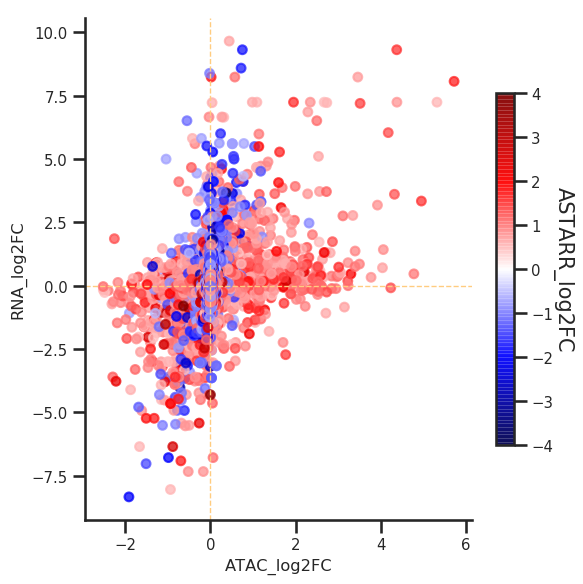

In [31]:
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import seaborn as sns
%matplotlib inline

sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
sns.set_context("talk", font_scale=0.65)
plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':100})

fig = plt.figure(figsize=(6,6))
ax = plt.subplot(1, 1, 1)

points = ax.scatter(
    Treg_atac_astarr_closest_DE_gene['ATAC_log2FC'], 
    Treg_atac_astarr_closest_DE_gene['RNA_log2FC'],
    c=Treg_atac_astarr_closest_DE_gene['ASTARR_log2FC'],
    cmap='seismic', marker='o', s=40, alpha=0.75)

cbar = fig.colorbar(points, shrink=0.7)
cbar.set_label('ASTARR_log2FC', rotation=270, fontsize=15, labelpad=15)
cbar.mappable.set_clim(-4,4)

plt.xlabel('ATAC_log2FC')
plt.ylabel('RNA_log2FC')

sns.despine(fig,ax)

#simpleaxis(ax)
plt.tight_layout()
plt.axhline(0, color='#ffcc80', linewidth = 1, linestyle = 'dashed')
plt.axvline(0, color='#ffcc80', linewidth = 1, linestyle = 'dashed')
plt.show()

In [51]:
import pandas as pd
import glob
import re

tpm_files = {
'Treg.00hr':[
'/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTreg.rna_seq.activated.00h.rep1.star2.rsem.genes.results',
'/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTreg.rna_seq.activated.00h.rep2.star2.rsem.genes.results',
'/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTreg.rna_seq.activated.00h.rep3.star2.rsem.genes.results',
'/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTreg.rna_seq.activated.00h.rep4.star2.rsem.genes.results'
],
'Treg.02hr':[
'/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTreg.rna_seq.activated.02h.rep2.star2.rsem.genes.results',
'/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTreg.rna_seq.activated.02h.rep3.star2.rsem.genes.results',
'/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTreg.rna_seq.activated.02h.rep4.star2.rsem.genes.results'
],
'Treg.16hr':[
'/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTreg.rna_seq.activated.16h.rep2.star2.rsem.genes.results',
'/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTreg.rna_seq.activated.16h.rep3.star2.rsem.genes.results',
'/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTreg.rna_seq.activated.16h.rep4.star2.rsem.genes.results'
],
'Treg.24hr':[
'/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTreg.rna_seq.activated.24h.rep1.star2.rsem.genes.results',
'/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTreg.rna_seq.activated.24h.rep2.star2.rsem.genes.results',
'/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTreg.rna_seq.activated.24h.rep3.star2.rsem.genes.results',
'/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTreg.rna_seq.activated.24h.rep4.star2.rsem.genes.results'
],
'Treg.48hr':[
'/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTreg.rna_seq.activated.48h.rep1.star2.rsem.genes.results',
'/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTreg.rna_seq.activated.48h.rep2.star2.rsem.genes.results',
'/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTreg.rna_seq.activated.48h.rep3.star2.rsem.genes.results',
'/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTreg.rna_seq.activated.48h.rep4.star2.rsem.genes.results'
],
'Treg.72hr':[
'/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTreg.rna_seq.activated_sorted.72h.rep1.star2.rsem.genes.results',
'/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTreg.rna_seq.activated_sorted.72h.rep2.star2.rsem.genes.results',
'/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTreg.rna_seq.activated_sorted.72h.rep3.star2.rsem.genes.results',
'/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTreg.rna_seq.activated_sorted.72h.rep4.star2.rsem.genes.results'
]
}

ref_gene = pd.read_csv('/data/reddylab/Reference_Data/Gencode/vM13/gencode.vM13.gene_id_to_gene_name.txt', sep='\t', names=['gene_id', 'gene', 'gene_type'])

def column_name(s):
    name = '.'.join(s.split('/')[-1].split('.')[:5])
    return name

avg_tpm_df=None
for tpm, files in tpm_files.items():
    df=None
    for file in files:
        df_tmp = pd.read_csv(file, sep='\t')
        df_tmp.columns = df_tmp.columns[:-2].tolist() + [column_name(file)] + df_tmp.columns[-1:].tolist()
        if df is None:
            df = df_tmp.loc[:, ['gene_id'] + [df_tmp.columns[-2]]]
        else:
            df = df.join(df_tmp.loc[:, df_tmp.columns[-2]], how='right')

    count_columns = ["rep" in c for c in df.columns]
    df.loc[:, count_columns] = df.loc[:, count_columns].astype(dtype='float')
    df['%s.Mean'%(tpm)] = df.iloc[:,1:4].mean(axis=1)
    df['%s.Mean'%(tpm)] = df['%s.Mean'%(tpm)].round(2)
    df = df[['gene_id','%s.Mean' % tpm]]
    if avg_tpm_df is None:
        avg_tpm_df = df
    else:
        avg_tpm_df = avg_tpm_df.merge(df, on='gene_id', how='outer')
    count_columns = ["rep" in c for c in avg_tpm_df.columns]
    avg_tpm_df.loc[:, count_columns] = avg_tpm_df.loc[:, count_columns].astype(dtype='float')
    
tpm_df_with_gene = avg_tpm_df.merge(ref_gene, on='gene_id', how='left') 

tpm_df_with_gene = tpm_df_with_gene[['gene','Treg.00hr.Mean','Treg.02hr.Mean','Treg.16hr.Mean','Treg.24hr.Mean','Treg.48hr.Mean','Treg.72hr.Mean']]
tpm_df_with_gene.to_csv('/data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/counts/tpm/Treg.tpm.mean.txt', sep='\t', index=False)
tpm_df_with_gene[tpm_df_with_gene.gene=='Ppard']

gene  Treg.00hr.Mean  Treg.02hr.Mean  Treg.16hr.Mean  Treg.24hr.Mean  \
397  Ppard           23.94           71.55           19.05           33.36   

     Treg.48hr.Mean  Treg.72hr.Mean  
397           27.85           39.07

In [13]:
!wc -l /data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTreg.rna_seq.activated_sorted.72h.rep4.star2.rsem.genes.results

50601 /data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTreg.rna_seq.activated_sorted.72h.rep4.star2.rsem.genes.results


In [14]:
!wc -l /data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTreg.rna_seq.activated_sorted.72h.rep4.star2.rsem.isoforms.results

125571 /data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTreg.rna_seq.activated_sorted.72h.rep4.star2.rsem.isoforms.results


In [25]:
import pandas as pd
import numpy as np

Treg_tpm = pd.read_csv('/data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/counts/tpm/Treg.tpm.mean.txt', sep='\t')
Treg_tpm_72hr_genes = Treg_tpm[Treg_tpm.gene.isin(Treg_DE_genes)]
Treg_tpm_72hr_genes = Treg_tpm_72hr_genes[(Treg_tpm_72hr_genes.iloc[:,1:7]!=0).any(axis=1)]
Treg_tpm_72hr_genes.rename(columns={'Treg.00hr.Mean':'00',
                                    'Treg.02hr.Mean':'02',
                                    'Treg.16hr.Mean':'16',
                                    'Treg.24hr.Mean':'24',
                                    'Treg.48hr.Mean':'48',
                                    'Treg.72hr.Mean':'72'}, inplace=True)
Treg_tpm_72hr_genes.to_csv('/data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/counts/tpm/Treg_tpm_72hr_DE_genes.txt', sep='\t', index=False)

# len(Th1_tpm_72hr_genes[(Th1_tpm_72hr_genes == 0).sum(1)<3].gene.unique())
len(Treg_tpm_72hr_genes.gene.unique())

4113

In [34]:
%%bash
source /data/reddylab/software/miniconda2/bin/activate alex
mkdir -p /data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/dp_gp/tpm
sbatch -p all \
    -o /data/reddylab/Revathy/collabs/Keith/Treg/logs/Treg_dp_gp_72hr_DE_genes_tpm.out \
    --cpus-per-task 1 \
    --mem 128G \
    <<'EOF'
#!/bin/sh
module load gcc
#SBATCH --cpus-per-task=1
#SBATCH --mem=64G
outfile="/data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/dp_gp/tpm/Treg_72hr_DEGs_TPM.alpha_0.001.log2fc_DP_GP"
infile="/data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/counts/tpm/Treg_tpm_72hr_DE_genes.txt"
#
DP_GP_cluster.py \
--alpha 0.001 \
--true_times \
-i ${infile}  \
-o ${outfile} \
-p png \
--plot
EOF

Submitted batch job 28588522


In [50]:
!cat /data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/counts/tpm/Treg_tpm_72hr_DE_genes.txt | grep 'Ppard'

#### DPGP for TFs from Treg

In [16]:
%%bash
source /data/reddylab/software/miniconda2/bin/activate alex
sbatch -p all \
    -o /data/reddylab/Revathy/collabs/Keith/Treg/logs/Treg_dp_gp_TFs_tpm.out \
    --cpus-per-task 1 \
    --mem 128G \
    <<'EOF'
#!/bin/sh
module load gcc
#SBATCH --cpus-per-task=1
#SBATCH --mem=64G
outfile="/data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/dp_gp/tpm/Treg_TFs_TPM.alpha_0.001.log2fc_DP_GP"
infile="/data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/dp_gp/220715_ExpressedTFs_Treg.txt"
#
DP_GP_cluster.py \
--alpha 0.001 \
--true_times \
-i ${infile}  \
-o ${outfile} \
-p png \
--plot
EOF

Submitted batch job 28646495


In [26]:
import pandas as pd

clusters = pd.read_csv('/data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/dp_gp/tpm/Treg_72hr_DEGs_TPM.alpha_0.001.log2fc_DP_GP_optimal_clustering.txt', sep='\t')
clusters = clusters.rename(columns={'gene':'GeneName'})

Treg_atac_closest_DE_gene_subset_clusters = Treg_atac_closest_DE_gene_subset.merge(clusters, on='GeneName', how='left')
Treg_atac_closest_DE_gene_subset_clusters['cluster'] = Treg_atac_closest_DE_gene_subset_clusters['cluster'].fillna(0)
Treg_atac_closest_DE_gene_subset_clusters['cell_type'] = 'Treg'
Treg_atac_closest_DE_gene_subset_clusters['RNA_tpm'] = Treg_atac_closest_DE_gene_subset_clusters['RNA_tpm'].astype(float)
Treg_atac_closest_DE_gene_subset_clusters.to_csv('/data/reddylab/Revathy/collabs/Keith/Treg/data/integration/Treg_atac_rna_promoters_with_clusters.txt', sep='\t', index=False)
Treg_atac_closest_DE_gene_subset_clusters[Treg_atac_closest_DE_gene_subset_clusters['cluster']==0]


Empty DataFrame
Columns: [chr_start_end, GeneName, ATAC_log2FC, ATAC_padj, RNA_log2FC, RNA_padj, RNA_tpm, distance, GeneType, cluster, cell_type]
Index: []

In [10]:
Treg_atac_closest_DE_gene_subset_clusters.describe()

ATAC_log2FC      ATAC_padj   RNA_log2FC      RNA_padj       RNA_tpm  \
count  1242.000000   1.242000e+03  1242.000000  1.242000e+03   1242.000000   
mean      0.249578   7.959562e-03     0.338974  1.808768e-03    269.571820   
std       0.971130   1.283463e-02     2.330389  6.547444e-03   1089.552285   
min      -2.619285  1.485159e-105    -8.336636  0.000000e+00      0.000000   
25%      -0.432954   1.351772e-07    -0.793501  3.373136e-56     14.990000   
50%       0.240926   6.233039e-04     0.341091  1.471941e-19     54.810000   
75%       0.665100   1.122598e-02     1.165549  1.003159e-06    170.495000   
max       4.784206   4.999950e-02     9.652957  4.976519e-02  19111.610000   

          distance      cluster  
count  1242.000000  1242.000000  
mean      1.859903     5.055556  
std    1198.333136     2.649429  
min   -2989.000000     1.000000  
25%       0.000000     3.000000  
50%       0.000000     5.000000  
75%       0.000000     7.000000  
max    2999.000000     9.000000

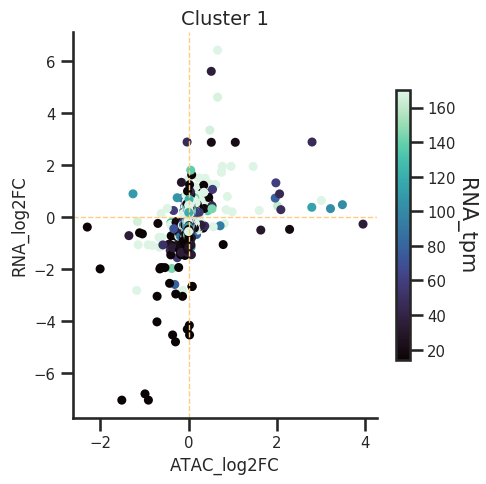

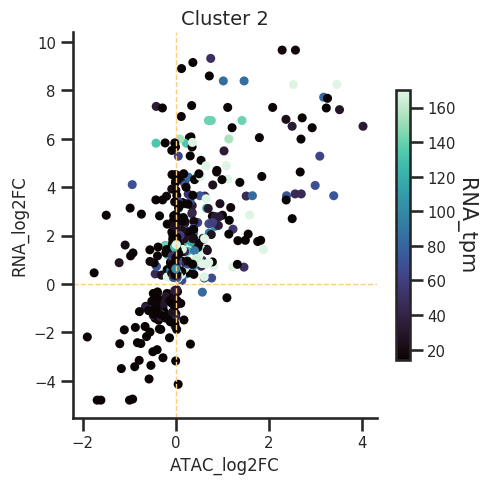

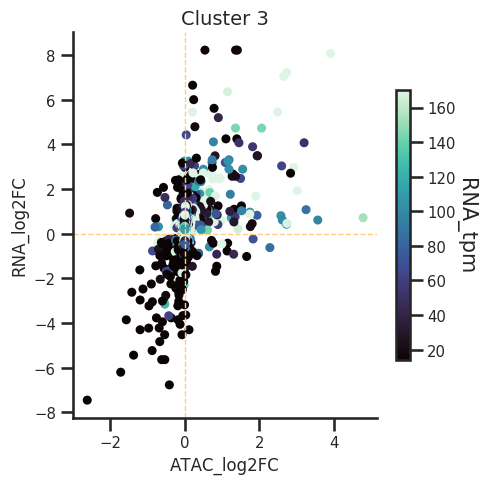

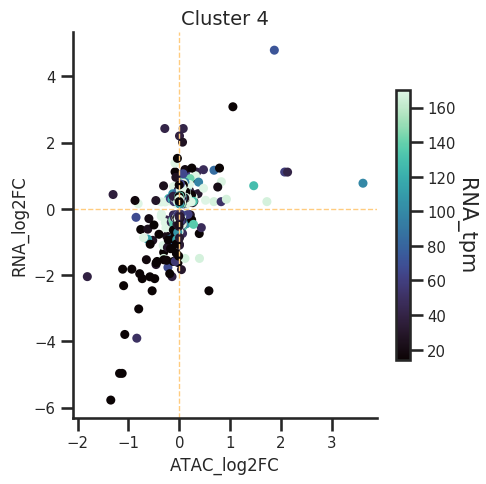

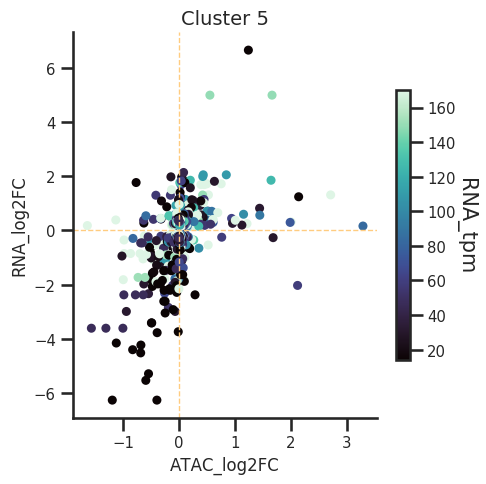

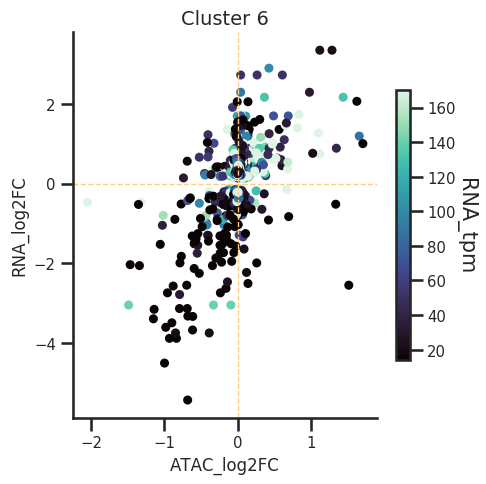

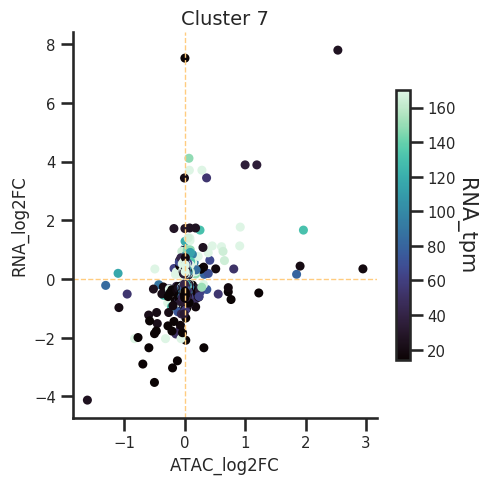

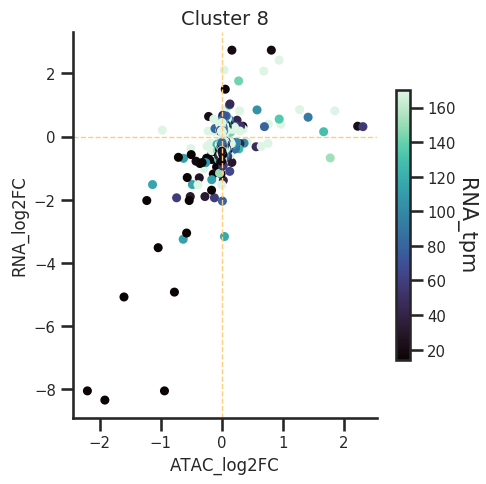

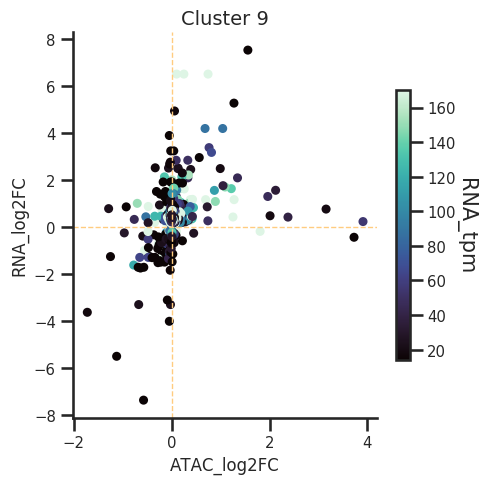

In [27]:
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import seaborn as sns
%matplotlib inline

sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
sns.set_context("talk", font_scale=0.65)
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})


for idx, gp in Treg_atac_closest_DE_gene_subset_clusters.groupby('cluster'):
    fig, ax = plt.subplots(figsize=(5,5))
    points = ax.scatter(x=gp['ATAC_log2FC'], y=gp['RNA_log2FC'],
               c=gp['RNA_tpm'], cmap='mako',marker='o', s=25)
    cbar = fig.colorbar(points, shrink=0.7)
    cbar.set_label('RNA_tpm', rotation=270, fontsize=15, labelpad=15)
    cbar.mappable.set_clim(14,170)
    
    ax.grid()
    ax.set_ylabel('RNA_log2FC', fontsize=12)
    ax.set_xlabel('ATAC_log2FC', fontsize=12)
    ax.set_title('Cluster %d'%idx, fontsize=14)
    sns.despine(fig,ax)
    plt.tight_layout()
    plt.axhline(0, color='#ffcc80', linewidth = 1, linestyle = 'dashed')
    plt.axvline(0, color='#ffcc80', linewidth = 1, linestyle = 'dashed')
    plt.grid(False)
    plt.show()

    

## Concat 4 cell type table to form MasterTable

In [7]:
%%bash
ls /data/reddylab/Revathy/collabs/Keith/Th1/data/integration/Th1_all_ATAC_ASTARR_RNA.txt \
/data/reddylab/Revathy/collabs/Keith/Th2/data/integration/Th2_all_ATAC_ASTARR_RNA.txt \
/data/reddylab/Revathy/collabs/Keith/Th17/data/integration/Th17_all_ATAC_ASTARR_RNA.txt \
/data/reddylab/Revathy/collabs/Keith/Treg/data/integration/Treg_all_ATAC_ASTARR_RNA.txt \

/data/reddylab/Revathy/collabs/Keith/Th17/data/integration/Th17_all_ATAC_ASTARR_RNA.txt
/data/reddylab/Revathy/collabs/Keith/Th1/data/integration/Th1_all_ATAC_ASTARR_RNA.txt
/data/reddylab/Revathy/collabs/Keith/Th2/data/integration/Th2_all_ATAC_ASTARR_RNA.txt
/data/reddylab/Revathy/collabs/Keith/Treg/data/integration/Treg_all_ATAC_ASTARR_RNA.txt


In [14]:
import pandas as pd

Th1 = pd.read_csv('/data/reddylab/Revathy/collabs/Keith/Th1/data/integration/Th1_all_ATAC_ASTARR_RNA.txt', sep='\t')
Th2 = pd.read_csv('/data/reddylab/Revathy/collabs/Keith/Th2/data/integration/Th2_all_ATAC_ASTARR_RNA.txt', sep='\t')
Th17 = pd.read_csv('/data/reddylab/Revathy/collabs/Keith/Th17/data/integration/Th17_all_ATAC_ASTARR_RNA.txt', sep='\t')
Treg = pd.read_csv('/data/reddylab/Revathy/collabs/Keith/Treg/data/integration/Treg_all_ATAC_ASTARR_RNA.txt', sep='\t')

Th1['cell_type'] = 'Th1'
Th2['cell_type'] = 'Th2'
Th17['cell_type'] = 'Th17'
Treg['cell_type'] = 'Treg'

MasterTable = pd.concat([Th1, Th2, Th17, Treg])
MasterTable.drop('GeneType', axis=1, inplace=True)
MasterTable.to_csv('/data/reddylab/Revathy/collabs/Keith/Tcell/data/integration/Th1_Th2_Th17_Treg_all_ATAC_ASTARR_RNA.txt', sep='\t', index=False)



/data/reddylab/software/miniconda3/envs/revathy_py3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2683: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
#### RNA Transcript info MasterTable for DE genes

th1 = pd.read_csv('/data/reddylab/Revathy/collabs/Keith/Th1/data/integration/Th1_RNA_DE_genes_transcript_level_info.txt', sep='\t')
th2 = pd.read_csv('/data/reddylab/Revathy/collabs/Keith/Th2/data/integration/Th2_RNA_DE_genes_transcript_level_info.txt', sep='\t')
th17 = pd.read_csv('/data/reddylab/Revathy/collabs/Keith/Th17/data/integration/Th17_RNA_DE_genes_transcript_level_info.txt', sep='\t')
treg = pd.read_csv('/data/reddylab/Revathy/collabs/Keith/Treg/data/integration/Treg_RNA_DE_genes_transcript_level_info.txt', sep='\t')

th1['cell_type'] = 'Th1'
th2['cell_type'] = 'Th2'
th17['cell_type'] = 'Th17'
treg['cell_type'] = 'Treg'

th1.rename(columns={'Th1.72hr.Sorted.Sum':'TPM'}, inplace=True)
th2.rename(columns={'Th2.72hr.Sorted.Sum':'TPM'}, inplace=True)
th17.rename(columns={'Th17.72hr.Sorted.Sum':'TPM'}, inplace=True)
treg.rename(columns={'Treg.72hr.Sorted.Sum':'TPM'}, inplace=True)

transcript_MasterTable = pd.concat([th1,th2,th17,treg])
transcript_MasterTable.to_csv('/data/reddylab/Revathy/collabs/Keith/Tcell/data/integration/Th1_Th2_Th17_Treg_DE_genes_transcript_info.txt', sep='\t', index=False)

#### RNA MasterTable with TPM and logFC at each time point

Files

Th1:`ls /data/reddylab/Revathy/collabs/Keith/Th1/data/rna_seq/deseq/Th1*.with_genes.txt`
Th2:`/data/reddylab/Revathy/collabs/Keith/Th1/data/rna_seq/deseq/Th2*.with_genes.txt`
Th17:`/data/reddylab/Revathy/collabs/rna-seq_Siklenka/results/rna_seq/differential_testing/deseq2/timeseries/Th17.Sorted.72hr_vs_mmTh0.Sorted.72hr.with_genes.txt`
Treg:`/data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/deseq/mmTreg.Sorted.72hr_vs_mmTh0.Sorted.72hr.with_genes.txt`

In [30]:
import glob
import re
import pandas as pd

def clean_columns(f):
    return '.'.join(f.split('/')[-1].split('_')[:1])

logFC_files = {
#     'Th1':[
# '/data/reddylab/Revathy/collabs/Keith/Th1/data/rna_seq/deseq/Th1.Bulk.00hr_vs_mmTh0.Bulk.00hr.with_genes.txt',
# '/data/reddylab/Revathy/collabs/Keith/Th1/data/rna_seq/deseq/Th1.Bulk.16hr_vs_mmTh0.Bulk.16hr.with_genes.txt',
# '/data/reddylab/Revathy/collabs/Keith/Th1/data/rna_seq/deseq/Th1.Bulk.24hr_vs_mmTh0.Bulk.24hr.with_genes.txt',
# '/data/reddylab/Revathy/collabs/Keith/Th1/data/rna_seq/deseq/Th1.Bulk.02hr_vs_mmTh0.Bulk.02hr.with_genes.txt',
# '/data/reddylab/Revathy/collabs/Keith/Th1/data/rna_seq/deseq/Th1.Bulk.48hr_vs_mmTh0.Bulk.48hr.with_genes.txt',
# '/data/reddylab/Revathy/collabs/Keith/Th1/data/rna_seq/deseq/Th1.Sorted.72hr_vs_mmTh0.Sorted.72hr.with_genes.txt'],
#     'Th2':[
# '/data/reddylab/Revathy/collabs/Keith/Th1/data/rna_seq/deseq/Th2.Bulk.00hr_vs_mmTh0.Bulk.00hr.with_genes.txt',
# '/data/reddylab/Revathy/collabs/Keith/Th1/data/rna_seq/deseq/Th2.Bulk.16hr_vs_mmTh0.Bulk.16hr.with_genes.txt',
# '/data/reddylab/Revathy/collabs/Keith/Th1/data/rna_seq/deseq/Th2.Bulk.24hr_vs_mmTh0.Bulk.24hr.with_genes.txt',
# '/data/reddylab/Revathy/collabs/Keith/Th1/data/rna_seq/deseq/Th2.Bulk.02hr_vs_mmTh0.Bulk.02hr.with_genes.txt',
# '/data/reddylab/Revathy/collabs/Keith/Th1/data/rna_seq/deseq/Th2.Bulk.48hr_vs_mmTh0.Bulk.48hr.with_genes.txt',
# '/data/reddylab/Revathy/collabs/Keith/Th1/data/rna_seq/deseq/Th2.Sorted.72hr_vs_mmTh0.Sorted.72hr.with_genes.txt'
#     ],
#     'Th17':[
# '/data/reddylab/Revathy/collabs/rna-seq_Siklenka/results/rna_seq/differential_testing/deseq2/timeseries/Th17.Bulk.00hr_vs_mmTh0.Bulk.00hr.with_genes.txt',
# '/data/reddylab/Revathy/collabs/rna-seq_Siklenka/results/rna_seq/differential_testing/deseq2/timeseries/Th17.Bulk.02hr_vs_mmTh0.Bulk.02hr.with_genes.txt',
# '/data/reddylab/Revathy/collabs/rna-seq_Siklenka/results/rna_seq/differential_testing/deseq2/timeseries/Th17.Bulk.16hr_vs_mmTh0.Bulk.16hr.with_genes.txt',
# '/data/reddylab/Revathy/collabs/rna-seq_Siklenka/results/rna_seq/differential_testing/deseq2/timeseries/Th17.Bulk.24hr_vs_mmTh0.Bulk.24hr.with_genes.txt',
# '/data/reddylab/Revathy/collabs/rna-seq_Siklenka/results/rna_seq/differential_testing/deseq2/timeseries/Th17.Bulk.48hr_vs_mmTh0.Bulk.48hr.with_genes.txt',
# '/data/reddylab/Revathy/collabs/rna-seq_Siklenka/results/rna_seq/differential_testing/deseq2/timeseries/Th17.Sorted.72hr_vs_mmTh0.Sorted.72hr.with_genes.txt'
#     ],
    'mmTreg':[
'/data/reddylab/Revathy/collabs/rna-seq_Siklenka/results/rna_seq/differential_testing/deseq2/timeseries/mmTreg.Bulk.00hr_vs_mmTh0.Bulk.00hr.with_genes.txt',
'/data/reddylab/Revathy/collabs/rna-seq_Siklenka/results/rna_seq/differential_testing/deseq2/timeseries/mmTreg.Bulk.02hr_vs_mmTh0.Bulk.02hr.with_genes.txt',
'/data/reddylab/Revathy/collabs/rna-seq_Siklenka/results/rna_seq/differential_testing/deseq2/timeseries/mmTreg.Bulk.16hr_vs_mmTh0.Bulk.16hr.with_genes.txt',
'/data/reddylab/Revathy/collabs/rna-seq_Siklenka/results/rna_seq/differential_testing/deseq2/timeseries/mmTreg.Bulk.24hr_vs_mmTh0.Bulk.24hr.with_genes.txt',
'/data/reddylab/Revathy/collabs/rna-seq_Siklenka/results/rna_seq/differential_testing/deseq2/timeseries/mmTreg.Bulk.48hr_vs_mmTh0.Bulk.48hr.with_genes.txt',
'/data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/deseq/mmTreg.Sorted.72hr_vs_mmTh0.Sorted.72hr.with_genes.txt'      
    ]
}


for cell_type, file in logFC_files.items():
    df = None
    for f in file:
        df_tmp = pd.read_csv(f, sep = '\t')
        if 'stat' in df_tmp.columns.tolist():
            df_tmp.drop(columns = ['Unnamed: 0', 'baseMean', 'lfcSE', 'pvalue', 'padj', 'GeneType', 'stat'], inplace = True)
        else:
            df_tmp.drop(columns = ['Unnamed: 0', 'baseMean', 'lfcSE', 'pvalue', 'padj', 'GeneType'], inplace = True)
                
        df_tmp = df_tmp[['GeneName', 'log2FoldChange']]
        df_tmp.columns = df_tmp.columns[:-1].tolist() + [clean_columns(f)]
        if df is None:
            df = df_tmp
        else:
            df = df.merge(df_tmp, how = 'outer', on = 'GeneName')
        
    df = df[['GeneName','%s.Bulk.00hr'%cell_type,'%s.Bulk.02hr'%cell_type,'%s.Bulk.16hr'%cell_type,'%s.Bulk.24hr'%cell_type,'%s.Bulk.48hr'%cell_type,'%s.Sorted.72hr'%cell_type]]
    df.columns = [u'gene','logFC_00hr','logFC_02hr','logFC_16hr','logFC_24hr','logFC_48hr','logFC_72hr']
    df = df.fillna(0)
    df.to_csv('/data/reddylab/Revathy/collabs/Keith/Treg/data/integration/%s.logFC.txt' % (cell_type), sep='\t', index = False)  


#### Data

`/data/reddylab/Revathy/collabs/Keith/Th1/data/integration/Th1.logFC.txt
/data/reddylab/Revathy/collabs/Keith/Th2/data/integration/Th2.logFC.txt
/data/reddylab/Revathy/collabs/Keith/Th17/data/integration/Th17.logFC.txt
/data/reddylab/Revathy/collabs/Keith/Treg/data/integration/mmTreg.logFC.txt
/data/reddylab/Revathy/collabs/Keith/Th17/data/rna_seq/counts/Th17.tpm.mean.txt
/data/reddylab/Revathy/collabs/Keith/Th1/data/rna_seq/tpm/Th1.tpm.mean.txt
/data/reddylab/Revathy/collabs/Keith/Th2/data/rna_seq/tpm/Th2.tpm.mean.txt
/data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/counts/tpm/Treg.tpm.mean.txt`

In [23]:
import pandas as pd

columns=['gene','TPM_00hr','TPM_02hr','TPM_16hr','TPM_24hr','TPM_48hr','TPM_72hr']

Th1_tpm = pd.read_csv('/data/reddylab/Revathy/collabs/Keith/Th1/data/rna_seq/tpm/Th1.tpm.mean.txt', sep='\t', names=columns, skiprows=1)
Th2_tpm = pd.read_csv('/data/reddylab/Revathy/collabs/Keith/Th2/data/rna_seq/tpm/Th2.tpm.mean.txt', sep='\t', names=columns, skiprows=1)
Th17_tpm = pd.read_csv('/data/reddylab/Revathy/collabs/Keith/Th17/data/rna_seq/counts/Th17.tpm.mean.txt', sep='\t', names=columns, skiprows=1)
Treg_tpm = pd.read_csv('/data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/counts/tpm/Treg.tpm.mean.txt', sep='\t', names=columns, skiprows=1)

Th1_logFC = pd.read_csv('/data/reddylab/Revathy/collabs/Keith/Th1/data/integration/Th1.logFC.txt', sep='\t')
Th2_logFC = pd.read_csv('/data/reddylab/Revathy/collabs/Keith/Th2/data/integration/Th2.logFC.txt', sep='\t')
Th17_logFC = pd.read_csv('/data/reddylab/Revathy/collabs/Keith/Th17/data/integration/Th17.logFC.txt', sep='\t')
Treg_logFC = pd.read_csv('/data/reddylab/Revathy/collabs/Keith/Treg/data/integration/mmTreg.logFC.txt', sep='\t')

Th1_tpm_logFC = Th1_tpm.merge(Th1_logFC, on='gene', how='outer')
Th2_tpm_logFC = Th2_tpm.merge(Th2_logFC, on='gene', how='outer')
Th17_tpm_logFC = Th17_tpm.merge(Th17_logFC, on='gene', how='outer')
Treg_tpm_logFC = Treg_tpm.merge(Treg_logFC, on='gene', how='outer')

Th1_tpm_logFC['cell_type'] = 'Th1'
Th2_tpm_logFC['cell_type'] = 'Th2'
Th17_tpm_logFC['cell_type'] = 'Th17'
Treg_tpm_logFC['cell_type'] = 'Treg'

RNA_mastertable = pd.concat([Th1_tpm_logFC,Th2_tpm_logFC,Th17_tpm_logFC,Treg_tpm_logFC], ignore_index=True)
RNA_mastertable = RNA_mastertable[['gene','cell_type',
                                   'TPM_00hr','logFC_00hr','TPM_02hr','logFC_02hr','TPM_16hr','logFC_16hr',
                                   'TPM_24hr','logFC_24hr','TPM_48hr','logFC_48hr','TPM_72hr','logFC_72hr']]
RNA_mastertable.to_csv('/data/reddylab/Revathy/collabs/Keith/Tcell/data/integration/Th1_Th2_Th17_Treg.RNA_tpm_logFC_timepoints.masterTable.txt', sep='\t', index=False)

In [25]:
RNA_mastertable[RNA_mastertable['gene']=='Batf']

gene cell_type  TPM_00hr  logFC_00hr  TPM_02hr  logFC_02hr  TPM_16hr  \
9642    Batf       Th1     32.07   -0.374279     11.85    0.148518     44.03   
60260   Batf       Th2      6.66   -0.227488      4.25    1.648666      8.42   
110876  Batf      Th17     39.17   -0.435353    322.11    4.662978    271.09   
161492  Batf      Treg     47.91   -0.048351     14.79    0.044637     41.02   

        logFC_16hr  TPM_24hr  logFC_24hr  TPM_48hr  logFC_48hr  TPM_72hr  \
9642      0.008492     52.35    0.155084     78.66    0.229516    125.65   
60260     0.713347     11.94    0.656636     31.93    1.433474     91.78   
110876    2.472546    370.18    2.375066    210.16    0.814547    189.96   
161492   -0.286612     44.94   -0.632007     70.25   -0.869118     58.00   

        logFC_72hr  
9642      0.548145  
60260     1.817084  
110876    0.637650  
161492   -1.045247

## To-do
* Create Venn Diagram for the overlap of the genes
* Get all the TSS info for all the genes expressed irrsepective of DE 
* Look at the clustering and figure out what is happening


#### Venn Diagram for the 4 sets

/data/reddylab/software/miniconda3/envs/revathy_py3/lib/python3.5/site-packages/venn/_backwards_compatibility.py:17: UserWarning: `get_labels()` is retained for backwards compatibility; use `generate_petal_labels()` or the higher level `venn()` instead
  "use `generate_petal_labels()` or the higher level `venn()` instead"
/data/reddylab/software/miniconda3/envs/revathy_py3/lib/python3.5/site-packages/venn/_backwards_compatibility.py:32: UserWarning: `venn4()` is retained for backwards compatibility; use `venn()` instead
  "use `venn()` instead"


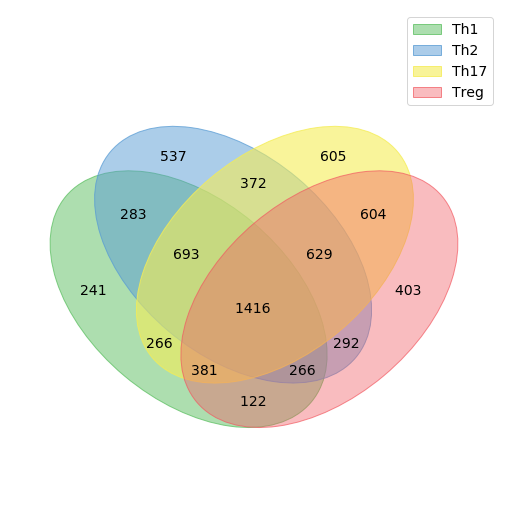

In [17]:
import venn
labels = venn.get_labels([set(Th1.GeneName),set(Th2.GeneName),set(Th17.GeneName),set(Treg.GeneName)])
fig, ax = venn.venn4(labels, names=['Th1', 'Th2', 'Th17', 'Treg'])

#### UpSet plot for the 4 cell_types

In [20]:
len(MasterTable.GeneName.unique())

7110

In [19]:
import numpy as np
MasterTable[(np.abs(MasterTable.distance)<50)&(np.abs(MasterTable.distance)>0)]

chr_start_end GeneName  ATAC_log2FC     ATAC_padj  \
9        chr9_86617588_86618695      Me1     0.438952  9.774139e-04   
240     chr11_22002522_22002889     Otx1    -0.849390  1.487716e-02   
331     chr12_34528353_34529709    Hdac9    -3.066664  3.316309e-32   
537    chr1_165302640_165303002   Gpr161          NaN           NaN   
763     chr19_59074664_59076037    Shtn1    -2.235488  5.927502e-20   
912      chr2_59266195_59266684     Pkp4    -0.170052  5.080274e-01   
970      chr9_32540075_32541588     Fli1    -0.026620  8.268031e-01   
1094  chr11_100574241_100575881      Cnp     0.017698  8.757928e-01   
1202  chr10_121293683_121294643  Tbc1d30    -1.122458  1.523241e-11   
1296    chr11_58214285_58215015    Irgm2     0.550429  6.422084e-03   
1607      chr16_8737393_8738399     Usp7     0.083289  5.778112e-01   
1658   chr2_102400264_102401688   Trim44    -0.191310  4.244611e-02   
2510   chr1_173630331_173630894   Ifi209    -0.547271  5.176428e-02   
2631   chr7_109506988_109508099   Trim66     0.784930  1.072608e-02   
2750    chr15_61984742_61985877      Myc     0.246241  3.009761e-03   
2841     chr7_28863496_28863817   Lgals7    -1.085600  3.335368e-04   
3050   chr7_141154654_141155731   Ptdss2          NaN           NaN   
3073    chr10_79995226_79997609    Abca7     0.302212  1.792229e-03   
3088     chr9_41156619_41158053  Ubash3b    -0.192062  1.016954e-01   
3196     chr9_65214705_65215942   Parp16     0.027336  7.922746e-01   
3248     chr6_87809155_87809733    Rab43    -0.143107  2.142214e-01   
3473     chr5_24394179_24394900    Abcb8    -0.200791  1.904335e-02   
3658    chr12_32965405_32965769     Sypl          NaN           NaN   
3710     chr5_30869090_30870321  Tmem214    -0.223773  6.339615e-02   
3888     chr9_13245360_13245808     Jrkl     0.400917  1.269608e-01   
4564   chr4_120516923_120517654    Scmh1          NaN           NaN   
4695     chr2_26399505_26401639   Inpp5e    -0.037567  8.261836e-01   
4718   chr4_129623896_129625480  Ccdc28b    -0.015622  8.514020e-01   
4853       chr5_4192412_4193469  Mterf1b          NaN           NaN   
16     chr2_151571836_151572590   Sdcbp2    -1.010075  4.380764e-06   
...                         ...      ...          ...           ...   
643     chr11_75168181_75169497     Hic1    -0.277061  4.941569e-03   
742    chr1_177444347_177444615   Zbtb18     2.598348  7.946808e-14   
768   chr10_117675898_117676628      Cpm    -0.240533  2.481162e-01   
822    chr8_104846772_104847053    Ces2c    -2.619285  1.221252e-12   
941    chr5_115730880_115731584   Bicdl1    -0.033318  7.378400e-01   
1113    chr19_59074755_59076030    Shtn1    -0.786813  2.736134e-04   
1227     chr5_24394192_24394948    Abcb8    -0.001274  9.866511e-01   
1398     chr2_16355672_16357107   Plxdc2     0.001749  9.853715e-01   
1646    chr17_35188105_35188401     Lst1     0.175864  3.755151e-01   
1656     chr5_43868582_43870070     Cd38     0.598795  1.455750e-05   
1701  chr10_127341987_127342656     Gli1    -0.020915  8.457011e-01   
1819     chr8_88293724_88294227    Adcy7     0.207758  8.999310e-02   
1943     chr3_88531288_88532359    Mex3a     0.514826  1.524979e-03   
1982     chr2_35696241_35696714   Dab2ip     0.783821  3.507336e-02   
2114   chr5_115844466_115845616      Cit     0.072226  2.967923e-01   
2251   chr5_123142197_123142571   Setd1b    -0.090597  5.213868e-01   
2978   chr7_127903883_127904760    Bckdk     0.211914  6.309347e-02   
3007   chr7_132599653_132600354   Nkx1-2    -0.362031  6.797273e-02   
3196  chr12_113097664_113098250     Mta1    -0.089080  5.361623e-01   
3772   chr9_118478387_118479600    Eomes    -0.111835  3.284476e-01   
3992     chr5_45519871_45520997    Med28    -0.074230  4.281348e-01   
4000  chr10_127263058_127263341    Kif5a    -0.140010  4.314838e-01   
4008   chr4_126148043_126149170    Eva1b     0.068303  4.338844e-01   
4110      chr11_3330447_3330957  Pik3ip1     0.067092  4.847867e-01   
4202   chr1_171222212_171222991  Tomm40l  

In [36]:
len(MasterTable.GeneName.unique())

7110

In [39]:
transcript_MasterTable[transcript_MasterTable.GeneName=='Foxp3']

chr  TSS_start  TSS_end                gene_id         transcript_id  \
2615  chrX    7586273  7586274  ENSMUSG00000039521.12  ENSMUST00000045566.6   
2936  chrX    7579693  7579694  ENSMUSG00000039521.12  ENSMUST00000115739.7   

     GeneName     TPM cell_type  
2615    Foxp3   58.24       Th1  
2936    Foxp3  615.83      Treg

In [44]:
Treg[Treg.GeneName=='Batf']

Empty DataFrame
Columns: [chr_start_end, GeneName, ATAC_log2FC, ATAC_padj, RNA_log2FC, RNA_padj, RNA_tpm, distance, GeneType, cluster, cell_type]
Index: []

In [34]:
len(transcript_MasterTable.GeneName.unique())

7110

In [89]:
import pandas as pd

th1 = pd.read_csv('/data/reddylab/Revathy/collabs/Keith/Th1/data/rna_seq/tpm/Th1_gencode.vM19.annotation.expressed_transcript_TSS.bed', sep='\t',
                  names=['chr','TSS_start','TSS_end','gene_id','transcript_id','strand','GeneName','GeneType','tpm'])
th2 = pd.read_csv('/data/reddylab/Revathy/collabs/Keith/Th2/data/rna_seq/tpm/Th2_gencode.vM19.annotation.expressed_transcript_TSS.bed', sep='\t',
                  names=['chr','TSS_start','TSS_end','gene_id','transcript_id','strand','GeneName','GeneType','tpm'])
th17 = pd.read_csv('/data/reddylab/Revathy/collabs/Keith/data/annotation_files/Th17_gencode.vM19.annotation.expressed_transcript_TSS.bed', sep='\t',
                  names=['chr','TSS_start','TSS_end','gene_id','transcript_id','strand','GeneName','GeneType','tpm'])
treg = pd.read_csv('/data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/counts/tpm/Treg_gencode.vM19.annotation.expressed_transcript_TSS.bed', sep='\t',
                  names=['chr','TSS_start','TSS_end','gene_id','transcript_id','strand','GeneName','GeneType','tpm'])

th1['cell_type']='Th1'
th2['cell_type']='Th2'
th17['cell_type']='Th17'
treg['cell_type']='Treg'

allGene_transcriptMasterTable = pd.concat([th1,th2,th17,treg])
allGene_transcriptMasterTable.to_csv('/data/reddylab/Revathy/collabs/Keith/Tcell/data/integration/Th1_Th2_Th17_Treg_all_genes_transcript_info.txt', sep='\t', index=False)

In [90]:
allGene_transcriptMasterTable[allGene_transcriptMasterTable.GeneName=='Ppard']

chr  TSS_start   TSS_end             gene_id       transcript_id  \
605  chr17   28232700  28232701  ENSMUSG00000002250  ENSMUST00000002320   
770  chr17   28272119  28272120  ENSMUSG00000002250  ENSMUST00000169040   
604  chr17   28232700  28232701  ENSMUSG00000002250  ENSMUST00000002320   
596  chr17   28232700  28232701  ENSMUSG00000002250  ENSMUST00000002320   

    strand GeneName        GeneType     tpm cell_type  
605      +    Ppard  protein_coding   15.47       Th1  
770      +    Ppard  protein_coding   15.06       Th2  
604      +    Ppard  protein_coding   56.64      Th17  
596      +    Ppard  protein_coding  133.05      Treg

#### transcript info for genes which are not expressed at 72hr 

In [91]:
import pandas as pd

th1_not_72 = pd.read_csv('/data/reddylab/Revathy/collabs/Keith/Th1/data/rna_seq/tpm/Th1_transcript_genes_not_72.txt', sep='\t')
th2_not_72 = pd.read_csv('/data/reddylab/Revathy/collabs/Keith/Th2/data/rna_seq/tpm/Th2_transcript_genes_not_72.txt', sep='\t')
th17_not_72 = pd.read_csv('/data/reddylab/Revathy/collabs/Keith/Th17/data/rna_seq/counts/Th17_transcript_genes_not_72.txt', sep='\t')
treg_not_72 = pd.read_csv('/data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/counts/tpm/Treg_transcript_genes_not_72.txt', sep='\t')

tcell_not_72 = pd.concat([th1_not_72, th2_not_72, th17_not_72, treg_not_72])

TF_curated_list = pd.read_csv('/data/reddylab/Revathy/collabs/Keith/data/integrative/220716_SelectedGeneList_TFs_Curated.txt', sep='\t', names=['gene'])
genes = list(TF_curated_list.gene.unique())

len(tcell_not_72['GeneName'][tcell_not_72.GeneName.isin(genes)].unique())
tcell_not_72.to_csv('/data/reddylab/Revathy/collabs/Keith/Tcell/data/integration/Th1_Th2_Th17_Treg_genes_not_in_72hr_transcript_info.txt', sep='\t', index=False)


In [92]:
len(tcell_not_72['GeneName'][tcell_not_72.GeneName.isin(genes)].unique())

39

In [93]:
len(allGene_transcriptMasterTable['GeneName'][allGene_transcriptMasterTable.GeneName.isin(genes)].unique())

1084

In [95]:
allGene_transcriptMasterTable[allGene_transcriptMasterTable.GeneName=='Ppard']

chr  TSS_start   TSS_end             gene_id       transcript_id  \
605  chr17   28232700  28232701  ENSMUSG00000002250  ENSMUST00000002320   
770  chr17   28272119  28272120  ENSMUSG00000002250  ENSMUST00000169040   
604  chr17   28232700  28232701  ENSMUSG00000002250  ENSMUST00000002320   
596  chr17   28232700  28232701  ENSMUSG00000002250  ENSMUST00000002320   

    strand GeneName        GeneType     tpm cell_type  
605      +    Ppard  protein_coding   15.47       Th1  
770      +    Ppard  protein_coding   15.06       Th2  
604      +    Ppard  protein_coding   56.64      Th17  
596      +    Ppard  protein_coding  133.05      Treg

#### Test GuideScan script


In [30]:
%%writefile /data/reddylab/Revathy/scripts/run_guides_prioritization.v2_test.py
# #!/usr/bin/env python
import numpy as np
import pandas as pd
import argparse

def overlapping(a, b, maximum_overlap=0):
    try:
        return not ((a['target site start coordinate']+maximum_overlap > b['target site end coordinate']) or \
                   (a['target site end coordinate']-maximum_overlap < b['target site start coordinate']))
    except:
        return not ((a['target site start coordinate'][0]+maximum_overlap > b['target site end coordinate']) or \
                   (a['target site end coordinate'][0]-maximum_overlap < b['target site start coordinate']))

def sort_grnas(x, maximum_overlap=5):
    selected = []
    for ix, i in x.iterrows():
        if not np.any([overlapping(x.loc[ii, :], i, maximum_overlap=maximum_overlap) for ii in selected]):
            selected.append(ix)
    return x.loc[selected, :]

def main():
    parser = argparse.ArgumentParser("""
    Prioritize gRNAs from GuideScan given their accessibility, while controling for the 
    maximum overlap among any two guides in the pool of selected guide RNAs.
    """)
    parser.add_argument('-guidescan-file', required = True, type=open, 
                        help="""Guidescan v1.0 batch results""")
    parser.add_argument('-outfile', required = True, type=str, 
                        help="""Guidescan results with overlap-controlled guides
                        ranked per region (in decreasing order of importance)""")
    parser.add_argument('--guides-accesibility-coverage', required=False,
                       help = """Accesibility counts table as computed by deeptools bamCoverage.
                       The first 3 columns are in BED3 format, followed by count columns. If more
                       than one count column, the mean will be taken. If the count columns should
                       be grouped, use the --library-sizes argument, one per group, to first compute
                       CPMs and then to take group means.""")
    parser.add_argument('--library-sizes', type=str, nargs='+', action='append', 
                        help="""List of library sizes in the order of the count columns in the 
                        coverage file. It is used to compute counts per millions.
                        The values can be provided directly or in files.""",
                        required=False)
    parser.add_argument('--max-overlap', type=int, default=5,
                        help="""Maximum overlap allowed between gRNAs selected.""")

    args = parser.parse_args()

    # Load GuideScan gRNA data
    headers = ['chromosome','target site start coordinate','target site end coordinate',
               'gRNA','cutting efficiency score','cutting specificity score','strand',
               'offtargets sum','offtargets summary','annotation','gRNA label']
    guide_scan_df = pd.read_csv(args.guidescan_file, names = headers, sep=',')
    guide_scan_df.index = guide_scan_df.apply(lambda x: "%s_%d_%d" % (x[0], 
                                                                      x[1],#-1 if x['strand'] == '+' else x[1]+2, 
                                                                      x[2]),#-2 if x['strand'] == '+' else x[2]+1), 
                                              axis=1)

    # If accessibility data provided, rank guides by it
    if args.guides_accesibility_coverage:
        counts_tmp = pd.read_csv(args.guides_accesibility_coverage, sep="\t", 
                                 comment="#", header=None)
        counts_tmp.index = counts_tmp.apply(lambda x: "%s_%d_%d" % \
                                            (x[0], x[1], x[2]), axis=1)
        counts_tmp = counts_tmp.drop_duplicates()
        print(counts_tmp.head())
    
        # Load library sizes and take the mean (of means) of CPMs
        if args.library_sizes:
            count_col_idx = 3
            try:
                lib_sizes = [int(open(f).readlines()[0].rstrip()) \
                                    for lib_size_group in args.library_sizes \
                                    for f in lib_size_group]
            except:
                lib_sizes = [int(f) for lib_size_group in args.library_sizes \
                                  for f in lib_size_group]
            counts_tmp.iloc[:, 3:] = counts_tmp.iloc[:, 3:]/lib_sizes*1e6
            means = []
            for lib_size_group in args.library_sizes:
                means.append(counts_tmp.iloc[:, count_col_idx:count_col_idx+len(lib_size_group)]\
                             .mean(axis=1))
                count_col_idx+=len(lib_size_group)
            counts_tmp['accessibility_cpm'] = np.max(means, axis=0)
            print(counts_tmp.head())

        else:
            # assume that the accessibity file has been transformed, rename column
            counts_tmp.columns = counts_tmp.columns.tolist()[:-1] + ["accessibility_cpm"]
        tmp = guide_scan_df.join(counts_tmp.loc[:, [3, "accessibility_cpm"]])
        print(guide_scan_df.columns)
        tmp.drop(3, axis=1, inplace=True)
        guide_scan_df = tmp
        
        
    # Extract peak ID from gRNA label
    guide_scan_df.loc[:, "peak"] = guide_scan_df["gRNA label"].apply(lambda x: "_".join(x.split("_")[:3]))
    
    # Sort guides within peak (by either accessibility or specificity score)
    if args.guides_accesibility_coverage:
        all_grnas_sorted = guide_scan_df.sort_values(by=['peak', 'accessibility_cpm', 'cutting specificity score'],
                                                     ascending=[True, False, False])
    else:
        all_grnas_sorted = guide_scan_df.sort_values(by=['peak','cutting specificity score'],
                                                     ascending=[True, False])

    # Rank gRNAs in peaks controlling the maximum overlap among any two guides
    all_grnas_sorted_nonoverlapping = pd.concat([
        sort_grnas(ii[1], maximum_overlap=args.max_overlap) for ii in all_grnas_sorted.groupby(['peak'])])
    all_grnas_sorted_nonoverlapping['rank_in_peak'] = \
        np.concatenate([range(1, len(ii[1])+1) for ii in all_grnas_sorted_nonoverlapping.groupby(['peak'])])
    all_grnas_sorted_nonoverlapping.to_csv(args.outfile, sep='\t',index=False)


if __name__ == "__main__":
    main()    

Overwriting /data/reddylab/Revathy/scripts/run_guides_prioritization.v2_test.py


In [28]:
import pandas as pd

test = pd.read_csv('/data/reddylab/Keith/encode4_validation/gRNA-screens/220531_PromoterScreenDesign/guideScan_PosControls/GuideScan_batch_output.spec_score_over_0_2.noTTTTnoGGGGG.insert_atac_signal.original.txt', sep='\t')
test.columns

Index(['#'chr'', ''start'', ''end'',
       ''KS134.Th17.72hrs.ASTARR.insert.rep1.masked.dups_marked.bam'',
       ''KS134.Th17.72hrs.ASTARR.insert.rep2.masked.dups_marked.bam'',
       ''KS136.Th17.72hrs.ASTARR.insert.rep3.masked.dups_marked.bam'',
       ''KS136.Th17.72hrs.ASTARR.insert.rep4.masked.dups_marked.bam'',
       ''KS130.Th1.96hrs.ASTARR.insert.rep1.masked.dups_marked.bam'',
       ''KS130.Th1.96hrs.ASTARR.insert.rep2.masked.dups_marked.bam'',
       ''KS131.Th2.96hrs.ASTARR.insert.rep1.masked.dups_marked.bam'',
       ''KS131.Th2.96hrs.ASTARR.insert.rep2.masked.dups_marked.bam'',
       ''KS133.Th0.72hrs.ASTARR.insert.rep1.masked.dups_marked.bam'',
       ''KS133.Th0.72hrs.ASTARR.insert.rep2.masked.dups_marked.bam'',
       ''KS133.Treg.72hrs.ASTARR.insert.rep1.masked.dups_marked.bam'',
       ''KS133.Treg.72hrs.ASTARR.insert.rep2.masked.dups_marked.bam''],
      dtype='object')

In [31]:
%%bash
source /data/reddylab/software/miniconda3/bin/activate alex_py3
python /data/reddylab/Revathy/scripts/run_guides_prioritization.v2_test.py \
    -guidescan-file /data/reddylab/Keith/encode4_validation/gRNA-screens/220531_PromoterScreenDesign/guideScan_PosControls/GuideScan_batch_output.spec_score_over_0_2.noTTTTnoGGGGG.csv \
    -outfile /data/reddylab/Revathy/collabs/Keith/data/GuideScan_batch_output.spec_score_over_0_2.noTTTTnoGGGGG.5bp_max_overlap.ranked_in_peaks.finalControls.v1.txt \
    --guides-accesibility-coverage /data/reddylab/Keith/encode4_validation/gRNA-screens/220531_PromoterScreenDesign/guideScan_PosControls/GuideScan_batch_output.spec_score_over_0_2.noTTTTnoGGGGG.insert_atac_signal.original.txt \
    --library-sizes \
        /data/reddylab/Keith/encode4_duke/processing/atac_seq/Siklenka_6420_200804A5-pe-blacklist-removal/KS134.Th17.72hrs.ASTARR.insert.rep1.masked.dedup.sorted_read_count.txt \
        /data/reddylab/Keith/encode4_duke/processing/atac_seq/Siklenka_6420_200804A5-pe-blacklist-removal/KS134.Th17.72hrs.ASTARR.insert.rep2.masked.dedup.sorted_read_count.txt \
        /data/reddylab/Keith/encode4_duke/processing/atac_seq/Siklenka_6420_200804A5-pe-blacklist-removal/KS136.Th17.72hrs.ASTARR.insert.rep3.masked.dedup.sorted_read_count.txt \
        /data/reddylab/Keith/encode4_duke/processing/atac_seq/Siklenka_6420_200804A5-pe-blacklist-removal/KS136.Th17.72hrs.ASTARR.insert.rep4.masked.dedup.sorted_read_count.txt \
     --library-sizes \
        /data/reddylab/Keith/encode4_duke/processing/atac_seq/Siklenka_6420_200805A5-pe-blacklist-removal/KS130.Th1.96hrs.ASTARR.insert.rep1.masked.dedup.sorted_read_count.txt \
        /data/reddylab/Keith/encode4_duke/processing/atac_seq/Siklenka_6420_200805A5-pe-blacklist-removal/KS130.Th1.96hrs.ASTARR.insert.rep2.masked.dedup.sorted_read_count.txt \
    --library-sizes \
        /data/reddylab/Keith/encode4_duke/processing/atac_seq/Siklenka_6420_200805A5-pe-blacklist-removal/KS131.Th2.96hrs.ASTARR.insert.rep1.masked.dedup.sorted_read_count.txt \
        /data/reddylab/Keith/encode4_duke/processing/atac_seq/Siklenka_6420_200805A5-pe-blacklist-removal/KS131.Th2.96hrs.ASTARR.insert.rep2.masked.dedup.sorted_read_count.txt \
    --library-sizes \
        /data/reddylab/Keith/encode4_duke/processing/atac_seq/Siklenka_6420_200805A5-pe-blacklist-removal/KS133.Th0.72hrs.ASTARR.insert.rep1.masked.dedup.sorted_read_count.txt \
        /data/reddylab/Keith/encode4_duke/processing/atac_seq/Siklenka_6420_200805A5-pe-blacklist-removal/KS133.Th0.72hrs.ASTARR.insert.rep2.masked.dedup.sorted_read_count.txt \
    --library-sizes \
        /data/reddylab/Keith/encode4_duke/processing/atac_seq/Siklenka_6420_200805A5-pe-blacklist-removal/KS133.Treg.72hrs.ASTARR.insert.rep1.masked.dedup.sorted_read_count.txt \
        /data/reddylab/Keith/encode4_duke/processing/atac_seq/Siklenka_6420_200805A5-pe-blacklist-removal/KS133.Treg.72hrs.ASTARR.insert.rep2.masked.dedup.sorted_read_count.txt \
    --max-overlap 5

                              0          1          2    3   ...   11   12   13   14
chr10_118440063_118440083  chr10  118440063  118440083  0.0  ...  0.0  0.0  0.0  0.0
chr10_118440094_118440114  chr10  118440094  118440114  0.0  ...  2.0  0.0  0.0  0.0
chr10_118440095_118440115  chr10  118440095  118440115  0.0  ...  2.0  0.0  0.0  0.0
chr10_118440110_118440130  chr10  118440110  118440130  0.0  ...  4.0  1.0  0.0  1.0
chr10_118440117_118440137  chr10  118440117  118440137  0.0  ...  5.0  1.0  0.0  1.0

[5 rows x 15 columns]
                               0          1  ...        14  accessibility_cpm
chr10_118440063_118440083  chr10  118440063  ...  0.000000           0.041785
chr10_118440094_118440114  chr10  118440094  ...  0.000000           0.024943
chr10_118440095_118440115  chr10  118440095  ...  0.000000           0.024943
chr10_118440110_118440130  chr10  118440110  ...  0.025544           0.122961
chr10_118440117_118440137  chr10  118440117  ...  0.025544           0.156668

In [2]:
%%bash
source /data/reddylab/software/miniconda3/bin/activate alex_py3
python /data/reddylab/Keith/encode4_validation/gRNA-screens/220531_PromoterScreenDesign/scripts/run_guides_prioritization.v2.py \
    -guidescan-file /data/reddylab/Keith/encode4_validation/gRNA-screens/220531_PromoterScreenDesign/guideScan_PosControls/GuideScan_batch_output.spec_score_over_0_2.noTTTTnoGGGGG.csv \
    -outfile /data/reddylab/Keith/encode4_validation/gRNA-screens/220531_PromoterScreenDesign/guideScan_PosControls/GuideScan_batch_output.spec_score_over_0_2.noTTTTnoGGGGG.5bp_max_overlap.ranked_in_peaks.finalControls.v1.txt \
    --guides-accesibility-coverage /data/reddylab/Keith/encode4_validation/gRNA-screens/220531_PromoterScreenDesign/guideScan_PosControls/GuideScan_batch_output.spec_score_over_0_2.noTTTTnoGGGGG.insert_atac_signal.original.txt \
    --library-sizes \
        /data/reddylab/Keith/encode4_duke/processing/atac_seq/Siklenka_6420_200804A5-pe-blacklist-removal/KS134.Th17.72hrs.ASTARR.insert.rep1.masked.dedup.sorted_read_count.txt \
        /data/reddylab/Keith/encode4_duke/processing/atac_seq/Siklenka_6420_200804A5-pe-blacklist-removal/KS134.Th17.72hrs.ASTARR.insert.rep2.masked.dedup.sorted_read_count.txt \
        /data/reddylab/Keith/encode4_duke/processing/atac_seq/Siklenka_6420_200804A5-pe-blacklist-removal/KS136.Th17.72hrs.ASTARR.insert.rep3.masked.dedup.sorted_read_count.txt \
        /data/reddylab/Keith/encode4_duke/processing/atac_seq/Siklenka_6420_200804A5-pe-blacklist-removal/KS136.Th17.72hrs.ASTARR.insert.rep4.masked.dedup.sorted_read_count.txt \
     --library-sizes \
        /data/reddylab/Keith/encode4_duke/processing/atac_seq/Siklenka_6420_200805A5-pe-blacklist-removal/KS130.Th1.96hrs.ASTARR.insert.rep1.masked.dedup.sorted_read_count.txt \
        /data/reddylab/Keith/encode4_duke/processing/atac_seq/Siklenka_6420_200805A5-pe-blacklist-removal/KS130.Th1.96hrs.ASTARR.insert.rep2.masked.dedup.sorted_read_count.txt \
    --library-sizes \
        /data/reddylab/Keith/encode4_duke/processing/atac_seq/Siklenka_6420_200805A5-pe-blacklist-removal/KS131.Th2.96hrs.ASTARR.insert.rep1.masked.dedup.sorted_read_count.txt \
        /data/reddylab/Keith/encode4_duke/processing/atac_seq/Siklenka_6420_200805A5-pe-blacklist-removal/KS131.Th2.96hrs.ASTARR.insert.rep2.masked.dedup.sorted_read_count.txt \
    --library-sizes \
        /data/reddylab/Keith/encode4_duke/processing/atac_seq/Siklenka_6420_200805A5-pe-blacklist-removal/KS133.Th0.72hrs.ASTARR.insert.rep1.masked.dedup.sorted_read_count.txt \
        /data/reddylab/Keith/encode4_duke/processing/atac_seq/Siklenka_6420_200805A5-pe-blacklist-removal/KS133.Th0.72hrs.ASTARR.insert.rep2.masked.dedup.sorted_read_count.txt \
    --library-sizes \
        /data/reddylab/Keith/encode4_duke/processing/atac_seq/Siklenka_6420_200805A5-pe-blacklist-removal/KS133.Treg.72hrs.ASTARR.insert.rep1.masked.dedup.sorted_read_count.txt \
        /data/reddylab/Keith/encode4_duke/processing/atac_seq/Siklenka_6420_200805A5-pe-blacklist-removal/KS133.Treg.72hrs.ASTARR.insert.rep2.masked.dedup.sorted_read_count.txt \
    --max-overlap 5

Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 'accessibility_cpm'], dtype='object')
                          chromosome  ...  accessibility_cpm
chr10_118440063_118440083      chr10  ...           0.041785
chr10_118440094_118440114      chr10  ...           0.024943
chr10_118440095_118440115      chr10  ...           0.024943
chr10_118440110_118440130      chr10  ...           0.122961
chr10_118440117_118440137      chr10  ...           0.156668

[5 rows x 13 columns]


In [1]:
!cat /data/reddylab/Keith/encode4_validation/gRNA-screens/220531_PromoterScreenDesign/scripts/run_guides_prioritization.v2.py

# #!/usr/bin/env python
import numpy as np
import pandas as pd
import argparse

def overlapping(a, b, maximum_overlap=0):
    try:
        return not ((a['target site start coordinate']+maximum_overlap > b['target site end coordinate']) or \
                   (a['target site end coordinate']-maximum_overlap < b['target site start coordinate']))
    except:
        return not ((a['target site start coordinate'][0]+maximum_overlap > b['target site end coordinate']) or \
                   (a['target site end coordinate'][0]-maximum_overlap < b['target site start coordinate']))

def sort_grnas(x, maximum_overlap=5):
    selected = []
    for ix, i in x.iterrows():
        if not np.any([overlapping(x.loc[ii, :], i, maximum_overlap=maximum_overlap) for ii in selected]):
            selected.append(ix)
    return x.loc[selected, :]

def main():
    parser = argparse.ArgumentParser("""
    Prioritize gRNAs from GuideScan given their accessibility, while controling for the 
    maximum overl